# BERT Emb extraction

## preparition code

In [1]:
from __future__ import absolute_import, division, print_function

import glob
import logging
import os
import random
import json

import numpy as np
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
import random
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm_notebook, trange
from tensorboardX import SummaryWriter
from torch.optim import Adam

from pytorch_transformers import (WEIGHTS_NAME, BertConfig, BertForSequenceClassification, BertTokenizer,
                                  XLMConfig, XLMForSequenceClassification, XLMTokenizer, 
                                  XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer,
                                  RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)

from pytorch_transformers import AdamW, WarmupLinearSchedule

from utils import (convert_examples_to_features,
                        output_modes, processors)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [2]:
args = {
    'data_dir': 'data/',
#     'model_type':  'xlnet',
#     'model_name': 'xlnet-base-cased',
#     'output_dir': 'outputs/',
    'model_type':  'bert',
    'model_name': 'bert-base-cased',
    'output_dir': 'output/outputs-bert-base-cased/',
    'task_name': 'binary',
    'cache_dir': 'cache/',
    'do_train': False,
    'do_eval': True,
    'fp16': False,
    'fp16_opt_level': 'O1',
    'max_seq_length': 128,
    'output_mode': 'classification',
    'train_batch_size': 16,
    'eval_batch_size': 16,

    'gradient_accumulation_steps': 1,
    'num_train_epochs': 1,
    'weight_decay': 0,
    'learning_rate': 4e-5,
    'adam_epsilon': 1e-8,
    'warmup_ratio': 0.06,
    'warmup_steps': 0,
    'max_grad_norm': 1.0,

    'logging_steps': 50,
    'evaluate_during_training': False,
    'save_steps': 2000,
    'eval_all_checkpoints': True,

    'overwrite_output_dir': False,
    'reprocess_input_data': False,
    'notes': 'Using Yelp Reviews dataset'
}
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [3]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [4]:
MODEL_CLASSES = {
    'bert': (BertConfig, BertForSequenceClassification, BertTokenizer),
    'xlnet': (XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer),
    'xlm': (XLMConfig, XLMForSequenceClassification, XLMTokenizer),
    'roberta': (RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)
}

config_class, model_class, tokenizer_class = MODEL_CLASSES[args['model_type']]

In [5]:
config = config_class.from_pretrained(
    args['model_name'], num_labels=2, finetuning_task=args['task_name'], 
    output_hidden_states=True)
tokenizer = tokenizer_class.from_pretrained(args['model_name'])
config

INFO:pytorch_transformers.modeling_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json from cache at /nethome/zwang3047/.cache/torch/pytorch_transformers/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.d7a3af18ce3a2ab7c0f48f04dc8daff45ed9a3ed333b9e9a79d012a0dedf87a6
INFO:pytorch_transformers.modeling_utils:Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": "binary",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

INFO:pytorch_transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.

{
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": "binary",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

In [6]:
task = args['task_name']

if task in processors.keys() and task in output_modes.keys():
    processor = processors[task]()
    label_list = processor.get_labels()
    num_labels = len(label_list)
else:
    raise KeyError(f'{task} not found in processors or in output_modes. Please check utils.py.')

In [7]:
def load_and_cache_examples(task, tokenizer, evaluate=False):
    processor = processors[task]()
    output_mode = args['output_mode']
    
    mode = 'dev' if evaluate else 'train'
    cached_features_file = os.path.join(args['data_dir'], f"cached_{mode}_{args['model_name']}_{args['max_seq_length']}_{task}")
    
    if os.path.exists(cached_features_file) and not args['reprocess_input_data']:
        logger.info("Loading features from cached file %s", cached_features_file)
        features = torch.load(cached_features_file)
               
    else:
        logger.info("Creating features from dataset file at %s", args['data_dir'])
        label_list = processor.get_labels()
        examples = processor.get_dev_examples(args['data_dir']) if evaluate else processor.get_train_examples(args['data_dir'])
        
        if __name__ == "__main__":
            features = convert_examples_to_features(examples, label_list, args['max_seq_length'], tokenizer, output_mode,
                cls_token_at_end=bool(args['model_type'] in ['xlnet']),            # xlnet has a cls token at the end
                cls_token=tokenizer.cls_token,
                cls_token_segment_id=2 if args['model_type'] in ['xlnet'] else 0,
                sep_token=tokenizer.sep_token,
                sep_token_extra=bool(args['model_type'] in ['roberta']),           # roberta uses an extra separator b/w pairs of sentences, cf. github.com/pytorch/fairseq/commit/1684e166e3da03f5b600dbb7855cb98ddfcd0805
                pad_on_left=bool(args['model_type'] in ['xlnet']),                 # pad on the left for xlnet
                pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                pad_token_segment_id=4 if args['model_type'] in ['xlnet'] else 0)
        
        logger.info("Saving features into cached file %s", cached_features_file)
        torch.save(features, cached_features_file)
        
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    if output_mode == "classification":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    elif output_mode == "regression":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.float)

    dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    return dataset

In [8]:
from sklearn.metrics import mean_squared_error, matthews_corrcoef, confusion_matrix
from scipy.stats import pearsonr


def get_mismatched(labels, preds):
    mismatched = labels != preds
    examples = processor.get_dev_examples(args['data_dir'])
    wrong = [i for (i, v) in zip(examples, mismatched) if v]

    return wrong


def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    p=tp/(tp+fp)
    r=tp/(tp+fn)
    f1=(2*p*r)/(r+p)
    return {
        "mcc": mcc,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "p":p,
        "r":r,
        "f1":f1
    }, get_mismatched(labels, preds)



def compute_metrics(task_name, preds, labels):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)


def evaluate(model, tokenizer, prefix=""):
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_output_dir = args['output_dir']

    results = {}
    EVAL_TASK = args['task_name']

    eval_dataset = load_and_cache_examples(EVAL_TASK, tokenizer, evaluate=True)
    if not os.path.exists(eval_output_dir):
        os.makedirs(eval_output_dir)

    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(
        eval_dataset, sampler=eval_sampler, batch_size=args['eval_batch_size'])

    # Eval!
    logger.info("***** Running evaluation {} *****".format(prefix))
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args['eval_batch_size'])
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      # XLM don't use segment_ids
                      'token_type_ids': batch[2] if args['model_type'] in ['bert', 'xlnet'] else None,
                      'labels':         batch[3]}
            outputs = model(**inputs)
            tmp_eval_loss, logits = outputs[:2]

            eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs['labels'].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(
                out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps
    if args['output_mode'] == "classification":
        preds = np.argmax(preds, axis=1)
    elif args['output_mode'] == "regression":
        preds = np.squeeze(preds)
    result, wrong = compute_metrics(EVAL_TASK, preds, out_label_ids)
    results.update(result)

    output_eval_file = os.path.join(eval_output_dir, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results {} *****".format(prefix))
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))

    return results, wrong

In [8]:
results = {}
if args['do_eval']:
    checkpoints = [args['output_dir']]
    if args['eval_all_checkpoints']:
        checkpoints = list(os.path.dirname(c) for c in sorted(glob.glob(args['output_dir'] + '/**/' + WEIGHTS_NAME, recursive=True)))
        logging.getLogger("pytorch_transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
    logger.info("Evaluate the following checkpoints: %s", checkpoints)
    for checkpoint in checkpoints:
        global_step = checkpoint.split('-')[-1] if len(checkpoints) > 1 else ""
        model = model_class.from_pretrained(checkpoint)
        device = torch.device('cuda:2') # this is what I added here.
        model.to(device)
        result, wrong_preds = evaluate(model, tokenizer, prefix=global_step)
        result = dict((k + '_{}'.format(global_step), v) for k, v in result.items())
        results.update(result)

INFO:__main__:Evaluate the following checkpoints: ['output/outputs-bert-base-cased/checkpoint-10000', 'output/outputs-bert-base-cased/checkpoint-12000', 'output/outputs-bert-base-cased/checkpoint-14000', 'output/outputs-bert-base-cased/checkpoint-16000', 'output/outputs-bert-base-cased/checkpoint-18000', 'output/outputs-bert-base-cased/checkpoint-2000', 'output/outputs-bert-base-cased/checkpoint-20000', 'output/outputs-bert-base-cased/checkpoint-22000', 'output/outputs-bert-base-cased/checkpoint-24000', 'output/outputs-bert-base-cased/checkpoint-26000', 'output/outputs-bert-base-cased/checkpoint-28000', 'output/outputs-bert-base-cased/checkpoint-30000', 'output/outputs-bert-base-cased/checkpoint-32000', 'output/outputs-bert-base-cased/checkpoint-34000', 'output/outputs-bert-base-cased/checkpoint-4000', 'output/outputs-bert-base-cased/checkpoint-6000', 'output/outputs-bert-base-cased/checkpoint-8000', 'output/outputs-bert-base-cased']
INFO:__main__:Loading features from cached file data

KeyboardInterrupt: 

In [63]:
checkpoint='output/outputs-bert-base-cased/checkpoint-60000'
model = model_class.from_pretrained(checkpoint)
device = torch.device('cuda:2') # this is what I added here.
model.to(device)
result, wrong_preds = evaluate(model, tokenizer, prefix='global_step')

INFO:pytorch_transformers.modeling_utils:loading configuration file output/outputs-bert-base-cased/checkpoint-60000/config.json
INFO:pytorch_transformers.modeling_utils:Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

INFO:pytorch_transformers.modeling_utils:loading weights file output/outputs-bert-base-cased/checkpoint-60000/pytorch_model.bin
INFO:__main__:Loading features from cached file data/cached_dev_bert-base-cased_128_binary
INFO:__main__:***** Running evaluation global_step *****
INFO:__main__:  Num examples = 38000
INFO:__ma

INFO:__main__:***** Eval results global_step *****
INFO:__main__:  f1 = 0.9400635888272855
INFO:__main__:  fn = 1112
INFO:__main__:  fp = 1169
INFO:__main__:  mcc = 0.8799513282109391
INFO:__main__:  p = 0.9386577110772945
INFO:__main__:  r = 0.9414736842105264
INFO:__main__:  tn = 17831
INFO:__main__:  tp = 17888


In [162]:
checkpoint='output/outputs-bert-base-cased/checkpoint-34000'
model = model_class.from_pretrained(checkpoint)
device = torch.device('cuda:2') # this is what I added here.
model.to(device)
result, wrong_preds = evaluate(model, tokenizer, prefix=global_step)

INFO:pytorch_transformers.modeling_utils:loading configuration file output/outputs-bert-base-cased/checkpoint-34000/config.json
INFO:pytorch_transformers.modeling_utils:Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

INFO:pytorch_transformers.modeling_utils:loading weights file output/outputs-bert-base-cased/checkpoint-34000/pytorch_model.bin
INFO:__main__:Loading features from cached file data/cached_dev_bert-base-cased_128_binary
INFO:__main__:***** Running evaluation 11875 *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  

INFO:__main__:***** Eval results 11875 *****
INFO:__main__:  f1 = 0.9523001907992369
INFO:__main__:  fn = 1032
INFO:__main__:  fp = 768
INFO:__main__:  mcc = 0.905350557282938
INFO:__main__:  p = 0.9590093936806149
INFO:__main__:  r = 0.9456842105263158
INFO:__main__:  tn = 18232
INFO:__main__:  tp = 17968


In [10]:
results

{'mcc_10000': 0.8654521685550918,
 'tp_10000': 17061,
 'tn_10000': 18345,
 'fp_10000': 655,
 'fn_10000': 1939,
 'mcc_12000': 0.8742075532781362,
 'tp_12000': 18010,
 'tn_12000': 17596,
 'fp_12000': 1404,
 'fn_12000': 990,
 'mcc_2000': 0.8337428002568589,
 'tp_2000': 17922,
 'tn_2000': 16896,
 'fp_2000': 2104,
 'fn_2000': 1078,
 'mcc_4000': 0.8568403266491528,
 'tp_4000': 17536,
 'tn_4000': 17743,
 'fp_4000': 1257,
 'fn_4000': 1464,
 'mcc_6000': 0.8543116773372116,
 'tp_6000': 18246,
 'tn_6000': 16948,
 'fp_6000': 2052,
 'fn_6000': 754,
 'mcc_8000': 0.8708630647225323,
 'tp_8000': 17896,
 'tn_8000': 17649,
 'fp_8000': 1351,
 'fn_8000': 1104}

## load and read the pretrianed BERT model

In [9]:
import sys
import os

In [10]:
def take_BERT_embeddings(dataset, tokenizer, device, is_train, checkpoint, layer=-1, overwrite=False):
    """
    read and store the embeddings of the BERT model.
    we extract the first position since this is [CLS] token used by BERT model.
    
    checkpoint: the path to the dir of the checkpoint file.
    
    layer: the layer that we want the embeddings from 
        defaul=-1, wihic is the last layer. 
        this should be the most common layer we want to extract.
    """ 
    
    # first check if the emb file already exists
    mode = 'train' if is_train else 'dev'
    cached_emb_file=os.path.join(checkpoint,f"{mode}_{str(layer)}layer_BERT_sent_emb")

    if os.path.exists(cached_emb_file) and not overwrite:
        
        logger.info("Loading BERT features from cache file %s", cached_emb_file)
        dataset=torch.load(cached_emb_file)
    else:        
        logger.info("Creating features form the BERT model %s at layer %s", checkpoint, str(layer))
        
    
    
    # load from checkpoint

        model = model_class.from_pretrained(checkpoint)
        model.to(device)

        sampler = SequentialSampler(dataset)
        dataloader =  DataLoader(
            dataset, sampler=sampler, batch_size=args['eval_batch_size'])
        logger.info("***** Running embedding extractions *****")
        logger.info("  Num examples = %d", len(dataset))
        logger.info("  Batch size = %d", args['eval_batch_size'])    
        all_sent_CLS_embs=[]
        out_label_ids = []
        for batch in tqdm_notebook(dataloader, desc="Extracting"):

            model.eval()

            batch = tuple(t.to(device) for t in batch)

            with torch.no_grad():
                inputs = {'input_ids':      batch[0],
                          'attention_mask': batch[1],
                          # XLM don't use segment_ids
                          'token_type_ids': batch[2] if args['model_type'] in ['bert', 'xlnet'] else None,
                          'labels':         batch[3]}
                outputs = model(**inputs)
                embs=outputs[2] # this is a list of each layers embs
                # there are #layers+1 tensors in embs, each for a layer.
                # each has shape of `(batch_size, sequence_length, hidden_size)`
                batch_emb=embs[layer][:,1,:] # shape: (batch_size, hidden_size)
                all_sent_CLS_embs.append( batch_emb.detach().cpu())
                out_label_ids.append(inputs['labels'].detach().cpu())
                
        all_sent_CLS_embs=torch.cat(all_sent_CLS_embs,dim=0)
        out_label_ids=torch.cat(out_label_ids,dim=0)
        

        assert all_sent_CLS_embs.shape[0]==out_label_ids.shape[0]
        
        dataset = TensorDataset(all_sent_CLS_embs, out_label_ids)
    
        torch.save(dataset, cached_emb_file)        
    
    return dataset
    



In [11]:
eval_dataset = load_and_cache_examples(task, tokenizer, evaluate=True)
train_dataset = load_and_cache_examples(task, tokenizer)


INFO:__main__:Loading features from cached file data/cached_dev_bert-base-cased_128_binary
INFO:__main__:Loading features from cached file data/cached_train_bert-base-cased_128_binary


In [12]:
eval_BERT_emb_dataset=take_BERT_embeddings(eval_dataset, 
                                      tokenizer, 
                                      device='cuda:2', 
                                      is_train=False, 
                                      checkpoint='output/outputs-bert-base-cased/checkpoint-34000', 
                                      layer=-1, 
                                      overwrite=False)
train_BERT_emb_dataset=take_BERT_embeddings(train_dataset, 
                                      tokenizer, 
                                      device='cuda:2', 
                                      is_train=True, 
                                      checkpoint='output/outputs-bert-base-cased/checkpoint-34000', 
                                      layer=-1, 
                                      overwrite=False)

INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_-1layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/train_-1layer_BERT_sent_emb


# train the emb with a FC layer

In [13]:
import torch.nn as nn

In [14]:
def classifierEvaluate(model, eval_dataset,device):
    results = {}

    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(
        eval_dataset, sampler=eval_sampler, batch_size=args['eval_batch_size'])

    # Eval!
    logger.info("***** Running evaluation *****")
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", 16)
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    loss_fn = nn.CrossEntropyLoss()
    for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            inputs = {'hiddens':      batch[0],
                      'labels':         batch[1]}
            labels = inputs['labels']
            logits = model(inputs['hiddens'])
            loss = loss_fn(logits.view(-1, num_labels), labels.view(-1))
            eval_loss += loss.mean().item()
        nb_eval_steps += 1
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs['labels'].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(
                out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps
    preds = np.argmax(preds, axis=1)
    result, wrong = compute_metrics('binary', preds, out_label_ids)
    results.update(result)

#     output_eval_file = os.path.join(eval_output_dir, "eval_results.txt")
    
#     with open(output_eval_file, "w") as writer:
    logger.info("***** Eval results {} *****")
    for key in sorted(result.keys()):
        logger.info("  %s = %s", key, str(result[key]))
#         writer.write("%s = %s\n" % (key, str(result[key])))

    return results, wrong

In [15]:
config={
    'num_labels':2,
    'hidden_dropout_prob':0.8,
    'hidden_size':768,
    'train_batch_size':16,
    'gradient_accumulation_steps':1,
    'num_train_epochs':1,
    'learning_rate':4e-5,
    'adam_epsilon':1e-8,
    
    'max_seq_length': 128,
    'output_mode': 'classification',
    'train_batch_size': 16,
    'eval_batch_size': 16,

    'gradient_accumulation_steps': 1,
    'num_train_epochs': 1,
    'weight_decay': 0,
    'learning_rate': 4e-5,
    'adam_epsilon': 1e-8,
    'warmup_ratio': 0.06,
    'warmup_steps': 0,
    'max_grad_norm': 1.0,

    'logging_steps': 35000,
    'evaluate_during_training': True,
    'save_steps': -1,
    'eval_all_checkpoints': True,

    'overwrite_output_dir': True,
    'reprocess_input_data': True,
    'notes': 'Using Yelp Reviews dataset'
}


In [16]:
def trainBinaryClassifierFC(train_dataset, eval_dataset, device, save_dir):
    num_labels=config['num_labels']
    dropout = nn.Dropout(config['hidden_dropout_prob'])
    hidden_size=train_dataset[0][0].shape[0] # TODO: not sure.
    logger.info("training data shape {}".format(train_dataset[:][0].shape))
    model=nn.Linear(hidden_size,num_labels)
    model.to(device)


    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=config['train_batch_size'])
    t_total = len(train_dataloader) // config['gradient_accumulation_steps'] * config['num_train_epochs']

    optimizer = Adam(model.parameters(), lr=config['learning_rate'], eps=config['adam_epsilon'])
    scheduler = WarmupLinearSchedule(optimizer, warmup_steps=config['warmup_steps'], t_total=t_total)
    loss_fn = nn.CrossEntropyLoss()
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", config['num_train_epochs'])
    logger.info("  Total train batch size  = %d", config['train_batch_size'])
    logger.info("  Gradient Accumulation steps = %d", config['gradient_accumulation_steps'])
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    train_iterator = trange(int(config['num_train_epochs']), desc="Epoch")
    

    tb_writer = SummaryWriter()
    
    for _ in train_iterator:
        epoch_iterator = tqdm_notebook(train_dataloader, desc="Iteration")

        for step, batch in enumerate(epoch_iterator):
            model.train()
            batch = tuple(t.to(device) for t in batch)
            inputs = {'hiddens':      batch[0],
                      'labels': batch[1]}
            labels = inputs['labels']
            logits = model(inputs['hiddens'])
    #         print(outputs,inputs['labels'])
            loss = loss_fn(logits.view(-1, num_labels), labels.view(-1))
            if config['gradient_accumulation_steps'] > 1:
                loss = loss / config['gradient_accumulation_steps']


            loss.backward()
    #         torch.nn.utils.clip_grad_norm_(model.parameters(), args['max_grad_norm'])

            tr_loss += loss.item()
            if (step + 1) % config['gradient_accumulation_steps'] == 0:
                scheduler.step()  # Update learning rate schedule
                optimizer.step()
                model.zero_grad()
                global_step += 1


                if config['logging_steps'] > 0 and global_step % config['logging_steps'] == 0:
                    # Log metrics
                    if config['evaluate_during_training']:  # Only evaluate when single GPU otherwise metrics may not average well
                        logger.info('**** global step {} ****'.format(global_step))
                        results, wrong = classifierEvaluate(model, eval_dataset, device)
    #                     for key, value in results.items():
    #                         tb_writer.add_scalar('eval_{}'.format(key), value, global_step)
    #                 tb_writer.add_scalar('lr', scheduler.get_lr()[0], global_step)
    #                 tb_writer.add_scalar('loss', (tr_loss - logging_loss)/args['logging_steps'], global_step)
    #                 logging_loss = tr_loss
                if config['save_steps'] > 0 and global_step % config['save_steps'] == 0:
                    output_dir = os.path.join(save_dir, 'checkpoint-{}.data'.format(global_step))
                    if not os.path.exists(save_dir):
                        os.makedirs(save_dir)
#                     model_to_save = model.module if hasattr(model, 'module') else model
#                     model_to_save.save_pretrained(output_dir)
                    torch.save(model,output_dir)
                    logger.info("Saving model checkpoint to %s", output_dir)
            
        print(tr_loss)
#         results = classifierEvaluate(model, eval_dataset, device)
        tr_loss=0.0
    del model
    return results
        
# trainBinaryClassifierFC(train_dataset=train_BERT_emb_dataset, 
#                         eval_dataset=eval_BERT_emb_dataset, 
#                         device='cuda:3',
#                         save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

## random selection of the emb

the results are really weird, even when I just take only one dimension of the BERT emb, we can still have 0.93 f1 score.
this this really strange. to fiture it out, two things to do 
- [ ] not only use the last layer emb, but also try some lower layer's emb. see the reuslts
- [ ] check the code to see if we have made some mistakes...
- [ ] compute the corelation of the last layers' dim with the label 

In [17]:
import random

In [18]:
def make_BERT_emb_sub_dataset(dataset,dims):
    """
    given a list of selected `dims` of a `dataset`, generate a sub-dataset 
    """
    embs=dataset[:][0]
    subembs=embs[:,dims]
    labels=dataset[:][1]
    assert subembs.shape[0]==labels.shape[0]
    new_dataset = TensorDataset(subembs, labels)
    return new_dataset
    
    
def random_select_dims(dataset, num):
    """
    given a `dataset`, generate a random set of dims with size `num`
    """
    # read dataset size
    size=dataset[0][0].shape[0]
    all_dims=list(range(size))
    dims=random.choices(all_dims, k=num)
    return dims
def random_select_from_dims(dims,num):
    random.shuffle(dims)
    assert num<=len(dims)
    return dims[:num]




## last layer (-12)

the most strange thing is that with only one dim of the emb we can get 0.95 f1 score. this is so strange... or

In [180]:
dims=random_select_dims(train_BERT_emb_dataset, num=500)
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)


In [181]:
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 10
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 350000





















Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.02284475571118893
INFO:__main__:  fn = 18589
INFO:__main__:  fp = 16571
INFO:__main__:  mcc = -0.8553645442097906
INFO:__main__:  p = 0.024202096337298317
INFO:__main__:  r = 0.021631578947368422
INFO:__main__:  tn = 2429
INFO:__main__:  tp = 411
INFO:__main__:Saving model checkpoint to output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS/checkpoint-35000.data





















Epoch:  10%|█         | 1/10 [00:52<07:51, 52.34s/it]


3311.1156890224665


INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.952898073222805
INFO:__main__:  fn = 924
INFO:__main__:  fp = 863
INFO:__main__:  mcc = 0.9059520374739864
INFO:__main__:  p = 0.9544326521991657
INFO:__main__:  r = 0.9513684210526315
INFO:__main__:  tn = 18137
INFO:__main__:  tp = 18076
INFO:__main__:Saving model checkpoint to output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS/checkpoint-70000.data





















Epoch:  20%|██        | 2/10 [01:42<06:53, 51.66s/it]


3200.860938852653


INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9528503281237646
INFO:__main__:  fn = 923
INFO:__main__:  fp = 866
INFO:__main__:  mcc = 0.9058461815801467
INFO:__main__:  p = 0.9542839043446127
INFO:__main__:  r = 0.951421052631579
INFO:__main__:  tn = 18134
INFO:__main__:  tp = 18077
INFO:__main__:Saving model checkpoint to output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS/checkpoint-105000.data





















Epoch:  30%|███       | 3/10 [02:32<05:57, 51.09s/it]


3196.0359618542716


INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9527928688221953
INFO:__main__:  fn = 936
INFO:__main__:  fp = 854
INFO:__main__:  mcc = 0.9057979094369865
INFO:__main__:  p = 0.9548578073792156
INFO:__main__:  r = 0.9507368421052631
INFO:__main__:  tn = 18146
INFO:__main__:  tp = 18064
INFO:__main__:Saving model checkpoint to output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS/checkpoint-140000.data





















Epoch:  40%|████      | 4/10 [03:19<04:59, 49.99s/it]


3192.070807176642


INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9526468264419278
INFO:__main__:  fn = 914
INFO:__main__:  fp = 884
INFO:__main__:  mcc = 0.905369549630336
INFO:__main__:  p = 0.9534001054296257
INFO:__main__:  r = 0.9518947368421052
INFO:__main__:  tn = 18116
INFO:__main__:  tp = 18086


KeyboardInterrupt: 

In [184]:
dims=random_select_dims(train_BERT_emb_dataset, num=400)
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 5
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 175000






















Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9374655285620486
INFO:__main__:  fn = 1153
INFO:__main__:  fp = 1228
INFO:__main__:  mcc = 0.8746910251470674
INFO:__main__:  p = 0.9356225425950196
INFO:__main__:  r = 0.9393157894736842
INFO:__main__:  tn = 17772
INFO:__main__:  tp = 17847






















Epoch:  20%|██        | 1/5 [00:40<02:42, 40.64s/it]


3272.4945455212146


INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9527449068339351
INFO:__main__:  fn = 925
INFO:__main__:  fp = 868
INFO:__main__:  mcc = 0.9056356543169825
INFO:__main__:  p = 0.9541783244470253
INFO:__main__:  r = 0.9513157894736842
INFO:__main__:  tn = 18132
INFO:__main__:  tp = 18075






















Epoch:  40%|████      | 2/5 [01:30<02:10, 43.53s/it]


3203.622118143365


INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9528922574872362
INFO:__main__:  fn = 896
INFO:__main__:  fp = 894
INFO:__main__:  mcc = 0.9057894787024348
INFO:__main__:  p = 0.9529424149910517
INFO:__main__:  r = 0.9528421052631579
INFO:__main__:  tn = 18106
INFO:__main__:  tp = 18104






















Epoch:  60%|██████    | 3/5 [02:15<01:27, 43.89s/it]


3197.821672324091


INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9527548681194171
INFO:__main__:  fn = 921
INFO:__main__:  fp = 872
INFO:__main__:  mcc = 0.9056345906264094
INFO:__main__:  p = 0.9539865970133502
INFO:__main__:  r = 0.9515263157894737
INFO:__main__:  tn = 18128
INFO:__main__:  tp = 18079






















Epoch:  80%|████████  | 4/5 [03:06<00:45, 45.89s/it]


3194.806453483179


INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.952809817243377
INFO:__main__:  fn = 909
INFO:__main__:  fp = 883
INFO:__main__:  mcc = 0.9056850585088452
INFO:__main__:  p = 0.953462633076842
INFO:__main__:  r = 0.9521578947368421
INFO:__main__:  tn = 18117
INFO:__main__:  tp = 18091






















Epoch: 100%|██████████| 5/5 [03:57<00:00, 47.40s/it]


3192.3704229556024


In [185]:
dims=random_select_dims(train_BERT_emb_dataset, num=300)
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 5
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 175000






















Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9417074859590183
INFO:__main__:  fn = 640
INFO:__main__:  fp = 1633
INFO:__main__:  mcc = 0.8815732254871114
INFO:__main__:  p = 0.918321412494373
INFO:__main__:  r = 0.9663157894736842
INFO:__main__:  tn = 17367
INFO:__main__:  tp = 18360






















Epoch:  20%|██        | 1/5 [00:50<03:22, 50.59s/it]


3292.905160676688


INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9526116259477676
INFO:__main__:  fn = 908
INFO:__main__:  fp = 892
INFO:__main__:  mcc = 0.9052634788746422
INFO:__main__:  p = 0.9530130636325327
INFO:__main__:  r = 0.9522105263157895
INFO:__main__:  tn = 18108
INFO:__main__:  tp = 18092


KeyboardInterrupt: 

In [ ]:
dims=random_select_dims(train_BERT_emb_dataset, num=200)
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

In [ ]:
dims=random_select_dims(train_BERT_emb_dataset, num=100)
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

In [193]:
dims=random_select_dims(train_BERT_emb_dataset, num=50)
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 50])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 4
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 140000

























Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:**** global step 1 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.05627081312111597
INFO:__main__:  fn = 17927
INFO:__main__:  fp = 18064
INFO:__main__:  mcc = -0.8942864059275994
INFO:__main__:  p = 0.056069394366933166
INFO:__main__:  r = 0.056473684210526315
INFO:__main__:  tn = 936
INFO:__main__:  tp = 1073

























Epoch:  25%|██▌       | 1/4 [00:51<02:33, 51.06s/it]


3859.04225862585


INFO:__main__:**** global step 35001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9508360238338978
INFO:__main__:  fn = 888
INFO:__main__:  fp = 985
INFO:__main__:  mcc = 0.9014328000505288
INFO:__main__:  p = 0.9484212179923548
INFO:__main__:  r = 0.9532631578947368
INFO:__main__:  tn = 18015
INFO:__main__:  tp = 18112

























Epoch:  50%|█████     | 2/4 [01:40<01:40, 50.46s/it]


3289.7484415192157


INFO:__main__:**** global step 70001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9514583497414087
INFO:__main__:  fn = 879
INFO:__main__:  fp = 970
INFO:__main__:  mcc = 0.9026945640672495
INFO:__main__:  p = 0.9491907181394375
INFO:__main__:  r = 0.9537368421052631
INFO:__main__:  tn = 18030
INFO:__main__:  tp = 18121

























Epoch:  75%|███████▌  | 3/4 [02:25<00:48, 49.00s/it]


3269.5637582466006


INFO:__main__:**** global step 105001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9515282008192417
INFO:__main__:  fn = 881
INFO:__main__:  fp = 965
INFO:__main__:  mcc = 0.9028509287358485
INFO:__main__:  p = 0.9494340809054705
INFO:__main__:  r = 0.9536315789473684
INFO:__main__:  tn = 18035
INFO:__main__:  tp = 18119

























Epoch: 100%|██████████| 4/4 [03:15<00:00, 48.97s/it]


3261.9510493651032


In [194]:
dims=random_select_dims(train_BERT_emb_dataset, num=25)
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 25])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 4
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 140000

























Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:**** global step 1 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.06913096190058554
INFO:__main__:  fn = 17660
INFO:__main__:  fp = 18427
INFO:__main__:  mcc = -0.9000494530245972
INFO:__main__:  p = 0.06778975059442505
INFO:__main__:  r = 0.07052631578947369
INFO:__main__:  tn = 573
INFO:__main__:  tp = 1340

























Epoch:  25%|██▌       | 1/4 [00:50<02:30, 50.29s/it]


4974.048401499167


INFO:__main__:**** global step 35001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.951516750197837
INFO:__main__:  fn = 964
INFO:__main__:  fp = 874
INFO:__main__:  mcc = 0.9032732916270139
INFO:__main__:  p = 0.9537810682178741
INFO:__main__:  r = 0.9492631578947368
INFO:__main__:  tn = 18126
INFO:__main__:  tp = 18036

























Epoch:  50%|█████     | 2/4 [01:40<01:40, 50.20s/it]


3254.661549836397


INFO:__main__:**** global step 70001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9515279241306639
INFO:__main__:  fn = 940
INFO:__main__:  fp = 900
INFO:__main__:  mcc = 0.9031598962014337
INFO:__main__:  p = 0.9525316455696202
INFO:__main__:  r = 0.9505263157894737
INFO:__main__:  tn = 18100
INFO:__main__:  tp = 18060

























Epoch:  75%|███████▌  | 3/4 [02:29<00:50, 50.02s/it]


3248.3635437190533


INFO:__main__:**** global step 105001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.951570852974482
INFO:__main__:  fn = 933
INFO:__main__:  fp = 906
INFO:__main__:  mcc = 0.9032114382845857
INFO:__main__:  p = 0.9522479312707531
INFO:__main__:  r = 0.9508947368421052
INFO:__main__:  tn = 18094
INFO:__main__:  tp = 18067

























Epoch: 100%|██████████| 4/4 [03:18<00:00, 49.64s/it]


3246.2812498304993


In [195]:
dims=random_select_dims(train_BERT_emb_dataset, num=5)
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 5])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 4
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 140000

























Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:**** global step 1 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9523481029450783
INFO:__main__:  fn = 1053
INFO:__main__:  fp = 743
INFO:__main__:  mcc = 0.905594229083077
INFO:__main__:  p = 0.9602461209202783
INFO:__main__:  r = 0.9445789473684211
INFO:__main__:  tn = 18257
INFO:__main__:  tp = 17947

























Epoch:  25%|██▌       | 1/4 [00:46<02:20, 46.72s/it]


6079.536295713857


INFO:__main__:**** global step 35001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9507548810370722
INFO:__main__:  fn = 958
INFO:__main__:  fp = 911
INFO:__main__:  mcc = 0.9016343375530451
INFO:__main__:  p = 0.9519337308077876
INFO:__main__:  r = 0.9495789473684211
INFO:__main__:  tn = 18089
INFO:__main__:  tp = 18042

























Epoch:  50%|█████     | 2/4 [01:34<01:33, 47.00s/it]


3490.134553089738


INFO:__main__:**** global step 70001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9504611330698288
INFO:__main__:  fn = 965
INFO:__main__:  fp = 915
INFO:__main__:  mcc = 0.9010557515834888
INFO:__main__:  p = 0.9517150395778364
INFO:__main__:  r = 0.9492105263157895
INFO:__main__:  tn = 18085
INFO:__main__:  tp = 18035

























Epoch:  75%|███████▌  | 3/4 [02:22<00:47, 47.40s/it]


3446.3340777996927


INFO:__main__:**** global step 105001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9504861788189413
INFO:__main__:  fn = 965
INFO:__main__:  fp = 914
INFO:__main__:  mcc = 0.9011085094009068
INFO:__main__:  p = 0.9517652646577656
INFO:__main__:  r = 0.9492105263157895
INFO:__main__:  tn = 18086
INFO:__main__:  tp = 18035

























Epoch: 100%|██████████| 4/4 [03:12<00:00, 48.05s/it]


3440.146248474717


In [196]:
dims=random_select_dims(train_BERT_emb_dataset, num=3)
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 3])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 4
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 140000

























Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:**** global step 1 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6666198789367489
INFO:__main__:  fn = 3
INFO:__main__:  fp = 18998
INFO:__main__:  mcc = -0.0022943082850056594
INFO:__main__:  p = 0.49998684037373337
INFO:__main__:  r = 0.9998421052631579
INFO:__main__:  tn = 2
INFO:__main__:  tp = 18997

























Epoch:  25%|██▌       | 1/4 [00:48<02:25, 48.34s/it]


14256.894586380571


INFO:__main__:**** global step 35001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9519921533282083
INFO:__main__:  fn = 1044
INFO:__main__:  fp = 767
INFO:__main__:  mcc = 0.9047803692274612
INFO:__main__:  p = 0.9590343427869465
INFO:__main__:  r = 0.9450526315789474
INFO:__main__:  tn = 18233
INFO:__main__:  tp = 17956


KeyboardInterrupt: 

In [197]:

dims=random_select_dims(train_BERT_emb_dataset, num=1)
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 1])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 4
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 140000


























Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:**** global step 1 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()
INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = nan
INFO:__main__:  fn = 19000
INFO:__main__:  fp = 0
INFO:__main__:  mcc = 0.0
INFO:__main__:  p = nan
INFO:__main__:  r = 0.0
INFO:__main__:  tn = 19000
INFO:__main__:  tp = 0


























Epoch:  25%|██▌       | 1/4 [00:49<02:29, 49.91s/it]


22796.092476844788


INFO:__main__:**** global step 35001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9310318412787579
INFO:__main__:  fn = 769
INFO:__main__:  fp = 1932
INFO:__main__:  mcc = 0.8594536860423446
INFO:__main__:  p = 0.9041809254575212
INFO:__main__:  r = 0.9595263157894737
INFO:__main__:  tn = 17068
INFO:__main__:  tp = 18231


























Epoch:  50%|█████     | 2/4 [01:39<01:39, 49.94s/it]


20253.010465174913


INFO:__main__:**** global step 70001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9395761815037555
INFO:__main__:  fn = 799
INFO:__main__:  fp = 1542
INFO:__main__:  mcc = 0.8774606462649114
INFO:__main__:  p = 0.9218963683330801
INFO:__main__:  r = 0.9579473684210527
INFO:__main__:  tn = 17458
INFO:__main__:  tp = 18201


























Epoch:  75%|███████▌  | 3/4 [02:29<00:49, 49.70s/it]


18838.74370777607


INFO:__main__:**** global step 105001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9413073281771386
INFO:__main__:  fn = 805
INFO:__main__:  fp = 1464
INFO:__main__:  mcc = 0.8811090915343374
INFO:__main__:  p = 0.9255302914695559
INFO:__main__:  r = 0.9576315789473684
INFO:__main__:  tn = 17536
INFO:__main__:  tp = 18195


























Epoch: 100%|██████████| 4/4 [03:18<00:00, 49.52s/it]


18205.34988760948


### correlation of the last layer's emb in BERT
compute each dim's correlation to the label in BERT last layer

the maximum (absolute) correlation value is 0.9257 while the mean is 0.70754

In [ ]:
def get_the_cor_of_emb(dataset):
    cor=[]
    for i in range(dataset[:][0].shape[1]):
        x=dataset[:][0].cpu().numpy()
        x=x[:,i]
        y=dataset[:][1].cpu().numpy()
        cor.append(np.absolute(np.corrcoef(x, y)[0,1]))
    return cor 

In [68]:
# get the last layer embeddings
for layer in (12,2,-1):
    if layer==12:
        layer=-1
    """
    simply train the BERT layer's emb model of dims_num dims sorted by the correclation
    """
    eval_BERT_emb_dataset=take_BERT_embeddings(eval_dataset, 
                                          tokenizer, 
                                          device='cuda:2', 
                                          is_train=False, 
                                          checkpoint='output/outputs-bert-base-cased/checkpoint-34000', 
                                          layer=layer, 
                                          overwrite=False)
    train_BERT_emb_dataset=take_BERT_embeddings(train_dataset, 
                                          tokenizer, 
                                          device='cuda:2', 
                                          is_train=True, 
                                          checkpoint='output/outputs-bert-base-cased/checkpoint-34000', 
                                          layer=layer, 
                                          overwrite=False)
    cor=get_the_cor_of_emb(dataset=train_BERT_emb_dataset)
    sorted_index=sorted(range(len(cor)), key=lambda k: cor[k],reverse=True)
    for dim_num in [1,5,20,80,160,320,640,768]:
        dims=sorted_index[:dim_num]
        sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
        sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
        trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                                eval_dataset=sub_eval_BERT_emb_dataset, 
                                device='cuda:3',
                                save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

(0.0012857468707990264, 0.9467007745611948, 0.7281758888467001)

In [73]:
cor=get_the_cor_of_emb(dataset=train_BERT_emb_dataset)

In [62]:
len(cor)

768

## try lower layer BERT embs

### layer-11


layer 11 is more reasonable, the f1-score with one dim is below 0.7

|num_dim|f1|
|----|----|
|1|0.6821|
|2|0.9440|
|3|0.9343|
|4|0.9452|
|5|0.9477|
|10|0.9459|
|20|0.9456|
|40|0.9498|
|80|0.9489|

In [234]:

eval_BERT_emb_dataset=take_BERT_embeddings(eval_dataset, 
                                      tokenizer, 
                                      device='cuda:2', 
                                      is_train=False, 
                                      checkpoint='output/outputs-bert-base-cased/checkpoint-34000', 
                                      layer=11, 
                                      overwrite=False)
train_BERT_emb_dataset=take_BERT_embeddings(train_dataset, 
                                      tokenizer, 
                                      device='cuda:2', 
                                      is_train=True, 
                                      checkpoint='output/outputs-bert-base-cased/checkpoint-34000', 
                                      layer=11, 
                                      overwrite=False)

INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_11layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/train_11layer_BERT_sent_emb


In [199]:
dims=random_select_dims(train_BERT_emb_dataset, num=1)
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 1])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 4
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 140000


























Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:**** global step 1 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6623843145582275
INFO:__main__:  fn = 284
INFO:__main__:  fp = 18795
INFO:__main__:  mcc = -0.018445623534985585
INFO:__main__:  p = 0.49894697555383755
INFO:__main__:  r = 0.9850526315789474
INFO:__main__:  tn = 205
INFO:__main__:  tp = 18716


























Epoch:  25%|██▌       | 1/4 [00:50<02:30, 50.02s/it]


24889.088023483753


INFO:__main__:**** global step 35001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6658971813753781
INFO:__main__:  fn = 4577
INFO:__main__:  fp = 9896
INFO:__main__:  mcc = 0.24818682124776004
INFO:__main__:  p = 0.593075373165015
INFO:__main__:  r = 0.7591052631578947
INFO:__main__:  tn = 9104
INFO:__main__:  tp = 14423


























Epoch:  50%|█████     | 2/4 [01:38<01:39, 49.52s/it]


21320.160956561565


INFO:__main__:**** global step 70001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.679267033310118
INFO:__main__:  fn = 4858
INFO:__main__:  fp = 8497
INFO:__main__:  mcc = 0.30270917325014995
INFO:__main__:  p = 0.6246742347276824
INFO:__main__:  r = 0.7443157894736843
INFO:__main__:  tn = 10503
INFO:__main__:  tp = 14142


























Epoch:  75%|███████▌  | 3/4 [02:25<00:48, 48.78s/it]


21075.96018475294


INFO:__main__:**** global step 105001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6821517668999927
INFO:__main__:  fn = 4918
INFO:__main__:  fp = 8205
INFO:__main__:  mcc = 0.31405110724469976
INFO:__main__:  p = 0.6318481626060035
INFO:__main__:  r = 0.7411578947368421
INFO:__main__:  tn = 10795
INFO:__main__:  tp = 14082


























Epoch: 100%|██████████| 4/4 [03:15<00:00, 48.83s/it]


21005.41424804926


In [235]:
dims=random_select_dims(train_BERT_emb_dataset, num=2)
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 2])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 4
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 140000


























Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:**** global step 1 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.92931404367677
INFO:__main__:  fn = 2106
INFO:__main__:  fp = 464
INFO:__main__:  mcc = 0.8679842296145065
INFO:__main__:  p = 0.973268809770711
INFO:__main__:  r = 0.8891578947368421
INFO:__main__:  tn = 18536
INFO:__main__:  tp = 16894


























Epoch:  25%|██▌       | 1/4 [00:49<02:28, 49.62s/it]


11016.353763751686


INFO:__main__:**** global step 35001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9431648374297933
INFO:__main__:  fn = 696
INFO:__main__:  fp = 1510
INFO:__main__:  mcc = 0.884707025719795
INFO:__main__:  p = 0.9237912587059655
INFO:__main__:  r = 0.9633684210526315
INFO:__main__:  tn = 17490
INFO:__main__:  tp = 18304


























Epoch:  50%|█████     | 2/4 [01:39<01:39, 49.59s/it]


6472.50214824453


INFO:__main__:**** global step 70001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9437836160529582
INFO:__main__:  fn = 751
INFO:__main__:  fp = 1423
INFO:__main__:  mcc = 0.8861333640874253
INFO:__main__:  p = 0.9276636844245628
INFO:__main__:  r = 0.9604736842105264
INFO:__main__:  tn = 17577
INFO:__main__:  tp = 18249


























Epoch:  75%|███████▌  | 3/4 [02:28<00:49, 49.65s/it]


5961.992124818265


INFO:__main__:**** global step 105001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.944041450777202
INFO:__main__:  fn = 780
INFO:__main__:  fp = 1380
INFO:__main__:  mcc = 0.8867580505887385
INFO:__main__:  p = 0.9295918367346939
INFO:__main__:  r = 0.9589473684210527
INFO:__main__:  tn = 17620
INFO:__main__:  tp = 18220


























Epoch: 100%|██████████| 4/4 [03:19<00:00, 49.86s/it]


5873.268787257373


In [236]:
dims=random_select_dims(train_BERT_emb_dataset, num=3)
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 3])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 4
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 140000


























Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:**** global step 1 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7533819368429749
INFO:__main__:  fn = 761
INFO:__main__:  fp = 11180
INFO:__main__:  mcc = 0.4442835954071349
INFO:__main__:  p = 0.6199734865223155
INFO:__main__:  r = 0.9599473684210527
INFO:__main__:  tn = 7820
INFO:__main__:  tp = 18239


























Epoch:  25%|██▌       | 1/4 [00:48<02:26, 49.00s/it]


13939.217065192759


INFO:__main__:**** global step 35001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9393216746157922
INFO:__main__:  fn = 1275
INFO:__main__:  fp = 1015
INFO:__main__:  mcc = 0.8795560398504777
INFO:__main__:  p = 0.945837780149413
INFO:__main__:  r = 0.9328947368421052
INFO:__main__:  tn = 17985
INFO:__main__:  tp = 17725


























Epoch:  50%|█████     | 2/4 [01:37<01:37, 49.00s/it]


9404.71062976867


INFO:__main__:**** global step 70001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9351133850294454
INFO:__main__:  fn = 1454
INFO:__main__:  fp = 981
INFO:__main__:  mcc = 0.8721123920686282
INFO:__main__:  p = 0.9470502509850488
INFO:__main__:  r = 0.9234736842105263
INFO:__main__:  tn = 18019
INFO:__main__:  tp = 17546


























Epoch:  75%|███████▌  | 3/4 [02:26<00:48, 48.99s/it]


8542.880423180759


INFO:__main__:**** global step 105001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9343890799541444
INFO:__main__:  fn = 1476
INFO:__main__:  fp = 985
INFO:__main__:  mcc = 0.8707644873030027
INFO:__main__:  p = 0.946782646280188
INFO:__main__:  r = 0.9223157894736842
INFO:__main__:  tn = 18015
INFO:__main__:  tp = 17524


























Epoch: 100%|██████████| 4/4 [03:16<00:00, 49.03s/it]


8347.18788111955


In [237]:
dims=random_select_dims(train_BERT_emb_dataset, num=4)
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 4])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 4
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 140000


























Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:**** global step 1 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.3140678241116339
INFO:__main__:  fn = 14161
INFO:__main__:  fp = 6976
INFO:__main__:  mcc = -0.12149582938401812
INFO:__main__:  p = 0.40956411341515025
INFO:__main__:  r = 0.2546842105263158
INFO:__main__:  tn = 12024
INFO:__main__:  tp = 4839


























Epoch:  25%|██▌       | 1/4 [00:48<02:26, 48.73s/it]


10460.456968117505


INFO:__main__:**** global step 35001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9447344262295082
INFO:__main__:  fn = 991
INFO:__main__:  fp = 1116
INFO:__main__:  mcc = 0.8891245051533555
INFO:__main__:  p = 0.9416470588235294
INFO:__main__:  r = 0.9478421052631579
INFO:__main__:  tn = 17884
INFO:__main__:  tp = 18009


























Epoch:  50%|█████     | 2/4 [01:37<01:37, 48.84s/it]


4929.903038317338


INFO:__main__:**** global step 70001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.945132186319765
INFO:__main__:  fn = 982
INFO:__main__:  fp = 1110
INFO:__main__:  mcc = 0.8899149314843129
INFO:__main__:  p = 0.9419698870765371
INFO:__main__:  r = 0.9483157894736842
INFO:__main__:  tn = 17890
INFO:__main__:  tp = 18018


























Epoch:  75%|███████▌  | 3/4 [02:26<00:48, 48.80s/it]


4790.049459602684


INFO:__main__:**** global step 105001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9452410285983905
INFO:__main__:  fn = 970
INFO:__main__:  fp = 1119
INFO:__main__:  mcc = 0.8900800013433969
INFO:__main__:  p = 0.941563528121573
INFO:__main__:  r = 0.9489473684210527
INFO:__main__:  tn = 17881
INFO:__main__:  tp = 18030


























Epoch: 100%|██████████| 4/4 [03:15<00:00, 48.93s/it]


4771.597516989335


In [200]:
dims=random_select_dims(train_BERT_emb_dataset, num=5)
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 5])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 4
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 140000


























Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:**** global step 1 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.01311441553077241
INFO:__main__:  fn = 18873
INFO:__main__:  fp = 241
INFO:__main__:  mcc = -0.0306339001155752
INFO:__main__:  p = 0.3451086956521739
INFO:__main__:  r = 0.00668421052631579
INFO:__main__:  tn = 18759
INFO:__main__:  tp = 127


























Epoch:  25%|██▌       | 1/4 [00:48<02:25, 48.58s/it]


14953.867133714259


INFO:__main__:**** global step 35001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9476257881868485
INFO:__main__:  fn = 590
INFO:__main__:  fp = 1445
INFO:__main__:  mcc = 0.8938001681191974
INFO:__main__:  p = 0.9272223621254092
INFO:__main__:  r = 0.9689473684210527
INFO:__main__:  tn = 17555
INFO:__main__:  tp = 18410


























Epoch:  50%|█████     | 2/4 [01:23<01:29, 44.60s/it]


5838.902161318809


INFO:__main__:**** global step 70001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9477841158402809
INFO:__main__:  fn = 640
INFO:__main__:  fp = 1383
INFO:__main__:  mcc = 0.8942103002364727
INFO:__main__:  p = 0.9299498556450387
INFO:__main__:  r = 0.9663157894736842
INFO:__main__:  tn = 17617
INFO:__main__:  tp = 18360


























Epoch:  75%|███████▌  | 3/4 [02:00<00:42, 42.10s/it]


5246.962647307664


INFO:__main__:**** global step 105001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9477222193495011
INFO:__main__:  fn = 672
INFO:__main__:  fp = 1350
INFO:__main__:  mcc = 0.894148416413086
INFO:__main__:  p = 0.931395467019006
INFO:__main__:  r = 0.9646315789473684
INFO:__main__:  tn = 17650
INFO:__main__:  tp = 18328


























Epoch: 100%|██████████| 4/4 [02:38<00:00, 39.73s/it]


5150.474071402103


In [201]:
dims=random_select_dims(train_BERT_emb_dataset, num=10)
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 10])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 4
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 140000


























Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:**** global step 1 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.12740498001539188
INFO:__main__:  fn = 16434
INFO:__main__:  fp = 18715
INFO:__main__:  mcc = -0.8561393720262546
INFO:__main__:  p = 0.12057704055260561
INFO:__main__:  r = 0.13505263157894737
INFO:__main__:  tn = 285
INFO:__main__:  tp = 2566


























Epoch:  25%|██▌       | 1/4 [00:52<02:38, 52.93s/it]


8457.242132917047


INFO:__main__:**** global step 35001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9453759633409707
INFO:__main__:  fn = 845
INFO:__main__:  fp = 1253
INFO:__main__:  mcc = 0.8897841192554894
INFO:__main__:  p = 0.9354389942291839
INFO:__main__:  r = 0.9555263157894737
INFO:__main__:  tn = 17747
INFO:__main__:  tp = 18155


























Epoch:  50%|█████     | 2/4 [01:42<01:43, 51.88s/it]


4186.416034515947


INFO:__main__:**** global step 70001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9458973222433708
INFO:__main__:  fn = 861
INFO:__main__:  fp = 1214
INFO:__main__:  mcc = 0.8909432536425256
INFO:__main__:  p = 0.9372707073838681
INFO:__main__:  r = 0.9546842105263158
INFO:__main__:  tn = 17786
INFO:__main__:  tp = 18139


























Epoch:  75%|███████▌  | 3/4 [02:26<00:49, 49.45s/it]


4143.407187772915


INFO:__main__:**** global step 105001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9459297321265552
INFO:__main__:  fn = 867
INFO:__main__:  fp = 1206
INFO:__main__:  mcc = 0.8910365747436725
INFO:__main__:  p = 0.9376389678887223
INFO:__main__:  r = 0.9543684210526315
INFO:__main__:  tn = 17794
INFO:__main__:  tp = 18133


























Epoch: 100%|██████████| 4/4 [03:15<00:00, 48.83s/it]


4127.196136681363


In [202]:
dims=random_select_dims(train_BERT_emb_dataset, num=20)
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 20])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 4
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 140000


























Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:**** global step 1 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6027378366263232
INFO:__main__:  fn = 10260
INFO:__main__:  fp = 1261
INFO:__main__:  mcc = 0.44694137351683455
INFO:__main__:  p = 0.8739126087391261
INFO:__main__:  r = 0.46
INFO:__main__:  tn = 17739
INFO:__main__:  tp = 8740


























Epoch:  25%|██▌       | 1/4 [00:45<02:17, 45.99s/it]


6247.2651959415525


INFO:__main__:**** global step 35001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.945113858165257
INFO:__main__:  fn = 842
INFO:__main__:  fp = 1267
INFO:__main__:  mcc = 0.8892224874067809
INFO:__main__:  p = 0.9347747747747748
INFO:__main__:  r = 0.9556842105263158
INFO:__main__:  tn = 17733
INFO:__main__:  tp = 18158


























Epoch:  50%|█████     | 2/4 [01:21<01:25, 42.88s/it]


4398.970913361758


INFO:__main__:**** global step 70001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9455681374463101
INFO:__main__:  fn = 838
INFO:__main__:  fp = 1253
INFO:__main__:  mcc = 0.8901597313698355
INFO:__main__:  p = 0.9354622714396086
INFO:__main__:  r = 0.9558947368421052
INFO:__main__:  tn = 17747
INFO:__main__:  tp = 18162


























Epoch:  75%|███████▌  | 3/4 [02:10<00:44, 44.73s/it]


4306.3070034291595


INFO:__main__:**** global step 105001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9456003749902346
INFO:__main__:  fn = 844
INFO:__main__:  fp = 1245
INFO:__main__:  mcc = 0.8902509268477875
INFO:__main__:  p = 0.9358280501005103
INFO:__main__:  r = 0.9555789473684211
INFO:__main__:  tn = 17755
INFO:__main__:  tp = 18156


























Epoch: 100%|██████████| 4/4 [02:59<00:00, 44.87s/it]


4270.531293114647


In [203]:
dims=random_select_dims(train_BERT_emb_dataset, num=40)
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 40])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 4
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 140000


























Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:**** global step 1 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.20460568058821332
INFO:__main__:  fn = 16259
INFO:__main__:  fp = 5052
INFO:__main__:  mcc = -0.15062387269628555
INFO:__main__:  p = 0.35172590786603364
INFO:__main__:  r = 0.14426315789473684
INFO:__main__:  tn = 13948
INFO:__main__:  tp = 2741


























Epoch:  25%|██▌       | 1/4 [00:50<02:30, 50.04s/it]


4780.222297277302


INFO:__main__:**** global step 35001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9497277247257517
INFO:__main__:  fn = 949
INFO:__main__:  fp = 962
INFO:__main__:  mcc = 0.8994212631609575
INFO:__main__:  p = 0.9494030400252459
INFO:__main__:  r = 0.9500526315789474
INFO:__main__:  tn = 18038
INFO:__main__:  tp = 18051


























Epoch:  50%|█████     | 2/4 [01:39<01:39, 49.83s/it]


3745.0747503079474


INFO:__main__:**** global step 70001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9497277247257517
INFO:__main__:  fn = 949
INFO:__main__:  fp = 962
INFO:__main__:  mcc = 0.8994212631609575
INFO:__main__:  p = 0.9494030400252459
INFO:__main__:  r = 0.9500526315789474
INFO:__main__:  tn = 18038
INFO:__main__:  tp = 18051


























Epoch:  75%|███████▌  | 3/4 [02:23<00:48, 48.21s/it]


3697.4802087266


INFO:__main__:**** global step 105001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9498473844858436
INFO:__main__:  fn = 951
INFO:__main__:  fp = 955
INFO:__main__:  mcc = 0.8996842304639167
INFO:__main__:  p = 0.9497474215954536
INFO:__main__:  r = 0.9499473684210527
INFO:__main__:  tn = 18045
INFO:__main__:  tp = 18049


























Epoch: 100%|██████████| 4/4 [03:08<00:00, 47.10s/it]


3680.5693954862654


In [204]:
dims=random_select_dims(train_BERT_emb_dataset, num=80)
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 80])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 4
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 140000


























Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:__main__:**** global step 1 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6998420829642182
INFO:__main__:  fn = 830
INFO:__main__:  fp = 14756
INFO:__main__:  mcc = 0.2641306489590198
INFO:__main__:  p = 0.5518435279110733
INFO:__main__:  r = 0.9563157894736842
INFO:__main__:  tn = 4244
INFO:__main__:  tp = 18170


























Epoch:  25%|██▌       | 1/4 [00:49<02:29, 49.70s/it]


4123.186503680423


INFO:__main__:**** global step 35001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9479144722982937
INFO:__main__:  fn = 1001
INFO:__main__:  fp = 977
INFO:__main__:  mcc = 0.8958954515733877
INFO:__main__:  p = 0.9485139123102867
INFO:__main__:  r = 0.9473157894736842
INFO:__main__:  tn = 18023
INFO:__main__:  tp = 17999


























Epoch:  50%|█████     | 2/4 [01:39<01:39, 49.75s/it]


3580.47401750274


INFO:__main__:**** global step 70001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9489239522693149
INFO:__main__:  fn = 988
INFO:__main__:  fp = 951
INFO:__main__:  mcc = 0.8979490710435509
INFO:__main__:  p = 0.9498497073247903
INFO:__main__:  r = 0.948
INFO:__main__:  tn = 18049
INFO:__main__:  tp = 18012


























Epoch:  75%|███████▌  | 3/4 [02:29<00:49, 49.74s/it]


3535.196819063276


INFO:__main__:**** global step 105001 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.948956221865375
INFO:__main__:  fn = 976
INFO:__main__:  fp = 963
INFO:__main__:  mcc = 0.8979475786054828
INFO:__main__:  p = 0.949281087059567
INFO:__main__:  r = 0.9486315789473684
INFO:__main__:  tn = 18037
INFO:__main__:  tp = 18024


























Epoch: 100%|██████████| 4/4 [03:19<00:00, 49.77s/it]


3519.0404167072847


In [ ]:
for layer in [6,5,4,3,2,1]:
    eval_BERT_emb_dataset=take_BERT_embeddings(eval_dataset, 
                                          tokenizer, 
                                          device='cuda:2', 
                                          is_train=False, 
                                          checkpoint='output/outputs-bert-base-cased/checkpoint-34000', 
                                          layer=layer, 
                                          overwrite=False)
    train_BERT_emb_dataset=take_BERT_embeddings(train_dataset, 
                                          tokenizer, 
                                          device='cuda:2', 
                                          is_train=True, 
                                          checkpoint='output/outputs-bert-base-cased/checkpoint-34000', 
                                          layer=layer, 
                                          overwrite=False)

INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_6layer_BERT_sent_emb
INFO:__main__:Creating features form the BERT model output/outputs-bert-base-cased/checkpoint-34000 at layer 6
INFO:pytorch_transformers.modeling_utils:loading configuration file output/outputs-bert-base-cased/checkpoint-34000/config.json
INFO:pytorch_transformers.modeling_utils:Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

INFO:pytorch_transformers.modeling_utils:loading weights file output/outputs-bert-base-

### layer-10

In [31]:
config['num_train_epochs']=1

In [32]:
eval_BERT_emb_dataset=take_BERT_embeddings(eval_dataset, 
                                      tokenizer, 
                                      device='cuda:2', 
                                      is_train=False, 
                                      checkpoint='output/outputs-bert-base-cased/checkpoint-34000', 
                                      layer=10, 
                                      overwrite=False)
train_BERT_emb_dataset=take_BERT_embeddings(train_dataset, 
                                      tokenizer, 
                                      device='cuda:2', 
                                      is_train=True, 
                                      checkpoint='output/outputs-bert-base-cased/checkpoint-34000', 
                                      layer=10, 
                                      overwrite=False)


INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_10layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/train_10layer_BERT_sent_emb


In [33]:
dims=dims_dict[1]
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 1])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.1548120319709538
INFO:__main__:  fn = 15930
INFO:__main__:  fp = 17591
INFO:__main__:  mcc = -0.7672004223935118
INFO:__main__:  p = 0.14858912927738252
INFO:__main__:  r = 0.16157894736842104
INFO:__main__:  tn = 1409
INFO:__main__:  tp = 3070












Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.35s/it]


31194.038409352303


In [34]:
dims=dims_dict[2]
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 2])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8125375285216765
INFO:__main__:  fn = 2085
INFO:__main__:  fp = 5720
INFO:__main__:  mcc = 0.6002989257880468
INFO:__main__:  p = 0.7472940136956041
INFO:__main__:  r = 0.8902631578947369
INFO:__main__:  tn = 13280
INFO:__main__:  tp = 16915












Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.84s/it]


22053.161861509085


In [35]:
dims=dims_dict[4]
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 4])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9026273540429652
INFO:__main__:  fn = 1290
INFO:__main__:  fp = 2531
INFO:__main__:  mcc = 0.8006043121036243
INFO:__main__:  p = 0.8749567709105281
INFO:__main__:  r = 0.9321052631578948
INFO:__main__:  tn = 16469
INFO:__main__:  tp = 17710












Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.66s/it]


16915.453321173787


In [36]:
dims=dims_dict[5]
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 5])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9167257982767361
INFO:__main__:  fn = 913
INFO:__main__:  fp = 2373
INFO:__main__:  mcc = 0.8295052510597873
INFO:__main__:  p = 0.8840175953079179
INFO:__main__:  r = 0.9519473684210527
INFO:__main__:  tn = 16627
INFO:__main__:  tp = 18087












Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.64s/it]


13488.320890083909


In [37]:
dims=dims_dict[10]
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 10])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9387488572547995
INFO:__main__:  fn = 1030
INFO:__main__:  fp = 1315
INFO:__main__:  mcc = 0.8766775791444243
INFO:__main__:  p = 0.9318122893440498
INFO:__main__:  r = 0.9457894736842105
INFO:__main__:  tn = 17685
INFO:__main__:  tp = 17970












Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.17s/it]


8585.841009106487


In [38]:
dims=dims_dict[20]
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 20])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.945002491541871
INFO:__main__:  fn = 984
INFO:__main__:  fp = 1113
INFO:__main__:  mcc = 0.8896520843087975
INFO:__main__:  p = 0.9418160907522609
INFO:__main__:  r = 0.9482105263157895
INFO:__main__:  tn = 17887
INFO:__main__:  tp = 18016












Epoch: 100%|██████████| 1/1 [00:49<00:00, 49.63s/it]


6264.252927925438


### layer-9

In [39]:
eval_BERT_emb_dataset=take_BERT_embeddings(eval_dataset, 
                                      tokenizer, 
                                      device='cuda:2', 
                                      is_train=False, 
                                      checkpoint='output/outputs-bert-base-cased/checkpoint-34000', 
                                      layer=9, 
                                      overwrite=False)
train_BERT_emb_dataset=take_BERT_embeddings(train_dataset, 
                                      tokenizer, 
                                      device='cuda:2', 
                                      is_train=True, 
                                      checkpoint='output/outputs-bert-base-cased/checkpoint-34000', 
                                      layer=9, 
                                      overwrite=False)


INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_9layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/train_9layer_BERT_sent_emb


In [40]:
dims=dims_dict[1]
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 1])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7005621856198837
INFO:__main__:  fn = 4794
INFO:__main__:  fp = 7350
INFO:__main__:  mcc = 0.3641522413720881
INFO:__main__:  p = 0.6590276489144554
INFO:__main__:  r = 0.7476842105263158
INFO:__main__:  tn = 11650
INFO:__main__:  tp = 14206












Epoch: 100%|██████████| 1/1 [00:49<00:00, 49.91s/it]


22047.383951216936


In [41]:
dims=dims_dict[2]
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 2])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.699472673811086
INFO:__main__:  fn = 4608
INFO:__main__:  fp = 7759
INFO:__main__:  mcc = 0.35400744535927464
INFO:__main__:  p = 0.6497223601643267
INFO:__main__:  r = 0.7574736842105263
INFO:__main__:  tn = 11241
INFO:__main__:  tp = 14392












Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.73s/it]


22870.34175530076


In [42]:
dims=dims_dict[4]
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 4])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7650494049232437
INFO:__main__:  fn = 3476
INFO:__main__:  fp = 6059
INFO:__main__:  mcc = 0.5028261017207157
INFO:__main__:  p = 0.71926979567252
INFO:__main__:  r = 0.8170526315789474
INFO:__main__:  tn = 12941
INFO:__main__:  tp = 15524












Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.22s/it]


19949.518863245845


In [43]:
dims=dims_dict[5]
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 5])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7706259340882033
INFO:__main__:  fn = 3789
INFO:__main__:  fp = 5266
INFO:__main__:  mcc = 0.525009777848603
INFO:__main__:  p = 0.7428334228646775
INFO:__main__:  r = 0.8005789473684211
INFO:__main__:  tn = 13734
INFO:__main__:  tp = 15211












Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.18s/it]


19242.225743576884


In [44]:
dims=dims_dict[10]
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 10])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8115097918726121
INFO:__main__:  fn = 3813
INFO:__main__:  fp = 3242
INFO:__main__:  mcc = 0.6289683044023867
INFO:__main__:  p = 0.824081610505182
INFO:__main__:  r = 0.7993157894736842
INFO:__main__:  tn = 15758
INFO:__main__:  tp = 15187












Epoch: 100%|██████████| 1/1 [00:49<00:00, 49.91s/it]


14212.836594291031


In [45]:
dims=dims_dict[20]
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 20])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.845940785758464
INFO:__main__:  fn = 3271
INFO:__main__:  fp = 2458
INFO:__main__:  mcc = 0.6991139949970924
INFO:__main__:  p = 0.8648485181723209
INFO:__main__:  r = 0.8278421052631579
INFO:__main__:  tn = 16542
INFO:__main__:  tp = 15729












Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.57s/it]


12665.987087856978


### layer-8

In [46]:
eval_BERT_emb_dataset=take_BERT_embeddings(eval_dataset, 
                                      tokenizer, 
                                      device='cuda:2', 
                                      is_train=False, 
                                      checkpoint='output/outputs-bert-base-cased/checkpoint-34000', 
                                      layer=8, 
                                      overwrite=False)
train_BERT_emb_dataset=take_BERT_embeddings(train_dataset, 
                                      tokenizer, 
                                      device='cuda:2', 
                                      is_train=True, 
                                      checkpoint='output/outputs-bert-base-cased/checkpoint-34000', 
                                      layer=8, 
                                      overwrite=False)


INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_8layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/train_8layer_BERT_sent_emb


In [47]:
dims=dims_dict[1]
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 1])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.5741486264084061
INFO:__main__:  fn = 7662
INFO:__main__:  fp = 9157
INFO:__main__:  mcc = 0.11514647482347265
INFO:__main__:  p = 0.5532080995364723
INFO:__main__:  r = 0.5967368421052631
INFO:__main__:  tn = 9843
INFO:__main__:  tp = 11338












Epoch: 100%|██████████| 1/1 [00:49<00:00, 49.76s/it]


24123.986017107964


In [48]:
dims=dims_dict[2]
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 2])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6023754421204315
INFO:__main__:  fn = 5205
INFO:__main__:  fp = 13007
INFO:__main__:  mcc = 0.04548543835568002
INFO:__main__:  p = 0.5147003954928737
INFO:__main__:  r = 0.7260526315789474
INFO:__main__:  tn = 5993
INFO:__main__:  tp = 13795












Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.63s/it]


24952.99220636487


In [49]:
dims=dims_dict[4]
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 4])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6737302618087361
INFO:__main__:  fn = 4216
INFO:__main__:  fp = 10103
INFO:__main__:  mcc = 0.2591202396269067
INFO:__main__:  p = 0.5940450837786796
INFO:__main__:  r = 0.7781052631578947
INFO:__main__:  tn = 8897
INFO:__main__:  tp = 14784












Epoch: 100%|██████████| 1/1 [00:47<00:00, 47.68s/it]


24137.4911429286


In [50]:
dims=dims_dict[5]
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 5])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6622440866626912
INFO:__main__:  fn = 5673
INFO:__main__:  fp = 7921
INFO:__main__:  mcc = 0.286538960050822
INFO:__main__:  p = 0.6272119728915663
INFO:__main__:  r = 0.701421052631579
INFO:__main__:  tn = 11079
INFO:__main__:  tp = 13327












Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.65s/it]


22697.961854964495


In [51]:
dims=dims_dict[10]
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 10])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6875571083042192
INFO:__main__:  fn = 6208
INFO:__main__:  fp = 5418
INFO:__main__:  mcc = 0.3884411786806054
INFO:__main__:  p = 0.7024711696869852
INFO:__main__:  r = 0.6732631578947369
INFO:__main__:  tn = 13582
INFO:__main__:  tp = 12792












Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.83s/it]


21771.467134147882


In [52]:
dims=dims_dict[20]
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 20])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7290688259109313
INFO:__main__:  fn = 5494
INFO:__main__:  fp = 4544
INFO:__main__:  mcc = 0.47227492360753714
INFO:__main__:  p = 0.7482548476454294
INFO:__main__:  r = 0.7108421052631579
INFO:__main__:  tn = 14456
INFO:__main__:  tp = 13506












Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.36s/it]


19506.248893752694


### layer-7


In [53]:
eval_BERT_emb_dataset=take_BERT_embeddings(eval_dataset, 
                                      tokenizer, 
                                      device='cuda:2', 
                                      is_train=False, 
                                      checkpoint='output/outputs-bert-base-cased/checkpoint-34000', 
                                      layer=7, 
                                      overwrite=False)
train_BERT_emb_dataset=take_BERT_embeddings(train_dataset, 
                                      tokenizer, 
                                      device='cuda:2', 
                                      is_train=True, 
                                      checkpoint='output/outputs-bert-base-cased/checkpoint-34000', 
                                      layer=7, 
                                      overwrite=False)


INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_7layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/train_7layer_BERT_sent_emb


In [54]:
dims=dims_dict[1]
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 1])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.5266452774082478
INFO:__main__:  fn = 8905
INFO:__main__:  fp = 9242
INFO:__main__:  mcc = 0.04490180035137604
INFO:__main__:  p = 0.5220561617624244
INFO:__main__:  r = 0.5313157894736842
INFO:__main__:  tn = 9758
INFO:__main__:  tp = 10095












Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.73s/it]


25485.999737113714


In [55]:
dims=dims_dict[2]
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 2])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.5939980275207815
INFO:__main__:  fn = 6352
INFO:__main__:  fp = 10938
INFO:__main__:  mcc = 0.09274205277146089
INFO:__main__:  p = 0.5362503179852455
INFO:__main__:  r = 0.6656842105263158
INFO:__main__:  tn = 8062
INFO:__main__:  tp = 12648












Epoch: 100%|██████████| 1/1 [00:45<00:00, 45.98s/it]


24190.696836709976


In [56]:
dims=dims_dict[4]
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 4])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6631787924792713
INFO:__main__:  fn = 4803
INFO:__main__:  fp = 9618
INFO:__main__:  mcc = 0.24913266889985525
INFO:__main__:  p = 0.5961368885156414
INFO:__main__:  r = 0.7472105263157894
INFO:__main__:  tn = 9382
INFO:__main__:  tp = 14197












Epoch: 100%|██████████| 1/1 [00:44<00:00, 44.33s/it]


23659.54593104124


In [57]:
dims=dims_dict[5]
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 5])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6563551401869159
INFO:__main__:  fn = 4954
INFO:__main__:  fp = 9754
INFO:__main__:  mcc = 0.23346783852394828
INFO:__main__:  p = 0.5901680672268907
INFO:__main__:  r = 0.7392631578947368
INFO:__main__:  tn = 9246
INFO:__main__:  tp = 14046












Epoch: 100%|██████████| 1/1 [00:48<00:00, 48.53s/it]


24032.600004017353


In [58]:
dims=dims_dict[10]
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 10])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6673178458289335
INFO:__main__:  fn = 6361
INFO:__main__:  fp = 6241
INFO:__main__:  mcc = 0.3367435583872555
INFO:__main__:  p = 0.6694385593220339
INFO:__main__:  r = 0.6652105263157895
INFO:__main__:  tn = 12759
INFO:__main__:  tp = 12639












Epoch: 100%|██████████| 1/1 [00:49<00:00, 49.31s/it]


22185.21612009406


In [59]:
dims=dims_dict[20]
sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                        eval_dataset=sub_eval_BERT_emb_dataset, 
                        device='cuda:3',
                        save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

INFO:__main__:training data shape torch.Size([560000, 20])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6751773797905731
INFO:__main__:  fn = 6201
INFO:__main__:  fp = 6114
INFO:__main__:  mcc = 0.35184579381547476
INFO:__main__:  p = 0.6767302913340031
INFO:__main__:  r = 0.6736315789473685
INFO:__main__:  tn = 12886
INFO:__main__:  tp = 12799












Epoch: 100%|██████████| 1/1 [00:53<00:00, 53.87s/it]


22061.00177437067


### layer-6,5,4,3

In [60]:
for layer in [6,5,4,3]:
    eval_BERT_emb_dataset=take_BERT_embeddings(eval_dataset, 
                                          tokenizer, 
                                          device='cuda:2', 
                                          is_train=False, 
                                          checkpoint='output/outputs-bert-base-cased/checkpoint-34000', 
                                          layer=layer, 
                                          overwrite=False)
    train_BERT_emb_dataset=take_BERT_embeddings(train_dataset, 
                                          tokenizer, 
                                          device='cuda:2', 
                                          is_train=True, 
                                          checkpoint='output/outputs-bert-base-cased/checkpoint-34000', 
                                          layer=layer, 
                                          overwrite=False)
    for dim_num in [1,5,20,40,80,160,320,640]:
        logger.info("==================================")
        logger.info("==================================")
        logger.info("layer: {} dims: {}".format(layer,dim_num))
        logger.info("==================================")
        logger.info("==================================")
        dims=dims_dict[dim_num]
        sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
        sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
        trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                                eval_dataset=sub_eval_BERT_emb_dataset, 
                                device='cuda:3',
                                save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')


INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_6layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/train_6layer_BERT_sent_emb
INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:layer: 6 dims: 1
INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:training data shape torch.Size([560000, 1])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()
INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = nan
INFO:__main__:  fn = 19000
INFO:__main__:  fp = 0
INFO:__main__:  mcc = 0.0
INFO:__main__:  p = nan
INFO:__main__:  r = 0.0
INFO:__main__:  tn = 19000
INFO:__main__:  tp = 0












Epoch: 100%|██████████| 1/1 [00:47<00:00, 47.00s/it]
INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:layer: 6 dims: 5
INFO:__main__:==================================
INFO:__main__:==================================



26435.60219025612


INFO:__main__:training data shape torch.Size([560000, 5])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.632981372646678
INFO:__main__:  fn = 6291
INFO:__main__:  fp = 8447
INFO:__main__:  mcc = 0.22577406366108668
INFO:__main__:  p = 0.60072792588391
INFO:__main__:  r = 0.6688947368421052
INFO:__main__:  tn = 10553
INFO:__main__:  tp = 12709












Epoch: 100%|██████████| 1/1 [00:53<00:00, 53.69s/it]
INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:layer: 6 dims: 20
INFO:__main__:==================================
INFO:__main__:==================================



23389.988769590855


INFO:__main__:training data shape torch.Size([560000, 20])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6602421412671697
INFO:__main__:  fn = 6839
INFO:__main__:  fp = 5677
INFO:__main__:  mcc = 0.34190316507609325
INFO:__main__:  p = 0.681746832604552
INFO:__main__:  r = 0.6400526315789473
INFO:__main__:  tn = 13323
INFO:__main__:  tp = 12161












Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.44s/it]
INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:layer: 6 dims: 40
INFO:__main__:==================================
INFO:__main__:==================================



21960.42221042514


INFO:__main__:training data shape torch.Size([560000, 40])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7110318553943422
INFO:__main__:  fn = 5842
INFO:__main__:  fp = 4853
INFO:__main__:  mcc = 0.43769863242985957
INFO:__main__:  p = 0.7305535506079618
INFO:__main__:  r = 0.6925263157894737
INFO:__main__:  tn = 14147
INFO:__main__:  tp = 13158












Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.03s/it]
INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:layer: 6 dims: 80
INFO:__main__:==================================
INFO:__main__:==================================



20112.05030426383


INFO:__main__:training data shape torch.Size([560000, 80])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7448768565519834
INFO:__main__:  fn = 5133
INFO:__main__:  fp = 4366
INFO:__main__:  mcc = 0.5004605754776554
INFO:__main__:  p = 0.7605440684473208
INFO:__main__:  r = 0.7298421052631578
INFO:__main__:  tn = 14634
INFO:__main__:  tp = 13867












Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.40s/it]
INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:layer: 6 dims: 160
INFO:__main__:==================================
INFO:__main__:==================================



18733.706578090787


INFO:__main__:training data shape torch.Size([560000, 160])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7908289431243952
INFO:__main__:  fn = 4289
INFO:__main__:  fp = 3493
INFO:__main__:  mcc = 0.5909398800608198
INFO:__main__:  p = 0.8081190947044605
INFO:__main__:  r = 0.7742631578947369
INFO:__main__:  tn = 15507
INFO:__main__:  tp = 14711












Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.14s/it]
INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:layer: 6 dims: 320
INFO:__main__:==================================
INFO:__main__:==================================



16756.579780444503


INFO:__main__:training data shape torch.Size([560000, 320])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8239331701606897
INFO:__main__:  fn = 3515
INFO:__main__:  fp = 3103
INFO:__main__:  mcc = 0.6518374771610783
INFO:__main__:  p = 0.833064342586615
INFO:__main__:  r = 0.815
INFO:__main__:  tn = 15897
INFO:__main__:  tp = 15485












Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.57s/it]
INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:layer: 6 dims: 640
INFO:__main__:==================================
INFO:__main__:==================================



14837.42860276252


INFO:__main__:training data shape torch.Size([560000, 640])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8514179697853167
INFO:__main__:  fn = 2938
INFO:__main__:  fp = 2668
INFO:__main__:  mcc = 0.7050185574069315
INFO:__main__:  p = 0.8575547250400427
INFO:__main__:  r = 0.8453684210526315
INFO:__main__:  tn = 16332
INFO:__main__:  tp = 16062












Epoch: 100%|██████████| 1/1 [00:39<00:00, 39.34s/it]
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_5layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/train_5layer_BERT_sent_emb



13026.212508291006


INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:layer: 5 dims: 1
INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:training data shape torch.Size([560000, 1])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.4750101349394799
INFO:__main__:  fn = 10798
INFO:__main__:  fp = 7332
INFO:__main__:  mcc = 0.04657091008197122
INFO:__main__:  p = 0.5280030899961375
INFO:__main__:  r = 0.4316842105263158
INFO:__main__:  tn = 11668
INFO:__main__:  tp = 8202












Epoch: 100%|██████████| 1/1 [00:48<00:00, 48.81s/it]
INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:layer: 5 dims: 5
INFO:__main__:==================================
INFO:__main__:==================================



24895.601891040802


INFO:__main__:training data shape torch.Size([560000, 5])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.606503125492462
INFO:__main__:  fn = 7454
INFO:__main__:  fp = 7528
INFO:__main__:  mcc = 0.21147528814829572
INFO:__main__:  p = 0.6053266226276607
INFO:__main__:  r = 0.6076842105263158
INFO:__main__:  tn = 11472
INFO:__main__:  tp = 11546












Epoch: 100%|██████████| 1/1 [00:40<00:00, 40.29s/it]
INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:layer: 5 dims: 20
INFO:__main__:==================================
INFO:__main__:==================================



23470.733399152756


INFO:__main__:training data shape torch.Size([560000, 20])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.667617237008872
INFO:__main__:  fn = 6358
INFO:__main__:  fp = 6230
INFO:__main__:  mcc = 0.3374813425997997
INFO:__main__:  p = 0.6698813056379822
INFO:__main__:  r = 0.6653684210526316
INFO:__main__:  tn = 12770
INFO:__main__:  tp = 12642












Epoch: 100%|██████████| 1/1 [00:44<00:00, 44.14s/it]
INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:layer: 5 dims: 40
INFO:__main__:==================================
INFO:__main__:==================================



22299.084900170565


INFO:__main__:training data shape torch.Size([560000, 40])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7079880325134369
INFO:__main__:  fn = 5630
INFO:__main__:  fp = 5399
INFO:__main__:  mcc = 0.41955732524350503
INFO:__main__:  p = 0.7123448239117695
INFO:__main__:  r = 0.7036842105263158
INFO:__main__:  tn = 13601
INFO:__main__:  tp = 13370












Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.10s/it]
INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:layer: 5 dims: 80
INFO:__main__:==================================
INFO:__main__:==================================



20849.897967666388


INFO:__main__:training data shape torch.Size([560000, 80])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7471922130709168
INFO:__main__:  fn = 5029
INFO:__main__:  fp = 4425
INFO:__main__:  mcc = 0.5026751111875207
INFO:__main__:  p = 0.7594585779517287
INFO:__main__:  r = 0.7353157894736843
INFO:__main__:  tn = 14575
INFO:__main__:  tp = 13971












Epoch: 100%|██████████| 1/1 [00:46<00:00, 46.49s/it]
INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:layer: 5 dims: 160
INFO:__main__:==================================
INFO:__main__:==================================



19318.871674507856


INFO:__main__:training data shape torch.Size([560000, 160])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7891365202411715
INFO:__main__:  fn = 4341
INFO:__main__:  fp = 3493
INFO:__main__:  mcc = 0.5882704134111529
INFO:__main__:  p = 0.8075694138386955
INFO:__main__:  r = 0.7715263157894737
INFO:__main__:  tn = 15507
INFO:__main__:  tp = 14659












Epoch: 100%|██████████| 1/1 [00:42<00:00, 42.15s/it]
INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:layer: 5 dims: 320
INFO:__main__:==================================
INFO:__main__:==================================



17170.546943679452


INFO:__main__:training data shape torch.Size([560000, 320])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8208760484622553
INFO:__main__:  fn = 3586
INFO:__main__:  fp = 3141
INFO:__main__:  mcc = 0.6461246071697972
INFO:__main__:  p = 0.8307194826192401
INFO:__main__:  r = 0.8112631578947368
INFO:__main__:  tn = 15859
INFO:__main__:  tp = 15414












Epoch: 100%|██████████| 1/1 [00:48<00:00, 48.92s/it]
INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:layer: 5 dims: 640
INFO:__main__:==================================
INFO:__main__:==================================



15393.374150790274


INFO:__main__:training data shape torch.Size([560000, 640])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8490236545483411
INFO:__main__:  fn = 2956
INFO:__main__:  fp = 2750
INFO:__main__:  mcc = 0.6997253385279022
INFO:__main__:  p = 0.8536767053314888
INFO:__main__:  r = 0.844421052631579
INFO:__main__:  tn = 16250
INFO:__main__:  tp = 16044












Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.15s/it]
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_4layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/train_4layer_BERT_sent_emb



13276.261812858284


INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:layer: 4 dims: 1
INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:training data shape torch.Size([560000, 1])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6386056295702695
INFO:__main__:  fn = 3062
INFO:__main__:  fp = 14977
INFO:__main__:  mcc = 0.0649335033519687
INFO:__main__:  p = 0.5155426168526606
INFO:__main__:  r = 0.8388421052631579
INFO:__main__:  tn = 4023
INFO:__main__:  tp = 15938












Epoch: 100%|██████████| 1/1 [00:48<00:00, 48.99s/it]
INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:layer: 4 dims: 5
INFO:__main__:==================================
INFO:__main__:==================================



25785.776601612568


INFO:__main__:training data shape torch.Size([560000, 5])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6241324608368036
INFO:__main__:  fn = 6410
INFO:__main__:  fp = 8754
INFO:__main__:  mcc = 0.20344889542263875
INFO:__main__:  p = 0.5898613193403298
INFO:__main__:  r = 0.6626315789473685
INFO:__main__:  tn = 10246
INFO:__main__:  tp = 12590












Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.19s/it]
INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:layer: 4 dims: 20
INFO:__main__:==================================
INFO:__main__:==================================



23467.70308277011


INFO:__main__:training data shape torch.Size([560000, 20])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6325954460304477
INFO:__main__:  fn = 7012
INFO:__main__:  fp = 6913
INFO:__main__:  mcc = 0.2671088891301822
INFO:__main__:  p = 0.6342521559705836
INFO:__main__:  r = 0.6309473684210526
INFO:__main__:  tn = 12087
INFO:__main__:  tp = 11988












Epoch: 100%|██████████| 1/1 [00:49<00:00, 49.99s/it]
INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:layer: 4 dims: 40
INFO:__main__:==================================
INFO:__main__:==================================



22806.797991096973


INFO:__main__:training data shape torch.Size([560000, 40])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6253758591065293
INFO:__main__:  fn = 7353
INFO:__main__:  fp = 6601
INFO:__main__:  mcc = 0.265787205867941
INFO:__main__:  p = 0.6382617273125822
INFO:__main__:  r = 0.613
INFO:__main__:  tn = 12399
INFO:__main__:  tp = 11647












Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.40s/it]
INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:layer: 4 dims: 80
INFO:__main__:==================================
INFO:__main__:==================================



22665.153205871582


INFO:__main__:training data shape torch.Size([560000, 80])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6923910100189549
INFO:__main__:  fn = 6215
INFO:__main__:  fp = 5145
INFO:__main__:  mcc = 0.4027444158659975
INFO:__main__:  p = 0.7130507529280535
INFO:__main__:  r = 0.6728947368421052
INFO:__main__:  tn = 13855
INFO:__main__:  tp = 12785












Epoch: 100%|██████████| 1/1 [00:49<00:00, 49.97s/it]
INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:layer: 4 dims: 160
INFO:__main__:==================================
INFO:__main__:==================================



20691.61084023118


INFO:__main__:training data shape torch.Size([560000, 160])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7546360402921453
INFO:__main__:  fn = 5103
INFO:__main__:  fp = 3934
INFO:__main__:  mcc = 0.5253637428401405
INFO:__main__:  p = 0.7793730020750379
INFO:__main__:  r = 0.731421052631579
INFO:__main__:  tn = 15066
INFO:__main__:  tp = 13897












Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.35s/it]
INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:layer: 4 dims: 320
INFO:__main__:==================================
INFO:__main__:==================================



18739.77051346004


INFO:__main__:training data shape torch.Size([560000, 320])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7944912992420199
INFO:__main__:  fn = 4116
INFO:__main__:  fp = 3584
INFO:__main__:  mcc = 0.5949701161214549
INFO:__main__:  p = 0.8059345895603206
INFO:__main__:  r = 0.7833684210526316
INFO:__main__:  tn = 15416
INFO:__main__:  tp = 14884












Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.01s/it]
INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:layer: 4 dims: 640
INFO:__main__:==================================
INFO:__main__:==================================



16949.20686672628


INFO:__main__:training data shape torch.Size([560000, 640])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8340761965403798
INFO:__main__:  fn = 3281
INFO:__main__:  fp = 2973
INFO:__main__:  mcc = 0.6709302649730229
INFO:__main__:  p = 0.8409479991440189
INFO:__main__:  r = 0.8273157894736842
INFO:__main__:  tn = 16027
INFO:__main__:  tp = 15719












Epoch: 100%|██████████| 1/1 [00:53<00:00, 53.61s/it]
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_3layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/train_3layer_BERT_sent_emb



14396.826073013246


INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:layer: 3 dims: 1
INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:training data shape torch.Size([560000, 1])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.04458630002455193
INFO:__main__:  fn = 18546
INFO:__main__:  fp = 911
INFO:__main__:  mcc = -0.06462518159270429
INFO:__main__:  p = 0.3326007326007326
INFO:__main__:  r = 0.023894736842105264
INFO:__main__:  tn = 18089
INFO:__main__:  tp = 454












Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.08s/it]
INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:layer: 3 dims: 5
INFO:__main__:==================================
INFO:__main__:==================================



29816.16832447052


INFO:__main__:training data shape torch.Size([560000, 5])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6236983500546812
INFO:__main__:  fn = 5883
INFO:__main__:  fp = 9945
INFO:__main__:  mcc = 0.170898585123269
INFO:__main__:  p = 0.5687711386696731
INFO:__main__:  r = 0.6903684210526316
INFO:__main__:  tn = 9055
INFO:__main__:  tp = 13117












Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.28s/it]
INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:layer: 3 dims: 20
INFO:__main__:==================================
INFO:__main__:==================================



24091.97084325552


INFO:__main__:training data shape torch.Size([560000, 20])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.62407332524599
INFO:__main__:  fn = 7425
INFO:__main__:  fp = 6520
INFO:__main__:  mcc = 0.2663549518541196
INFO:__main__:  p = 0.6396794694667035
INFO:__main__:  r = 0.6092105263157894
INFO:__main__:  tn = 12480
INFO:__main__:  tp = 11575












Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.12s/it]
INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:layer: 3 dims: 40
INFO:__main__:==================================
INFO:__main__:==================================



22844.511197298765


INFO:__main__:training data shape torch.Size([560000, 40])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6305204730110209
INFO:__main__:  fn = 7243
INFO:__main__:  fp = 6536
INFO:__main__:  mcc = 0.2749799114200638
INFO:__main__:  p = 0.6427048597824304
INFO:__main__:  r = 0.6187894736842106
INFO:__main__:  tn = 12464
INFO:__main__:  tp = 11757












Epoch: 100%|██████████| 1/1 [00:48<00:00, 48.23s/it]
INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:layer: 3 dims: 80
INFO:__main__:==================================
INFO:__main__:==================================



22418.121337771416


INFO:__main__:training data shape torch.Size([560000, 80])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6951508063858142
INFO:__main__:  fn = 6220
INFO:__main__:  fp = 4989
INFO:__main__:  mcc = 0.4109159846136241
INFO:__main__:  p = 0.7192301198716866
INFO:__main__:  r = 0.6726315789473685
INFO:__main__:  tn = 14011
INFO:__main__:  tp = 12780












Epoch: 100%|██████████| 1/1 [00:48<00:00, 48.53s/it]
INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:layer: 3 dims: 160
INFO:__main__:==================================
INFO:__main__:==================================



20796.124096125364


INFO:__main__:training data shape torch.Size([560000, 160])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7518384370541105
INFO:__main__:  fn = 5300
INFO:__main__:  fp = 3744
INFO:__main__:  mcc = 0.5257660563081319
INFO:__main__:  p = 0.7853703279064435
INFO:__main__:  r = 0.7210526315789474
INFO:__main__:  tn = 15256
INFO:__main__:  tp = 13700












Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.21s/it]
INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:layer: 3 dims: 320
INFO:__main__:==================================
INFO:__main__:==================================



18747.717595025897


INFO:__main__:training data shape torch.Size([560000, 320])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7868701629052336
INFO:__main__:  fn = 4461
INFO:__main__:  fp = 3415
INFO:__main__:  mcc = 0.5863629306131659
INFO:__main__:  p = 0.8097916898741228
INFO:__main__:  r = 0.7652105263157895
INFO:__main__:  tn = 15585
INFO:__main__:  tp = 14539












Epoch: 100%|██████████| 1/1 [00:49<00:00, 49.65s/it]
INFO:__main__:==================================
INFO:__main__:==================================
INFO:__main__:layer: 3 dims: 640
INFO:__main__:==================================
INFO:__main__:==================================



17062.836729824543


INFO:__main__:training data shape torch.Size([560000, 640])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000












Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8231359328962387
INFO:__main__:  fn = 3495
INFO:__main__:  fp = 3168
INFO:__main__:  mcc = 0.6494119752299219
INFO:__main__:  p = 0.8303432763883682
INFO:__main__:  r = 0.8160526315789474
INFO:__main__:  tn = 15832
INFO:__main__:  tp = 15505












Epoch: 100%|██████████| 1/1 [00:49<00:00, 49.51s/it]


14761.49670380354


## feature selection by correlation

In [73]:
def get_the_cor_of_emb(dataset):
    cor=[]
    for i in tqdm(range(dataset[:][0].shape[1])):
        x=dataset[:][0].cpu().numpy()
        x=x[:,i]
        y=dataset[:][1].cpu().numpy()
        cor.append(np.absolute(np.corrcoef(x, y)[0,1]))
    return cor 

### the coefficient distribution across layers

In [ ]:
# for layer in range(11,-2,-1):
for layer in range(2,-2,-1):
#     eval_BERT_emb_dataset=take_BERT_embeddings(eval_dataset, 
#                                           tokenizer, 
#                                           device='cuda:2', 
#                                           is_train=False, 
#                                           checkpoint='output/outputs-bert-base-cased/checkpoint-34000', 
#                                           layer=layer, 
#                                           overwrite=False)
    train_BERT_emb_dataset=take_BERT_embeddings(train_dataset, 
                                          tokenizer, 
                                          device='cuda:2', 
                                          is_train=True, 
                                          checkpoint='output/outputs-bert-base-cased/checkpoint-34000', 
                                          layer=layer, 
                                          overwrite=False)
    
    logger.info("========================")
    logger.info(f"layer {layer} finished")
    cor=get_the_cor_of_emb(dataset=train_BERT_emb_dataset)
    logger.info("min:{}, max:{}, mean:{}".format(min(cor),max(cor),sum(cor)/len(cor)))
    logger.info("========================")

        

INFO:__main__:Creating features form the BERT model output/outputs-bert-base-cased/checkpoint-34000 at layer 2
INFO:pytorch_transformers.modeling_utils:loading configuration file output/outputs-bert-base-cased/checkpoint-34000/config.json
INFO:pytorch_transformers.modeling_utils:Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

INFO:pytorch_transformers.modeling_utils:loading weights file output/outputs-bert-base-cased/checkpoint-34000/pytorch_model.bin
INFO:__main__:***** Running embedding extractions *****
INFO:__main__:  Num examples

### train

In [46]:
results_dict_0={}
for layer in [-1,10,8,6,4,2]:
    if layer not in results_dict_0:
        results_dict_0[layer]={}
    """
    simply train the BERT layer's emb model of dims_num dims sorted by the correclation
    """
    eval_BERT_emb_dataset=take_BERT_embeddings(eval_dataset, 
                                          tokenizer, 
                                          device='cuda:2', 
                                          is_train=False, 
                                          checkpoint='output/outputs-bert-base-cased/checkpoint-0', 
                                          layer=layer, 
                                          overwrite=False)
    train_BERT_emb_dataset=take_BERT_embeddings(train_dataset, 
                                          tokenizer, 
                                          device='cuda:2', 
                                          is_train=True, 
                                          checkpoint='output/outputs-bert-base-cased/checkpoint-0', 
                                          layer=layer, 
                                          overwrite=False)
    cor=get_the_cor_of_emb(dataset=train_BERT_emb_dataset)
    sorted_index=sorted(range(len(cor)), key=lambda k: cor[k],reverse=True)
    for dim_num in [1,5,10,20,40,80,160,320,640,768]:
        if dim_num not in results_dict_0[layer]:
            logger.info("="*100)
            logger.info("="*100)
            logger.info("layer: {} dims: {}".format(layer,dim_num))
            logger.info("="*100)
            logger.info("="*100)

            dims=sorted_index[:dim_num]
            sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
            sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
            result=trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                                    eval_dataset=sub_eval_BERT_emb_dataset, 
                                    device='cuda:3',
                                    save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

            results_dict_0[layer][dim_num]=result

INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/dev_-1layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/train_-1layer_BERT_sent_emb
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: -1 dims: 1
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 1])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()
INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = nan
INFO:__main__:  fn = 19000
INFO:__main__:  fp = 0
INFO:__main__:  mcc = 0.0
INFO:__main__:  p = nan
INFO:__main__:  r = 0.0
INFO:__main__:  tn = 19000
INFO:__main__:  tp = 0

Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.68s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: -1 dims: 5
INFO:__main__:====================================================================================


25545.01767769456


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6112876539643355
INFO:__main__:  fn = 7362
INFO:__main__:  fp = 7439
INFO:__main__:  mcc = 0.22100181485476517
INFO:__main__:  p = 0.6100539917177753
INFO:__main__:  r = 0.6125263157894737
INFO:__main__:  tn = 11561
INFO:__main__:  tp = 11638

Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.17s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: -1 dims: 10
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 10])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:


24116.86182039976


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6290729950736453
INFO:__main__:  fn = 6422
INFO:__main__:  fp = 8411
INFO:__main__:  mcc = 0.22052747474150164
INFO:__main__:  p = 0.5992662823383678
INFO:__main__:  r = 0.662
INFO:__main__:  tn = 10589
INFO:__main__:  tp = 12578

Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.37s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: -1 dims: 20
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 20])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Nu


22940.891956597567


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6570062817528843
INFO:__main__:  fn = 5874
INFO:__main__:  fp = 7831
INFO:__main__:  mcc = 0.28017435819180453
INFO:__main__:  p = 0.6263301044996898
INFO:__main__:  r = 0.6908421052631579
INFO:__main__:  tn = 11169
INFO:__main__:  tp = 13126

Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.53s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: -1 dims: 40
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 40])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:


22662.33170336485


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6679700228087326
INFO:__main__:  fn = 5675
INFO:__main__:  fp = 7572
INFO:__main__:  mcc = 0.3043100215559914
INFO:__main__:  p = 0.6376513375125616
INFO:__main__:  r = 0.7013157894736842
INFO:__main__:  tn = 11428
INFO:__main__:  tp = 13325

Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.26s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: -1 dims: 80
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 80])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:_


22151.421826332808


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6809998434483119
INFO:__main__:  fn = 5950
INFO:__main__:  fp = 6276
INFO:__main__:  mcc = 0.35657880686808163
INFO:__main__:  p = 0.6752561316361378
INFO:__main__:  r = 0.6868421052631579
INFO:__main__:  tn = 12724
INFO:__main__:  tp = 13050

Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.65s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: -1 dims: 160
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



21621.14081197977


INFO:__main__:training data shape torch.Size([560000, 160])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7016899534264804
INFO:__main__:  fn = 5817
INFO:__main__:  fp = 5392
INFO:__main__:  mcc = 0.41015525424108873
INFO:__main__:  p = 0.7097173620457604
INFO:__main__:  r = 0.6938421052631579
INFO:__main__:  tn = 13608
INFO:__main__:  tp = 13183

Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.88s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: -1 dims: 320
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 320])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INF


20841.72920385003



Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7289759995680463
INFO:__main__:  fn = 5499
INFO:__main__:  fp = 4540
INFO:__main__:  mcc = 0.47223349187047725
INFO:__main__:  p = 0.7483509783271437
INFO:__main__:  r = 0.7105789473684211
INFO:__main__:  tn = 14460
INFO:__main__:  tp = 13501

Epoch: 100%|██████████| 1/1 [00:52<00:00, 52.17s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: -1 dims: 640
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



20027.91389527917


INFO:__main__:training data shape torch.Size([560000, 640])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7548259942223062
INFO:__main__:  fn = 5021
INFO:__main__:  fp = 4060
INFO:__main__:  mcc = 0.5227216808695452
INFO:__main__:  p = 0.7749320915793558
INFO:__main__:  r = 0.7357368421052631
INFO:__main__:  tn = 14940
INFO:__main__:  tp = 13979

Epoch: 100%|██████████| 1/1 [00:53<00:00, 53.01s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: -1 dims: 768
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



19131.702484220266


INFO:__main__:training data shape torch.Size([560000, 768])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.761974267488377
INFO:__main__:  fn = 4905
INFO:__main__:  fp = 3901
INFO:__main__:  mcc = 0.5372769561793516
INFO:__main__:  p = 0.7832296065792398
INFO:__main__:  r = 0.7418421052631579
INFO:__main__:  tn = 15099
INFO:__main__:  tp = 14095

Epoch: 100%|██████████| 1/1 [00:53<00:00, 53.15s/it]
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/dev_10layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/train_10layer_BERT_sent_emb



18889.069950282574


INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 10 dims: 1
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 1])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.5392308365163134
INFO:__main__:  fn = 9753
INFO:__main__:  fp = 6050
INFO:__main__:  mcc = 0.17155282668901928
INFO:__main__:  p = 0.6044976139112245
INFO:__main__:  r = 0.4866842105263158
INFO:__main__:  tn = 12950
INFO:__main__:  tp = 9247

Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.03s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 10 dims: 5
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 5])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__m


23967.073478758335


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6045333333333333
INFO:__main__:  fn = 7665
INFO:__main__:  fp = 7165
INFO:__main__:  mcc = 0.2195497187474377
INFO:__main__:  p = 0.6127027027027027
INFO:__main__:  r = 0.5965789473684211
INFO:__main__:  tn = 11835
INFO:__main__:  tp = 11335

Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.61s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 10 dims: 10
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 10])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:_


22922.223252624273


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6564455105220208
INFO:__main__:  fn = 5727
INFO:__main__:  fp = 8166
INFO:__main__:  mcc = 0.271031842284517
INFO:__main__:  p = 0.619105368720556
INFO:__main__:  r = 0.6985789473684211
INFO:__main__:  tn = 10834
INFO:__main__:  tp = 13273

Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.39s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 10 dims: 20
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 20])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__m


22610.166552722454


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6636190476190476
INFO:__main__:  fn = 5935
INFO:__main__:  fp = 7310
INFO:__main__:  mcc = 0.3036910243373419
INFO:__main__:  p = 0.6412269938650307
INFO:__main__:  r = 0.6876315789473684
INFO:__main__:  tn = 11690
INFO:__main__:  tp = 13065

Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.19s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 10 dims: 40
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 40])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:_


21901.655499875546


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.674017631914285
INFO:__main__:  fn = 6041
INFO:__main__:  fp = 6494
INFO:__main__:  mcc = 0.3403599097580461
INFO:__main__:  p = 0.6661697424561764
INFO:__main__:  r = 0.6820526315789474
INFO:__main__:  tn = 12506
INFO:__main__:  tp = 12959

Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.68s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 10 dims: 80
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 80])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__


21328.850132107735


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6894264947742587
INFO:__main__:  fn = 6005
INFO:__main__:  fp = 5703
INFO:__main__:  mcc = 0.38383796366900064
INFO:__main__:  p = 0.6949941170178628
INFO:__main__:  r = 0.6839473684210526
INFO:__main__:  tn = 13297
INFO:__main__:  tp = 12995

Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.12s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 10 dims: 160
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 160])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INF


20802.672900766134


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7256570646191846
INFO:__main__:  fn = 5485
INFO:__main__:  fp = 4734
INFO:__main__:  mcc = 0.4625193398029083
INFO:__main__:  p = 0.7405885253986519
INFO:__main__:  r = 0.7113157894736842
INFO:__main__:  tn = 14266
INFO:__main__:  tp = 13515

Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.87s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 10 dims: 320
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 320])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO


19573.72828862071


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7609834313201497
INFO:__main__:  fn = 4762
INFO:__main__:  fp = 4182
INFO:__main__:  mcc = 0.529509928887303
INFO:__main__:  p = 0.7729641693811075
INFO:__main__:  r = 0.7493684210526316
INFO:__main__:  tn = 14818
INFO:__main__:  tp = 14238

Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.72s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 10 dims: 640
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



17944.731527030468


INFO:__main__:training data shape torch.Size([560000, 640])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7841341674430987
INFO:__main__:  fn = 4272
INFO:__main__:  fp = 3837
INFO:__main__:  mcc = 0.5733608149879043
INFO:__main__:  p = 0.7933207648801508
INFO:__main__:  r = 0.7751578947368422
INFO:__main__:  tn = 15163
INFO:__main__:  tp = 14728

Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.84s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 10 dims: 768
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



16799.49892911315


INFO:__main__:training data shape torch.Size([560000, 768])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7870313542361574
INFO:__main__:  fn = 4253
INFO:__main__:  fp = 3728
INFO:__main__:  mcc = 0.5801688913921799
INFO:__main__:  p = 0.7982138024357239
INFO:__main__:  r = 0.7761578947368422
INFO:__main__:  tn = 15272
INFO:__main__:  tp = 14747

Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.96s/it]
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/dev_8layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/train_8layer_BERT_sent_emb



16649.614209480584


INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 8 dims: 1
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 1])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.657782667329122
INFO:__main__:  fn = 465
INFO:__main__:  fp = 18821
INFO:__main__:  mcc = -0.05830998317179147
INFO:__main__:  p = 0.49617196702002353
INFO:__main__:  r = 0.9755263157894737
INFO:__main__:  tn = 179
INFO:__main__:  tp = 18535

Epoch: 100%|██████████| 1/1 [00:47<00:00, 47.89s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 8 dims: 5
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 5])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__ma


25498.411342680454


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.628077903437353
INFO:__main__:  fn = 6310
INFO:__main__:  fp = 8719
INFO:__main__:  mcc = 0.21070042631147035
INFO:__main__:  p = 0.5927413704516792
INFO:__main__:  r = 0.6678947368421052
INFO:__main__:  tn = 10281
INFO:__main__:  tp = 12690

Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.13s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 8 dims: 10
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 10])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__


23183.497893065214


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6262701179262775
INFO:__main__:  fn = 6334
INFO:__main__:  fp = 8783
INFO:__main__:  mcc = 0.2060875453897134
INFO:__main__:  p = 0.5905170404214649
INFO:__main__:  r = 0.6666315789473685
INFO:__main__:  tn = 10217
INFO:__main__:  tp = 12666

Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.77s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 8 dims: 20
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 20])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__


23153.524439156055


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6383692928899807
INFO:__main__:  fn = 5878
INFO:__main__:  fp = 8989
INFO:__main__:  mcc = 0.22050220182404215
INFO:__main__:  p = 0.593460268644566
INFO:__main__:  r = 0.6906315789473684
INFO:__main__:  tn = 10011
INFO:__main__:  tp = 13122

Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.62s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 8 dims: 40
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 40])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__


22921.434904038906


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6416416416416416
INFO:__main__:  fn = 6180
INFO:__main__:  fp = 8140
INFO:__main__:  mcc = 0.2476369341945841
INFO:__main__:  p = 0.6116412213740458
INFO:__main__:  r = 0.6747368421052632
INFO:__main__:  tn = 10860
INFO:__main__:  tp = 12820

Epoch: 100%|██████████| 1/1 [00:39<00:00, 39.69s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 8 dims: 80
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 80])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__


22719.139602333307


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6493060076560506
INFO:__main__:  fn = 6533
INFO:__main__:  fp = 6934
INFO:__main__:  mcc = 0.2912754052539062
INFO:__main__:  p = 0.6425957424875006
INFO:__main__:  r = 0.656157894736842
INFO:__main__:  tn = 12066
INFO:__main__:  tp = 12467

Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.06s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 8 dims: 160
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 160])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:_


21965.09938850999


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6737898656305651
INFO:__main__:  fn = 6514
INFO:__main__:  fp = 5576
INFO:__main__:  mcc = 0.3641282153353704
INFO:__main__:  p = 0.6912855719189459
INFO:__main__:  r = 0.657157894736842
INFO:__main__:  tn = 13424
INFO:__main__:  tp = 12486

Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.09s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 8 dims: 320
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



21224.05334714055


INFO:__main__:training data shape torch.Size([560000, 320])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7057209715161785
INFO:__main__:  fn = 5881
INFO:__main__:  fp = 5060
INFO:__main__:  mcc = 0.4245544332393074
INFO:__main__:  p = 0.721656856812806
INFO:__main__:  r = 0.6904736842105264
INFO:__main__:  tn = 13940
INFO:__main__:  tp = 13119

Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.10s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 8 dims: 640
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



20254.292563825846


INFO:__main__:training data shape torch.Size([560000, 640])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7409332034210242
INFO:__main__:  fn = 5312
INFO:__main__:  fp = 4260
INFO:__main__:  mcc = 0.4969728865079482
INFO:__main__:  p = 0.7626476487630934
INFO:__main__:  r = 0.720421052631579
INFO:__main__:  tn = 14740
INFO:__main__:  tp = 13688

Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.38s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 8 dims: 768
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



18936.196761220694


INFO:__main__:training data shape torch.Size([560000, 768])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7481359855723937
INFO:__main__:  fn = 5103
INFO:__main__:  fp = 4254
INFO:__main__:  mcc = 0.5080337593019599
INFO:__main__:  p = 0.7656327475070244
INFO:__main__:  r = 0.731421052631579
INFO:__main__:  tn = 14746
INFO:__main__:  tp = 13897

Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.81s/it]
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/dev_6layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/train_6layer_BERT_sent_emb



18662.648009210825


INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 6 dims: 1
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 1])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.5440371913711484
INFO:__main__:  fn = 9404
INFO:__main__:  fp = 6681
INFO:__main__:  mcc = 0.15502133630748166
INFO:__main__:  p = 0.5895435276770904
INFO:__main__:  r = 0.5050526315789474
INFO:__main__:  tn = 12319
INFO:__main__:  tp = 9596

Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.45s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 6 dims: 5
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 5])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__ma


24414.638612031937


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6233027036152713
INFO:__main__:  fn = 6078
INFO:__main__:  fp = 9541
INFO:__main__:  mcc = 0.180978802122401
INFO:__main__:  p = 0.5752570894359613
INFO:__main__:  r = 0.6801052631578948
INFO:__main__:  tn = 9459
INFO:__main__:  tp = 12922

Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.29s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 6 dims: 10
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 10])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__ma


23523.441709846258


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6337334788407906
INFO:__main__:  fn = 5934
INFO:__main__:  fp = 9169
INFO:__main__:  mcc = 0.20814445770908932
INFO:__main__:  p = 0.5876321115358669
INFO:__main__:  r = 0.6876842105263158
INFO:__main__:  tn = 9831
INFO:__main__:  tp = 13066

Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.24s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 6 dims: 20
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 20])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__


22964.071554541588


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6359165762993972
INFO:__main__:  fn = 6392
INFO:__main__:  fp = 8045
INFO:__main__:  mcc = 0.2410719645204908
INFO:__main__:  p = 0.6104682128504334
INFO:__main__:  r = 0.663578947368421
INFO:__main__:  tn = 10955
INFO:__main__:  tp = 12608

Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.28s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 6 dims: 40
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 40])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__m


22801.317727267742


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6465287997314952
INFO:__main__:  fn = 6479
INFO:__main__:  fp = 7212
INFO:__main__:  mcc = 0.27962922112012406
INFO:__main__:  p = 0.6345208533927938
INFO:__main__:  r = 0.659
INFO:__main__:  tn = 11788
INFO:__main__:  tp = 12521

Epoch: 100%|██████████| 1/1 [00:49<00:00, 49.87s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 6 dims: 80
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 80])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num


22428.939523279667


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6603556485355648
INFO:__main__:  fn = 6374
INFO:__main__:  fp = 6614
INFO:__main__:  mcc = 0.31644629921601863
INFO:__main__:  p = 0.6562370062370062
INFO:__main__:  r = 0.6645263157894736
INFO:__main__:  tn = 12386
INFO:__main__:  tp = 12626

Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.16s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 6 dims: 160
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 160])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO


22081.41389271617


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6833679059624489
INFO:__main__:  fn = 6152
INFO:__main__:  fp = 5754
INFO:__main__:  mcc = 0.37345036360404765
INFO:__main__:  p = 0.6906784216750887
INFO:__main__:  r = 0.6762105263157895
INFO:__main__:  tn = 13246
INFO:__main__:  tp = 12848

Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.16s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 6 dims: 320
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 320])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO


21314.31402000785


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7091417252326813
INFO:__main__:  fn = 5933
INFO:__main__:  fp = 4786
INFO:__main__:  mcc = 0.4366384623493486
INFO:__main__:  p = 0.7319218058589593
INFO:__main__:  r = 0.6877368421052632
INFO:__main__:  tn = 14214
INFO:__main__:  tp = 13067

Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.19s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 6 dims: 640
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



20151.2185793221


INFO:__main__:training data shape torch.Size([560000, 640])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7408789722785667
INFO:__main__:  fn = 5303
INFO:__main__:  fp = 4278
INFO:__main__:  mcc = 0.49645979657550987
INFO:__main__:  p = 0.7620027816411683
INFO:__main__:  r = 0.7208947368421053
INFO:__main__:  tn = 14722
INFO:__main__:  tp = 13697

Epoch: 100%|██████████| 1/1 [00:52<00:00, 52.25s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 6 dims: 768
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



19093.33216458559


INFO:__main__:training data shape torch.Size([560000, 768])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7464880051869462
INFO:__main__:  fn = 5184
INFO:__main__:  fp = 4200
INFO:__main__:  mcc = 0.506785356558907
INFO:__main__:  p = 0.7668738898756661
INFO:__main__:  r = 0.7271578947368421
INFO:__main__:  tn = 14800
INFO:__main__:  tp = 13816

Epoch: 100%|██████████| 1/1 [00:52<00:00, 52.66s/it]
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/dev_4layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/train_4layer_BERT_sent_emb



18719.42401370406


INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 4 dims: 1
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 1])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.5625454621027911
INFO:__main__:  fn = 5466
INFO:__main__:  fp = 15583
INFO:__main__:  mcc = -0.1274056870317468
INFO:__main__:  p = 0.46481436961225403
INFO:__main__:  r = 0.7123157894736842
INFO:__main__:  tn = 3417
INFO:__main__:  tp = 13534

Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.19s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 4 dims: 5
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 5])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__


26801.555876135826


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.5775427044822841
INFO:__main__:  fn = 8299
INFO:__main__:  fp = 7356
INFO:__main__:  mcc = 0.17626986766147854
INFO:__main__:  p = 0.5926233593620203
INFO:__main__:  r = 0.5632105263157895
INFO:__main__:  tn = 11644
INFO:__main__:  tp = 10701

Epoch: 100%|██████████| 1/1 [00:48<00:00, 48.52s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 4 dims: 10
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 10])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:_


23984.556187331676


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6072516758074346
INFO:__main__:  fn = 7042
INFO:__main__:  fp = 8426
INFO:__main__:  mcc = 0.18638988430684958
INFO:__main__:  p = 0.5866365777080063
INFO:__main__:  r = 0.6293684210526316
INFO:__main__:  tn = 10574
INFO:__main__:  tp = 11958

Epoch: 100%|██████████| 1/1 [00:48<00:00, 48.06s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 4 dims: 20
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 20])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:_


23695.354071855545


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6217531213798431
INFO:__main__:  fn = 6924
INFO:__main__:  fp = 7769
INFO:__main__:  mcc = 0.2269087239548419
INFO:__main__:  p = 0.6085159989921894
INFO:__main__:  r = 0.635578947368421
INFO:__main__:  tn = 11231
INFO:__main__:  tp = 12076

Epoch: 100%|██████████| 1/1 [00:49<00:00, 49.82s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 4 dims: 40
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 40])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__m


23063.61045372486


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6267885117493474
INFO:__main__:  fn = 6997
INFO:__main__:  fp = 7297
INFO:__main__:  mcc = 0.24771509106358244
INFO:__main__:  p = 0.6219170984455958
INFO:__main__:  r = 0.6317368421052632
INFO:__main__:  tn = 11703
INFO:__main__:  tp = 12003

Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.08s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 4 dims: 80
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 80])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:_


22707.44854810834


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6459407384262875
INFO:__main__:  fn = 6596
INFO:__main__:  fp = 7002
INFO:__main__:  mcc = 0.284380722344871
INFO:__main__:  p = 0.6391837576007421
INFO:__main__:  r = 0.6528421052631579
INFO:__main__:  tn = 11998
INFO:__main__:  tp = 12404

Epoch: 100%|██████████| 1/1 [00:49<00:00, 49.17s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 4 dims: 160
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 160])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:_


22287.265114307404


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6632071686505283
INFO:__main__:  fn = 6603
INFO:__main__:  fp = 5988
INFO:__main__:  mcc = 0.3374926338000777
INFO:__main__:  p = 0.6742997008430786
INFO:__main__:  r = 0.6524736842105263
INFO:__main__:  tn = 13012
INFO:__main__:  tp = 12397

Epoch: 100%|██████████| 1/1 [00:49<00:00, 49.00s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 4 dims: 320
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 320])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:


21743.424360901117


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6880994191543968
INFO:__main__:  fn = 6265
INFO:__main__:  fp = 5280
INFO:__main__:  mcc = 0.3928967516941144
INFO:__main__:  p = 0.7069109075770191
INFO:__main__:  r = 0.6702631578947369
INFO:__main__:  tn = 13720
INFO:__main__:  tp = 12735

Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.24s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 4 dims: 640
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



20985.527767807245


INFO:__main__:training data shape torch.Size([560000, 640])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7180069788200925
INFO:__main__:  fn = 5728
INFO:__main__:  fp = 4697
INFO:__main__:  mcc = 0.4519817079110826
INFO:__main__:  p = 0.7386053759252045
INFO:__main__:  r = 0.6985263157894737
INFO:__main__:  tn = 14303
INFO:__main__:  tp = 13272

Epoch: 100%|██████████| 1/1 [00:52<00:00, 52.17s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 4 dims: 768
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



19813.083357438445


INFO:__main__:training data shape torch.Size([560000, 768])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7280307365323306
INFO:__main__:  fn = 5641
INFO:__main__:  fp = 4340
INFO:__main__:  mcc = 0.4758009520450849
INFO:__main__:  p = 0.7547884061246398
INFO:__main__:  r = 0.7031052631578948
INFO:__main__:  tn = 14660
INFO:__main__:  tp = 13359

Epoch: 100%|██████████| 1/1 [00:52<00:00, 52.33s/it]
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/dev_2layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/train_2layer_BERT_sent_emb



19553.358548760414


INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 2 dims: 1
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 1])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.5916295195641407
INFO:__main__:  fn = 7055
INFO:__main__:  fp = 9435
INFO:__main__:  mcc = 0.13315404414032156
INFO:__main__:  p = 0.5586997193638915
INFO:__main__:  r = 0.6286842105263157
INFO:__main__:  tn = 9565
INFO:__main__:  tp = 11945

Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.46s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 2 dims: 5
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 5])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__ma


24590.061096549034


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.5977750309023484
INFO:__main__:  fn = 6910
INFO:__main__:  fp = 9360
INFO:__main__:  mcc = 0.14489386582512376
INFO:__main__:  p = 0.5636363636363636
INFO:__main__:  r = 0.6363157894736842
INFO:__main__:  tn = 9640
INFO:__main__:  tp = 12090

Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.21s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 2 dims: 10
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 10])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__


23706.595253497362


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6164600749495532
INFO:__main__:  fn = 6169
INFO:__main__:  fp = 9797
INFO:__main__:  mcc = 0.1626774302908522
INFO:__main__:  p = 0.5670408343645041
INFO:__main__:  r = 0.6753157894736842
INFO:__main__:  tn = 9203
INFO:__main__:  tp = 12831

Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.58s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 2 dims: 20
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 20])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__m


23507.29066669941


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6076615503675996
INFO:__main__:  fn = 7222
INFO:__main__:  fp = 7987
INFO:__main__:  mcc = 0.19968824092982906
INFO:__main__:  p = 0.5959018466987098
INFO:__main__:  r = 0.6198947368421053
INFO:__main__:  tn = 11013
INFO:__main__:  tp = 11778

Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.33s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 2 dims: 40
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 40])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:_


23293.25148808956


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6345648059385984
INFO:__main__:  fn = 6092
INFO:__main__:  fp = 8775
INFO:__main__:  mcc = 0.21972808140447084
INFO:__main__:  p = 0.5953050777106489
INFO:__main__:  r = 0.6793684210526316
INFO:__main__:  tn = 10225
INFO:__main__:  tp = 12908

Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.57s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 2 dims: 80
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 80])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:_


23100.921315908432


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6453373768006064
INFO:__main__:  fn = 6232
INFO:__main__:  fp = 7802
INFO:__main__:  mcc = 0.26226532560173316
INFO:__main__:  p = 0.6207097715119105
INFO:__main__:  r = 0.672
INFO:__main__:  tn = 11198
INFO:__main__:  tp = 12768

Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.67s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 2 dims: 160
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



22753.299748837948


INFO:__main__:training data shape torch.Size([560000, 160])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6560033673576766
INFO:__main__:  fn = 6532
INFO:__main__:  fp = 6544
INFO:__main__:  mcc = 0.3117895358693873
INFO:__main__:  p = 0.6557963391542184
INFO:__main__:  r = 0.6562105263157895
INFO:__main__:  tn = 12456
INFO:__main__:  tp = 12468

Epoch: 100%|██████████| 1/1 [00:48<00:00, 48.63s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 2 dims: 320
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 320])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:


22210.37665593624


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6730909779931246
INFO:__main__:  fn = 6567
INFO:__main__:  fp = 5510
INFO:__main__:  mcc = 0.3649335701066788
INFO:__main__:  p = 0.6929164576715153
INFO:__main__:  r = 0.6543684210526316
INFO:__main__:  tn = 13490
INFO:__main__:  tp = 12433

Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.46s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 2 dims: 640
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



21464.83853137493


INFO:__main__:training data shape torch.Size([560000, 640])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7040364830750021
INFO:__main__:  fn = 6032
INFO:__main__:  fp = 4871
INFO:__main__:  mcc = 0.42695573520413704
INFO:__main__:  p = 0.7269465777229666
INFO:__main__:  r = 0.6825263157894736
INFO:__main__:  tn = 14129
INFO:__main__:  tp = 12968

Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.25s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 2 dims: 768
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



20400.00539174676


INFO:__main__:training data shape torch.Size([560000, 768])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7073663517719653
INFO:__main__:  fn = 6046
INFO:__main__:  fp = 4672
INFO:__main__:  mcc = 0.43703899856567163
INFO:__main__:  p = 0.734937024849654
INFO:__main__:  r = 0.6817894736842105
INFO:__main__:  tn = 14328
INFO:__main__:  tp = 12954

Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.17s/it]


20222.07234597206


In [22]:
# results_dict={}

for layer in range(11,-1,-1):
    if layer==12:
        layer=-1
    if layer not in results_dict:
        results_dict[layer]={}
    """
    simply train the BERT layer's emb model of dims_num dims sorted by the correclation
    """
    eval_BERT_emb_dataset=take_BERT_embeddings(eval_dataset, 
                                          tokenizer, 
                                          device='cuda:2', 
                                          is_train=False, 
                                          checkpoint='output/outputs-bert-base-cased/checkpoint-34000', 
                                          layer=layer, 
                                          overwrite=False)
    train_BERT_emb_dataset=take_BERT_embeddings(train_dataset, 
                                          tokenizer, 
                                          device='cuda:2', 
                                          is_train=True, 
                                          checkpoint='output/outputs-bert-base-cased/checkpoint-34000', 
                                          layer=layer, 
                                          overwrite=False)
    cor=get_the_cor_of_emb(dataset=train_BERT_emb_dataset)
    sorted_index=sorted(range(len(cor)), key=lambda k: cor[k],reverse=True)
    for dim_num in [1,5,10,20,40,80,160,320,640,768]:
        if dim_num not in results_dict[layer]:
            logger.info("="*100)
            logger.info("="*100)
            logger.info("layer: {} dims: {}".format(layer,dim_num))
            logger.info("="*100)
            logger.info("="*100)

            dims=sorted_index[:dim_num]
            sub_train_BERT_emb_dataset = make_BERT_emb_sub_dataset(train_BERT_emb_dataset,dims)
            sub_eval_BERT_emb_dataset = make_BERT_emb_sub_dataset(eval_BERT_emb_dataset,dims)
            result=trainBinaryClassifierFC(train_dataset=sub_train_BERT_emb_dataset, 
                                    eval_dataset=sub_eval_BERT_emb_dataset, 
                                    device='cuda:3',
                                    save_dir='output/outputs-bert-base-cased/checkpoint-34000/BERT_emb_CLS')

            results_dict[layer][dim_num]=result

INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_11layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/train_11layer_BERT_sent_emb
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 11 dims: 1
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 1])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation s

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9449800266311584
INFO:__main__:  fn = 1258
INFO:__main__:  fp = 808
INFO:__main__:  mcc = 0.8915132365019424
INFO:__main__:  p = 0.9564420485175202
INFO:__main__:  r = 0.9337894736842105
INFO:__main__:  tn = 18192
INFO:__main__:  tp = 17742
Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.95s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 11 dims: 5
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 5])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__mai


11458.888768717647


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.945847990619337
INFO:__main__:  fn = 1254
INFO:__main__:  fp = 778
INFO:__main__:  mcc = 0.8933330188248882
INFO:__main__:  p = 0.9580004318721659
INFO:__main__:  r = 0.934
INFO:__main__:  tn = 18222
INFO:__main__:  tp = 17746
Epoch: 100%|██████████| 1/1 [00:52<00:00, 52.14s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 11 dims: 10
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 10])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Ep


4202.566013265401


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.947064383993278
INFO:__main__:  fn = 966
INFO:__main__:  fp = 1050
INFO:__main__:  mcc = 0.893903472872196
INFO:__main__:  p = 0.9449800880318592
INFO:__main__:  r = 0.9491578947368421
INFO:__main__:  tn = 17950
INFO:__main__:  tp = 18034
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.14s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 11 dims: 20
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 20])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__mai


5320.996152445674


INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9500931001022789
INFO:__main__:  fn = 886
INFO:__main__:  fp = 1017
INFO:__main__:  mcc = 0.8998634941010407
INFO:__main__:  p = 0.9468402069938843
INFO:__main__:  r = 0.9533684210526315
INFO:__main__:  tn = 17983
INFO:__main__:  tp = 18114
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.44s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 11 dims: 40
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



5362.414726940915


INFO:__main__:training data shape torch.Size([560000, 40])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9477390367587167
INFO:__main__:  fn = 965
INFO:__main__:  fp = 1024
INFO:__main__:  mcc = 0.895320106117455
INFO:__main__:  p = 0.9462721024188048
INFO:__main__:  r = 0.9492105263157895
INFO:__main__:  tn = 17976
INFO:__main__:  tp = 18035
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.39s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 11 dims: 80
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 80])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__ma


4385.65666458942


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9497233077185345
INFO:__main__:  fn = 894
INFO:__main__:  fp = 1023
INFO:__main__:  mcc = 0.8991259868808607
INFO:__main__:  p = 0.9465209890741806
INFO:__main__:  r = 0.9529473684210527
INFO:__main__:  tn = 17977
INFO:__main__:  tp = 18106
Epoch: 100%|██████████| 1/1 [00:44<00:00, 44.84s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 11 dims: 160
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 160])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:_


3852.949412509799


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9499500026314404
INFO:__main__:  fn = 950
INFO:__main__:  fp = 952
INFO:__main__:  mcc = 0.8998947418276717
INFO:__main__:  p = 0.9499000105252079
INFO:__main__:  r = 0.95
INFO:__main__:  tn = 18048
INFO:__main__:  tp = 18050
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.25s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 11 dims: 320
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 320])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num E


3803.464761249721


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9519867113138397
INFO:__main__:  fn = 947
INFO:__main__:  fp = 874
INFO:__main__:  mcc = 0.9041645682974602
INFO:__main__:  p = 0.9538225814973319
INFO:__main__:  r = 0.9501578947368421
INFO:__main__:  tn = 18126
INFO:__main__:  tp = 18053
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.33s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 11 dims: 640
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



3541.596871417016


INFO:__main__:training data shape torch.Size([560000, 640])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9524786864540575
INFO:__main__:  fn = 901
INFO:__main__:  fp = 905
INFO:__main__:  mcc = 0.9049473884752885
INFO:__main__:  p = 0.952378446642812
INFO:__main__:  r = 0.9525789473684211
INFO:__main__:  tn = 18095
INFO:__main__:  tp = 18099
Epoch: 100%|██████████| 1/1 [00:52<00:00, 52.00s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 11 dims: 768
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



3490.663651574403


INFO:__main__:training data shape torch.Size([560000, 768])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9526989719454159
INFO:__main__:  fn = 883
INFO:__main__:  fp = 916
INFO:__main__:  mcc = 0.9053171549738577
INFO:__main__:  p = 0.9518730625755267
INFO:__main__:  r = 0.9535263157894737
INFO:__main__:  tn = 18084
INFO:__main__:  tp = 18117
Epoch: 100%|██████████| 1/1 [00:54<00:00, 54.46s/it]
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_10layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/train_10layer_BERT_sent_emb



3440.5367542132735


INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 10 dims: 1
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 1])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9389865023627392
INFO:__main__:  fn = 1017
INFO:__main__:  fp = 1320
INFO:__main__:  mcc = 0.8771115399638288
INFO:__main__:  p = 0.9316168471222089
INFO:__main__:  r = 0.9464736842105264
INFO:__main__:  tn = 17680
INFO:__main__:  tp = 17983
Epoch: 100%|██████████| 1/1 [00:49<00:00, 49.99s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 10 dims: 5
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 5])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__ma


9240.432860404253


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9439210876542887
INFO:__main__:  fn = 914
INFO:__main__:  fp = 1235
INFO:__main__:  mcc = 0.8870213380730202
INFO:__main__:  p = 0.9360799130479789
INFO:__main__:  r = 0.9518947368421052
INFO:__main__:  tn = 17765
INFO:__main__:  tp = 18086
Epoch: 100%|██████████| 1/1 [00:48<00:00, 48.41s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 10 dims: 10
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 10])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__m


13125.685501016676


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9446649667464053
INFO:__main__:  fn = 1032
INFO:__main__:  fp = 1073
INFO:__main__:  mcc = 0.8892125966317384
INFO:__main__:  p = 0.9436479176513839
INFO:__main__:  r = 0.9456842105263158
INFO:__main__:  tn = 17927
INFO:__main__:  tp = 17968
Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.62s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 10 dims: 20
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 20])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__


5232.916819889098


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9450791899771491
INFO:__main__:  fn = 1009
INFO:__main__:  fp = 1082
INFO:__main__:  mcc = 0.8899539370942287
INFO:__main__:  p = 0.943270591936245
INFO:__main__:  r = 0.9468947368421052
INFO:__main__:  tn = 17918
INFO:__main__:  tp = 17991
Epoch: 100%|██████████| 1/1 [00:49<00:00, 49.33s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 10 dims: 40
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 40])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__m


5440.161901671439


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9456607755209707
INFO:__main__:  fn = 1075
INFO:__main__:  fp = 985
INFO:__main__:  mcc = 0.8915889500152437
INFO:__main__:  p = 0.9479111581173982
INFO:__main__:  r = 0.9434210526315789
INFO:__main__:  tn = 18015
INFO:__main__:  tp = 17925
Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.60s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 10 dims: 80
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 80])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__m


4514.616458354518


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9469409282700422
INFO:__main__:  fn = 1046
INFO:__main__:  fp = 966
INFO:__main__:  mcc = 0.8941131888500983
INFO:__main__:  p = 0.9489429175475688
INFO:__main__:  r = 0.9449473684210526
INFO:__main__:  tn = 18034
INFO:__main__:  tp = 17954
Epoch: 100%|██████████| 1/1 [00:52<00:00, 52.09s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 10 dims: 160
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 160])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:_


4152.411746963859


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9472853950308927
INFO:__main__:  fn = 985
INFO:__main__:  fp = 1020
INFO:__main__:  mcc = 0.8944752018463322
INFO:__main__:  p = 0.946414499605989
INFO:__main__:  r = 0.9481578947368421
INFO:__main__:  tn = 17980
INFO:__main__:  tp = 18015
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.54s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 10 dims: 320
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 320])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__


4073.258274690248


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9475926266796393
INFO:__main__:  fn = 982
INFO:__main__:  fp = 1011
INFO:__main__:  mcc = 0.8951063057961796
INFO:__main__:  p = 0.9468705659782437
INFO:__main__:  r = 0.9483157894736842
INFO:__main__:  tn = 17989
INFO:__main__:  tp = 18018
Epoch: 100%|██████████| 1/1 [00:52<00:00, 52.03s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 10 dims: 640
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



3720.024186355062


INFO:__main__:training data shape torch.Size([560000, 640])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9483842128789671
INFO:__main__:  fn = 966
INFO:__main__:  fp = 997
INFO:__main__:  mcc = 0.8966854040377379
INFO:__main__:  p = 0.9476117912878987
INFO:__main__:  r = 0.9491578947368421
INFO:__main__:  tn = 18003
INFO:__main__:  tp = 18034
Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.58s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 10 dims: 768
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



3670.0464158914983


INFO:__main__:training data shape torch.Size([560000, 768])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9480796025132101
INFO:__main__:  fn = 968
INFO:__main__:  fp = 1007
INFO:__main__:  mcc = 0.8960545192525752
INFO:__main__:  p = 0.9471085666263984
INFO:__main__:  r = 0.9490526315789474
INFO:__main__:  tn = 17993
INFO:__main__:  tp = 18032
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.17s/it]
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_9layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/train_9layer_BERT_sent_emb



3689.696728651412


INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 9 dims: 1
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 1])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8099917867965676
INFO:__main__:  fn = 4700
INFO:__main__:  fp = 2009
INFO:__main__:  mcc = 0.653482204017626
INFO:__main__:  p = 0.8768164816972224
INFO:__main__:  r = 0.7526315789473684
INFO:__main__:  tn = 16991
INFO:__main__:  tp = 14300
Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.60s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 9 dims: 5
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 5])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main


20664.873192816973


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8535978807374169
INFO:__main__:  fn = 3211
INFO:__main__:  fp = 2205
INFO:__main__:  mcc = 0.7159516306869176
INFO:__main__:  p = 0.877459153051017
INFO:__main__:  r = 0.831
INFO:__main__:  tn = 16795
INFO:__main__:  tp = 15789
Epoch: 100%|██████████| 1/1 [00:49<00:00, 49.89s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 9 dims: 10
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 10])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Ep


10812.038432441652


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8667392979565808
INFO:__main__:  fn = 2691
INFO:__main__:  fp = 2324
INFO:__main__:  mcc = 0.7361899805302591
INFO:__main__:  p = 0.8752750496431063
INFO:__main__:  r = 0.8583684210526316
INFO:__main__:  tn = 16676
INFO:__main__:  tp = 16309
Epoch: 100%|██████████| 1/1 [00:37<00:00, 37.37s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 9 dims: 20
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 20])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__m


11594.221513714641


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8836901229334464
INFO:__main__:  fn = 2323
INFO:__main__:  fp = 2067
INFO:__main__:  mcc = 0.7690171753422994
INFO:__main__:  p = 0.8897247119078106
INFO:__main__:  r = 0.8777368421052631
INFO:__main__:  tn = 16933
INFO:__main__:  tp = 16677
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.52s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 9 dims: 40
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 40])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__m


10132.160780820996


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8937771345875544
INFO:__main__:  fn = 2016
INFO:__main__:  fp = 2021
INFO:__main__:  mcc = 0.7875263430583919
INFO:__main__:  p = 0.8936595632728229
INFO:__main__:  r = 0.8938947368421053
INFO:__main__:  tn = 16979
INFO:__main__:  tp = 16984
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.86s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 9 dims: 80
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 80])
INFO:__main__:***** Running training *****



8775.9082499668


INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9065895041431014
INFO:__main__:  fn = 1768
INFO:__main__:  fp = 1783
INFO:__main__:  mcc = 0.8131055165495426
INFO:__main__:  p = 0.9062319221667104
INFO:__main__:  r = 0.9069473684210526
INFO:__main__:  tn = 17217
INFO:__main__:  tp = 17232
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.26s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 9 dims: 160
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 160])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:_


7817.715372638777


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9146331832898997
INFO:__main__:  fn = 1627
INFO:__main__:  fp = 1616
INFO:__main__:  mcc = 0.8293159284587752
INFO:__main__:  p = 0.9148980988993628
INFO:__main__:  r = 0.9143684210526316
INFO:__main__:  tn = 17384
INFO:__main__:  tp = 17373
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.74s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 9 dims: 320
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 320])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:_


7162.353107474744


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9212210603945532
INFO:__main__:  fn = 1512
INFO:__main__:  fp = 1479
INFO:__main__:  mcc = 0.8425802182417584
INFO:__main__:  p = 0.9220224600622133
INFO:__main__:  r = 0.9204210526315789
INFO:__main__:  tn = 17521
INFO:__main__:  tp = 17488
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.22s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 9 dims: 640
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



6512.895254312083


INFO:__main__:training data shape torch.Size([560000, 640])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9277570535385908
INFO:__main__:  fn = 1342
INFO:__main__:  fp = 1408
INFO:__main__:  mcc = 0.8552683179501822
INFO:__main__:  p = 0.9261512640302109
INFO:__main__:  r = 0.9293684210526316
INFO:__main__:  tn = 17592
INFO:__main__:  tp = 17658
Epoch: 100%|██████████| 1/1 [00:49<00:00, 49.95s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 9 dims: 768
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



5929.263743210584


INFO:__main__:training data shape torch.Size([560000, 768])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.9290604592374131
INFO:__main__:  fn = 1359
INFO:__main__:  fp = 1335
INFO:__main__:  mcc = 0.8582112109831782
INFO:__main__:  p = 0.929647976391231
INFO:__main__:  r = 0.9284736842105263
INFO:__main__:  tn = 17665
INFO:__main__:  tp = 17641
Epoch: 100%|██████████| 1/1 [00:52<00:00, 52.50s/it]
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_8layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/train_8layer_BERT_sent_emb



5831.914216211066


INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 8 dims: 1
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 1])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6962144238739983
INFO:__main__:  fn = 6402
INFO:__main__:  fp = 4592
INFO:__main__:  mcc = 0.4232935075275106
INFO:__main__:  p = 0.7328679464805119
INFO:__main__:  r = 0.6630526315789473
INFO:__main__:  tn = 14408
INFO:__main__:  tp = 12598
Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.43s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 8 dims: 5
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 5])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__mai


24543.664004564285


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7557117750439367
INFO:__main__:  fn = 5025
INFO:__main__:  fp = 4010
INFO:__main__:  mcc = 0.5252236636408188
INFO:__main__:  p = 0.7770364192382541
INFO:__main__:  r = 0.7355263157894737
INFO:__main__:  tn = 14990
INFO:__main__:  tp = 13975
Epoch: 100%|██████████| 1/1 [00:48<00:00, 48.28s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 8 dims: 10
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 10])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__m


18908.484283164144


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7868861219473092
INFO:__main__:  fn = 4275
INFO:__main__:  fp = 3701
INFO:__main__:  mcc = 0.5804754797742945
INFO:__main__:  p = 0.7991425160099859
INFO:__main__:  r = 0.775
INFO:__main__:  tn = 15299
INFO:__main__:  tp = 14725
Epoch: 100%|██████████| 1/1 [00:43<00:00, 43.61s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 8 dims: 20
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 20])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num E


17282.633570805192


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7937384898710866
INFO:__main__:  fn = 4346
INFO:__main__:  fp = 3270
INFO:__main__:  mcc = 0.6001210023168104
INFO:__main__:  p = 0.8175630439634011
INFO:__main__:  r = 0.7712631578947369
INFO:__main__:  tn = 15730
INFO:__main__:  tp = 14654
Epoch: 100%|██████████| 1/1 [00:47<00:00, 47.25s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 8 dims: 40
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 40])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__m


15981.128551371396


INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8104359134133455
INFO:__main__:  fn = 4043
INFO:__main__:  fp = 2954
INFO:__main__:  mcc = 0.6327770649974938
INFO:__main__:  p = 0.835073418569594
INFO:__main__:  r = 0.7872105263157895
INFO:__main__:  tn = 16046
INFO:__main__:  tp = 14957
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.12s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 8 dims: 80
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 80])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__ma


14814.20286885649


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8358683555037363
INFO:__main__:  fn = 3228
INFO:__main__:  fp = 2966
INFO:__main__:  mcc = 0.6740640895500681
INFO:__main__:  p = 0.8417120290319138
INFO:__main__:  r = 0.8301052631578948
INFO:__main__:  tn = 16034
INFO:__main__:  tp = 15772
Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.13s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 8 dims: 160
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 160])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:_


13487.587032012641


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8537514115391686
INFO:__main__:  fn = 2745
INFO:__main__:  fp = 2824
INFO:__main__:  mcc = 0.7069008473507704
INFO:__main__:  p = 0.8519838565962576
INFO:__main__:  r = 0.8555263157894737
INFO:__main__:  tn = 16176
INFO:__main__:  tp = 16255
Epoch: 100%|██████████| 1/1 [00:49<00:00, 49.99s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 8 dims: 320
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 320])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:_


12417.865773167461


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8687818458790776
INFO:__main__:  fn = 2461
INFO:__main__:  fp = 2535
INFO:__main__:  mcc = 0.7370582218090426
INFO:__main__:  p = 0.8670965712488203
INFO:__main__:  r = 0.8704736842105263
INFO:__main__:  tn = 16465
INFO:__main__:  tp = 16539
Epoch: 100%|██████████| 1/1 [00:48<00:00, 48.83s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 8 dims: 640
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



11340.60437105596


INFO:__main__:training data shape torch.Size([560000, 640])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.883293029124172
INFO:__main__:  fn = 2198
INFO:__main__:  fp = 2242
INFO:__main__:  mcc = 0.7663178443120993
INFO:__main__:  p = 0.882272631800042
INFO:__main__:  r = 0.8843157894736842
INFO:__main__:  tn = 16758
INFO:__main__:  tp = 16802
Epoch: 100%|██████████| 1/1 [00:52<00:00, 52.36s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 8 dims: 768
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



10119.125846900046


INFO:__main__:training data shape torch.Size([560000, 768])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8862001994645949
INFO:__main__:  fn = 2117
INFO:__main__:  fp = 2219
INFO:__main__:  mcc = 0.7718005953895429
INFO:__main__:  p = 0.883834153491781
INFO:__main__:  r = 0.888578947368421
INFO:__main__:  tn = 16781
INFO:__main__:  tp = 16883
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.36s/it]
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_7layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/train_7layer_BERT_sent_emb



9796.089078631252


INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 7 dims: 1
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 1])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.612638221666335
INFO:__main__:  fn = 8224
INFO:__main__:  fp = 5403
INFO:__main__:  mcc = 0.2859589399150949
INFO:__main__:  p = 0.66604858149453
INFO:__main__:  r = 0.5671578947368421
INFO:__main__:  tn = 13597
INFO:__main__:  tp = 10776
Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.91s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 7 dims: 5
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 5])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__


22705.754339426756


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6960635148966775
INFO:__main__:  fn = 6419
INFO:__main__:  fp = 4568
INFO:__main__:  mcc = 0.42375252440649297
INFO:__main__:  p = 0.733628783019418
INFO:__main__:  r = 0.6621578947368421
INFO:__main__:  tn = 14432
INFO:__main__:  tp = 12581
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.84s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 7 dims: 10
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 10])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__m


19884.398114025593


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7230696152425187
INFO:__main__:  fn = 5300
INFO:__main__:  fp = 5194
INFO:__main__:  mcc = 0.4476911776969729
INFO:__main__:  p = 0.7250979146819096
INFO:__main__:  r = 0.7210526315789474
INFO:__main__:  tn = 13806
INFO:__main__:  tp = 13700
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.20s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 7 dims: 20
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 20])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__m


20035.716504469514


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7337729576543681
INFO:__main__:  fn = 5536
INFO:__main__:  fp = 4234
INFO:__main__:  mcc = 0.48693410523069824
INFO:__main__:  p = 0.7607639281274721
INFO:__main__:  r = 0.7086315789473684
INFO:__main__:  tn = 14766
INFO:__main__:  tp = 13464
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.16s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 7 dims: 40
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 40])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__


18701.98934839666


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7555807487785785
INFO:__main__:  fn = 5004
INFO:__main__:  fp = 4051
INFO:__main__:  mcc = 0.5240807126914651
INFO:__main__:  p = 0.7755305590956946
INFO:__main__:  r = 0.7366315789473684
INFO:__main__:  tn = 14949
INFO:__main__:  tp = 13996
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.73s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 7 dims: 80
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 80])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__m


17912.71875911951


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7636731016028179
INFO:__main__:  fn = 5016
INFO:__main__:  fp = 3639
INFO:__main__:  mcc = 0.5459092481382546
INFO:__main__:  p = 0.7935084832321398
INFO:__main__:  r = 0.736
INFO:__main__:  tn = 15361
INFO:__main__:  tp = 13984
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.39s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 7 dims: 160
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 160])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num


17254.103168681264


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7978177496894074
INFO:__main__:  fn = 4230
INFO:__main__:  fp = 3256
INFO:__main__:  mcc = 0.6067978299558885
INFO:__main__:  p = 0.8193720181959392
INFO:__main__:  r = 0.7773684210526316
INFO:__main__:  tn = 15744
INFO:__main__:  tp = 14770
Epoch: 100%|██████████| 1/1 [00:53<00:00, 53.11s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 7 dims: 320
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



15880.069353759289


INFO:__main__:training data shape torch.Size([560000, 320])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8226135509502844
INFO:__main__:  fn = 3678
INFO:__main__:  fp = 2930
INFO:__main__:  mcc = 0.6527165361842457
INFO:__main__:  p = 0.8394696471619548
INFO:__main__:  r = 0.8064210526315789
INFO:__main__:  tn = 16070
INFO:__main__:  tp = 15322
Epoch: 100%|██████████| 1/1 [00:53<00:00, 53.18s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 7 dims: 640
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



14595.11280632019


INFO:__main__:training data shape torch.Size([560000, 640])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8457484839657866
INFO:__main__:  fn = 3031
INFO:__main__:  fp = 2794
INFO:__main__:  mcc = 0.6934750045883732
INFO:__main__:  p = 0.8510899109950434
INFO:__main__:  r = 0.8404736842105263
INFO:__main__:  tn = 16206
INFO:__main__:  tp = 15969
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.30s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 7 dims: 768
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



13350.81504303962


INFO:__main__:training data shape torch.Size([560000, 768])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8506216366672852
INFO:__main__:  fn = 2956
INFO:__main__:  fp = 2679
INFO:__main__:  mcc = 0.7034958191125149
INFO:__main__:  p = 0.8569139560967793
INFO:__main__:  r = 0.844421052631579
INFO:__main__:  tn = 16321
INFO:__main__:  tp = 16044
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.39s/it]
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_6layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/train_6layer_BERT_sent_emb



12917.256116107106


INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 6 dims: 1
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 1])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6565005184229825
INFO:__main__:  fn = 6020
INFO:__main__:  fp = 7563
INFO:__main__:  mcc = 0.2860500951450666
INFO:__main__:  p = 0.6318453974589885
INFO:__main__:  r = 0.6831578947368421
INFO:__main__:  tn = 11437
INFO:__main__:  tp = 12980
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.18s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 6 dims: 5
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 5])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__mai


25311.984894931316


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6997222896276525
INFO:__main__:  fn = 6024
INFO:__main__:  fp = 5113
INFO:__main__:  mcc = 0.4143186282302584
INFO:__main__:  p = 0.7173420310686053
INFO:__main__:  r = 0.6829473684210526
INFO:__main__:  tn = 13887
INFO:__main__:  tp = 12976
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.03s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 6 dims: 10
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 10])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__m


20951.202628433704


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7209557740215906
INFO:__main__:  fn = 5543
INFO:__main__:  fp = 4874
INFO:__main__:  mcc = 0.4520171301679372
INFO:__main__:  p = 0.7341116142054444
INFO:__main__:  r = 0.7082631578947368
INFO:__main__:  tn = 14126
INFO:__main__:  tp = 13457
Epoch: 100%|██████████| 1/1 [00:49<00:00, 49.96s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 6 dims: 20
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 20])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__m


20169.578586116433


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7413727925689906
INFO:__main__:  fn = 5272
INFO:__main__:  fp = 4306
INFO:__main__:  mcc = 0.4965369061067611
INFO:__main__:  p = 0.761228790063214
INFO:__main__:  r = 0.7225263157894737
INFO:__main__:  tn = 14694
INFO:__main__:  tp = 13728
Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.90s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 6 dims: 40
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 40])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__ma


19131.9076166749


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7529852366478506
INFO:__main__:  fn = 5127
INFO:__main__:  fp = 3975
INFO:__main__:  mcc = 0.5219075669640635
INFO:__main__:  p = 0.7772859704168534
INFO:__main__:  r = 0.7301578947368421
INFO:__main__:  tn = 15025
INFO:__main__:  tp = 13873
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.41s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 6 dims: 80
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 80])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__m


17937.95976819098


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7782530331154334
INFO:__main__:  fn = 4535
INFO:__main__:  fp = 3708
INFO:__main__:  mcc = 0.5666949624156504
INFO:__main__:  p = 0.7959610411049359
INFO:__main__:  r = 0.7613157894736842
INFO:__main__:  tn = 15292
INFO:__main__:  tp = 14465
Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.93s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 6 dims: 160
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 160])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:_


17031.76895827055


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.803972088030059
INFO:__main__:  fn = 4022
INFO:__main__:  fp = 3282
INFO:__main__:  mcc = 0.616046364288652
INFO:__main__:  p = 0.82026286966046
INFO:__main__:  r = 0.7883157894736842
INFO:__main__:  tn = 15718
INFO:__main__:  tp = 14978
Epoch: 100%|██████████| 1/1 [00:49<00:00, 49.43s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 6 dims: 320
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



15742.004149265587


INFO:__main__:training data shape torch.Size([560000, 320])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8302597712739139
INFO:__main__:  fn = 3355
INFO:__main__:  fp = 3042
INFO:__main__:  mcc = 0.6634058138701916
INFO:__main__:  p = 0.8372130358002889
INFO:__main__:  r = 0.8234210526315789
INFO:__main__:  tn = 15958
INFO:__main__:  tp = 15645
Epoch: 100%|██████████| 1/1 [00:52<00:00, 52.58s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 6 dims: 640
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



14221.045398533344


INFO:__main__:training data shape torch.Size([560000, 640])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8516781706096211
INFO:__main__:  fn = 2836
INFO:__main__:  fp = 2794
INFO:__main__:  mcc = 0.7036859297832362
INFO:__main__:  p = 0.8526215845553329
INFO:__main__:  r = 0.8507368421052631
INFO:__main__:  tn = 16206
INFO:__main__:  tp = 16164
Epoch: 100%|██████████| 1/1 [00:52<00:00, 52.26s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 6 dims: 768
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



12924.535068057477


INFO:__main__:training data shape torch.Size([560000, 768])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.855940056660224
INFO:__main__:  fn = 2836
INFO:__main__:  fp = 2605
INFO:__main__:  mcc = 0.7136843273085791
INFO:__main__:  p = 0.8612073099259417
INFO:__main__:  r = 0.8507368421052631
INFO:__main__:  tn = 16395
INFO:__main__:  tp = 16164
Epoch: 100%|██████████| 1/1 [00:53<00:00, 53.09s/it]
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_5layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/train_5layer_BERT_sent_emb



12658.349251680076


INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 5 dims: 1
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 1])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6597335219903313
INFO:__main__:  fn = 5012
INFO:__main__:  fp = 9417
INFO:__main__:  mcc = 0.2473175006244883
INFO:__main__:  p = 0.5976500747703483
INFO:__main__:  r = 0.7362105263157894
INFO:__main__:  tn = 9583
INFO:__main__:  tp = 13988
Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.44s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 5 dims: 5
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 5])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main


23508.60402920842


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6604936610050873
INFO:__main__:  fn = 6731
INFO:__main__:  fp = 5882
INFO:__main__:  mcc = 0.3364939977871636
INFO:__main__:  p = 0.6759407195195857
INFO:__main__:  r = 0.6457368421052632
INFO:__main__:  tn = 13118
INFO:__main__:  tp = 12269
Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.65s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 5 dims: 10
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 10])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__m


23236.607444494963


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7044154474759456
INFO:__main__:  fn = 5639
INFO:__main__:  fp = 5574
INFO:__main__:  mcc = 0.4098445035984684
INFO:__main__:  p = 0.7056245048851334
INFO:__main__:  r = 0.7032105263157895
INFO:__main__:  tn = 13426
INFO:__main__:  tp = 13361
Epoch: 100%|██████████| 1/1 [00:49<00:00, 49.95s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 5 dims: 20
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 20])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__m


20478.227795898914


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7305155795263396
INFO:__main__:  fn = 5320
INFO:__main__:  fp = 4773
INFO:__main__:  mcc = 0.4689838688127676
INFO:__main__:  p = 0.7413428710778736
INFO:__main__:  r = 0.72
INFO:__main__:  tn = 14227
INFO:__main__:  tp = 13680
Epoch: 100%|██████████| 1/1 [00:49<00:00, 49.54s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 5 dims: 40
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 40])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Ep


19927.95626308024


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7555518772931665
INFO:__main__:  fn = 5306
INFO:__main__:  fp = 3555
INFO:__main__:  mcc = 0.5359122036094038
INFO:__main__:  p = 0.7939010957156937
INFO:__main__:  r = 0.7207368421052631
INFO:__main__:  tn = 15445
INFO:__main__:  tp = 13694
Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.83s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 5 dims: 80
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 80])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__m


18396.27646265924


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7825192245207409
INFO:__main__:  fn = 4550
INFO:__main__:  fp = 3482
INFO:__main__:  mcc = 0.5781772917579063
INFO:__main__:  p = 0.8058219942003123
INFO:__main__:  r = 0.7605263157894737
INFO:__main__:  tn = 15518
INFO:__main__:  tp = 14450
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.51s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 5 dims: 160
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



16771.533855319023


INFO:__main__:training data shape torch.Size([560000, 160])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8053936447393162
INFO:__main__:  fn = 4008
INFO:__main__:  fp = 3237
INFO:__main__:  mcc = 0.6191942189447565
INFO:__main__:  p = 0.8224258050359318
INFO:__main__:  r = 0.7890526315789473
INFO:__main__:  tn = 15763
INFO:__main__:  tp = 14992
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.61s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 5 dims: 320
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 320])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:_


16075.015526339412


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8291746641074856
INFO:__main__:  fn = 3448
INFO:__main__:  fp = 2960
INFO:__main__:  mcc = 0.6629555469968269
INFO:__main__:  p = 0.8401037165082109
INFO:__main__:  r = 0.8185263157894737
INFO:__main__:  tn = 16040
INFO:__main__:  tp = 15552
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.42s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 5 dims: 640
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



14551.91652059555


INFO:__main__:training data shape torch.Size([560000, 640])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8467682217285517
INFO:__main__:  fn = 2991
INFO:__main__:  fp = 2803
INFO:__main__:  mcc = 0.6950866589255111
INFO:__main__:  p = 0.850999362109292
INFO:__main__:  r = 0.8425789473684211
INFO:__main__:  tn = 16197
INFO:__main__:  tp = 16009
Epoch: 100%|██████████| 1/1 [00:52<00:00, 52.91s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 5 dims: 768
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



13234.518385000527


INFO:__main__:training data shape torch.Size([560000, 768])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8508290210159467
INFO:__main__:  fn = 2887
INFO:__main__:  fp = 2763
INFO:__main__:  mcc = 0.7026465429477684
INFO:__main__:  p = 0.8536236490781945
INFO:__main__:  r = 0.8480526315789474
INFO:__main__:  tn = 16237
INFO:__main__:  tp = 16113
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.39s/it]
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_4layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/train_4layer_BERT_sent_emb



13052.609301745892


INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 4 dims: 1
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 1])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.5806198728896604
INFO:__main__:  fn = 8631
INFO:__main__:  fp = 6348
INFO:__main__:  mcc = 0.21317608366051025
INFO:__main__:  p = 0.6202667942812705
INFO:__main__:  r = 0.5457368421052632
INFO:__main__:  tn = 12652
INFO:__main__:  tp = 10369
Epoch: 100%|██████████| 1/1 [00:47<00:00, 47.95s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 4 dims: 5
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 5])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__ma


22799.01570865512


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.655097498940229
INFO:__main__:  fn = 6637
INFO:__main__:  fp = 6381
INFO:__main__:  mcc = 0.3148706873988799
INFO:__main__:  p = 0.6595710627400768
INFO:__main__:  r = 0.6506842105263158
INFO:__main__:  tn = 12619
INFO:__main__:  tp = 12363
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.73s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 4 dims: 10
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 10])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__ma


22259.742941498756


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6852913085004776
INFO:__main__:  fn = 6085
INFO:__main__:  fp = 5777
INFO:__main__:  mcc = 0.37573358162383785
INFO:__main__:  p = 0.6909372993794136
INFO:__main__:  r = 0.6797368421052632
INFO:__main__:  tn = 13223
INFO:__main__:  tp = 12915
Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.50s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 4 dims: 20
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 20])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__


21211.222748816013


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7065225922921953
INFO:__main__:  fn = 5498
INFO:__main__:  fp = 5719
INFO:__main__:  mcc = 0.4096592920308481
INFO:__main__:  p = 0.7024608501118568
INFO:__main__:  r = 0.7106315789473684
INFO:__main__:  tn = 13281
INFO:__main__:  tp = 13502
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.38s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 4 dims: 40
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 40])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__m


20485.40724040568


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7218496861756344
INFO:__main__:  fn = 5544
INFO:__main__:  fp = 4826
INFO:__main__:  mcc = 0.45453519046469204
INFO:__main__:  p = 0.7360245049775735
INFO:__main__:  r = 0.7082105263157895
INFO:__main__:  tn = 14174
INFO:__main__:  tp = 13456
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.30s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 4 dims: 80
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 80])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__


19837.468770980835


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7530864197530863
INFO:__main__:  fn = 4970
INFO:__main__:  fp = 4230
INFO:__main__:  mcc = 0.516181119188508
INFO:__main__:  p = 0.7683461117196057
INFO:__main__:  r = 0.738421052631579
INFO:__main__:  tn = 14770
INFO:__main__:  tp = 14030
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.51s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 4 dims: 160
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 160])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__m


18708.488539606333


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7865252784918594
INFO:__main__:  fn = 4314
INFO:__main__:  fp = 3658
INFO:__main__:  mcc = 0.5807673124770599
INFO:__main__:  p = 0.8005887483645878
INFO:__main__:  r = 0.7729473684210526
INFO:__main__:  tn = 15342
INFO:__main__:  tp = 14686
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.82s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 4 dims: 320
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 320])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:_


17010.70201317966


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8086024944035817
INFO:__main__:  fn = 3829
INFO:__main__:  fp = 3353
INFO:__main__:  mcc = 0.6221952862136096
INFO:__main__:  p = 0.8189915784927662
INFO:__main__:  r = 0.7984736842105263
INFO:__main__:  tn = 15647
INFO:__main__:  tp = 15171
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.98s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 4 dims: 640
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



15859.39106953144


INFO:__main__:training data shape torch.Size([560000, 640])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8356425171866738
INFO:__main__:  fn = 3198
INFO:__main__:  fp = 3018
INFO:__main__:  mcc = 0.672872301318213
INFO:__main__:  p = 0.8396386822529224
INFO:__main__:  r = 0.8316842105263158
INFO:__main__:  tn = 15982
INFO:__main__:  tp = 15802
Epoch: 100%|██████████| 1/1 [00:52<00:00, 52.43s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 4 dims: 768
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



14273.045499548316


INFO:__main__:training data shape torch.Size([560000, 768])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8390329250835056
INFO:__main__:  fn = 3175
INFO:__main__:  fp = 2897
INFO:__main__:  mcc = 0.6804938976529282
INFO:__main__:  p = 0.8452622583057365
INFO:__main__:  r = 0.8328947368421052
INFO:__main__:  tn = 16103
INFO:__main__:  tp = 15825
Epoch: 100%|██████████| 1/1 [00:52<00:00, 52.12s/it]
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_3layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/train_3layer_BERT_sent_emb



13921.958197198808


INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 3 dims: 1
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 1])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()
INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = nan
INFO:__main__:  fn = 19000
INFO:__main__:  fp = 0
INFO:__main__:  mcc = 0.0
INFO:__main__:  p = nan
INFO:__main__:  r = 0.0
INFO:__main__:  tn = 19000
INFO:__main__:  tp = 0
Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.95s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 3 dims: 5
INFO:__main__:======================================================================================


31025.232627168298


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6498371759802006
INFO:__main__:  fn = 6528
INFO:__main__:  fp = 6913
INFO:__main__:  mcc = 0.2926390316813391
INFO:__main__:  p = 0.6433840598400825
INFO:__main__:  r = 0.6564210526315789
INFO:__main__:  tn = 12087
INFO:__main__:  tp = 12472
Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.76s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 3 dims: 10
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 10])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__m


22029.961856007576


INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6707119955483717
INFO:__main__:  fn = 6344
INFO:__main__:  fp = 6083
INFO:__main__:  mcc = 0.34598001331917083
INFO:__main__:  p = 0.6753828912962271
INFO:__main__:  r = 0.6661052631578948
INFO:__main__:  tn = 12917
INFO:__main__:  tp = 12656
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.92s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 3 dims: 20
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 20])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__


21378.223201304674


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6939225924530333
INFO:__main__:  fn = 6109
INFO:__main__:  fp = 5263
INFO:__main__:  mcc = 0.4018722563806828
INFO:__main__:  p = 0.7100914399030517
INFO:__main__:  r = 0.6784736842105263
INFO:__main__:  tn = 13737
INFO:__main__:  tp = 12891
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.11s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 3 dims: 40
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 40])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__m


20533.17432910204


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7139287773537246
INFO:__main__:  fn = 5999
INFO:__main__:  fp = 4420
INFO:__main__:  mcc = 0.45319929751518906
INFO:__main__:  p = 0.7462832213994605
INFO:__main__:  r = 0.6842631578947368
INFO:__main__:  tn = 14580
INFO:__main__:  tp = 13001
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.53s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 3 dims: 80
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 80])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__


19802.844527944922


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7403186605455035
INFO:__main__:  fn = 5293
INFO:__main__:  fp = 4323
INFO:__main__:  mcc = 0.4945396342545761
INFO:__main__:  p = 0.7602329450915142
INFO:__main__:  r = 0.721421052631579
INFO:__main__:  tn = 14677
INFO:__main__:  tp = 13707
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.58s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 3 dims: 160
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 160])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__


18805.92242847383


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7723692073667626
INFO:__main__:  fn = 4783
INFO:__main__:  fp = 3597
INFO:__main__:  mcc = 0.5600394988389278
INFO:__main__:  p = 0.7980801616705961
INFO:__main__:  r = 0.7482631578947369
INFO:__main__:  tn = 15403
INFO:__main__:  tp = 14217
Epoch: 100%|██████████| 1/1 [00:48<00:00, 48.82s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 3 dims: 320
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 320])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:_


17569.02057261765


INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8003015129489043
INFO:__main__:  fn = 4136
INFO:__main__:  fp = 3282
INFO:__main__:  mcc = 0.6101956377236681
INFO:__main__:  p = 0.8191336933759507
INFO:__main__:  r = 0.7823157894736842
INFO:__main__:  tn = 15718
INFO:__main__:  tp = 14864
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.77s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 3 dims: 640
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



16046.422607451677


INFO:__main__:training data shape torch.Size([560000, 640])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8224443555910969
INFO:__main__:  fn = 3573
INFO:__main__:  fp = 3088
INFO:__main__:  mcc = 0.6496327351256014
INFO:__main__:  p = 0.8332163110991089
INFO:__main__:  r = 0.8119473684210526
INFO:__main__:  tn = 15912
INFO:__main__:  tp = 15427
Epoch: 100%|██████████| 1/1 [00:53<00:00, 53.14s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 3 dims: 768
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



14762.110816545784


INFO:__main__:training data shape torch.Size([560000, 768])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8258788491198213
INFO:__main__:  fn = 3471
INFO:__main__:  fp = 3077
INFO:__main__:  mcc = 0.6555093761708449
INFO:__main__:  p = 0.8346232398151134
INFO:__main__:  r = 0.8173157894736842
INFO:__main__:  tn = 15923
INFO:__main__:  tp = 15529
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.90s/it]
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_2layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/train_2layer_BERT_sent_emb



14491.816759750247


INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 2 dims: 1
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 1])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6397436825718631
INFO:__main__:  fn = 1329
INFO:__main__:  fp = 18573
INFO:__main__:  mcc = -0.11306448812213082
INFO:__main__:  p = 0.48755656108597284
INFO:__main__:  r = 0.9300526315789474
INFO:__main__:  tn = 427
INFO:__main__:  tp = 17671
Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.55s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 2 dims: 5
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 5])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__m


25581.91237321496


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6016061355489483
INFO:__main__:  fn = 8175
INFO:__main__:  fp = 6162
INFO:__main__:  mcc = 0.24681016468032985
INFO:__main__:  p = 0.6372520162477189
INFO:__main__:  r = 0.5697368421052632
INFO:__main__:  tn = 12838
INFO:__main__:  tp = 10825
Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.76s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 2 dims: 10
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 10])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__


22891.26985821128


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6351223701159295
INFO:__main__:  fn = 7906
INFO:__main__:  fp = 4841
INFO:__main__:  mcc = 0.333472809825022
INFO:__main__:  p = 0.6962033260119235
INFO:__main__:  r = 0.5838947368421052
INFO:__main__:  tn = 14159
INFO:__main__:  tp = 11094
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.17s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 2 dims: 20
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 20])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__ma


21379.907236725092


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6868063133800005
INFO:__main__:  fn = 6098
INFO:__main__:  fp = 5669
INFO:__main__:  mcc = 0.3807812857377518
INFO:__main__:  p = 0.6947391093640622
INFO:__main__:  r = 0.6790526315789474
INFO:__main__:  tn = 13331
INFO:__main__:  tp = 12902
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.06s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 2 dims: 40
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 40])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__m


21080.77918201685


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7161640404883648
INFO:__main__:  fn = 5274
INFO:__main__:  fp = 5606
INFO:__main__:  mcc = 0.42743368012020755
INFO:__main__:  p = 0.7100144837575005
INFO:__main__:  r = 0.722421052631579
INFO:__main__:  tn = 13394
INFO:__main__:  tp = 13726
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.30s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 2 dims: 80
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 80])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__m


20610.852093309164


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7285790598290599
INFO:__main__:  fn = 5361
INFO:__main__:  fp = 4801
INFO:__main__:  mcc = 0.4653600673471925
INFO:__main__:  p = 0.7396420824295011
INFO:__main__:  r = 0.717842105263158
INFO:__main__:  tn = 14199
INFO:__main__:  tp = 13639
Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.58s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 2 dims: 160
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 160])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__


19886.933833420277


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7685603615235637
INFO:__main__:  fn = 4714
INFO:__main__:  fp = 3890
INFO:__main__:  mcc = 0.5476731744527819
INFO:__main__:  p = 0.785981514084507
INFO:__main__:  r = 0.7518947368421053
INFO:__main__:  tn = 15110
INFO:__main__:  tp = 14286
Epoch: 100%|██████████| 1/1 [00:52<00:00, 52.22s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 2 dims: 320
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 320])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__


18062.39325156808


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7937734836285562
INFO:__main__:  fn = 4212
INFO:__main__:  fp = 3472
INFO:__main__:  mcc = 0.5960311780344038
INFO:__main__:  p = 0.8098576122672508
INFO:__main__:  r = 0.7783157894736842
INFO:__main__:  tn = 15528
INFO:__main__:  tp = 14788
Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.97s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 2 dims: 640
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



16802.010443508625


INFO:__main__:training data shape torch.Size([560000, 640])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8144412853387694
INFO:__main__:  fn = 3818
INFO:__main__:  fp = 3100
INFO:__main__:  mcc = 0.6363492666505689
INFO:__main__:  p = 0.830434306968603
INFO:__main__:  r = 0.7990526315789473
INFO:__main__:  tn = 15900
INFO:__main__:  tp = 15182
Epoch: 100%|██████████| 1/1 [00:53<00:00, 53.64s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 2 dims: 768
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



15417.335888907313


INFO:__main__:training data shape torch.Size([560000, 768])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.820477380256233
INFO:__main__:  fn = 3566
INFO:__main__:  fp = 3188
INFO:__main__:  mcc = 0.644653905602246
INFO:__main__:  p = 0.8288046396735045
INFO:__main__:  r = 0.8123157894736842
INFO:__main__:  tn = 15812
INFO:__main__:  tp = 15434
Epoch: 100%|██████████| 1/1 [00:38<00:00, 38.26s/it]
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_1layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/train_1layer_BERT_sent_emb



15208.469954408705


INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 1 dims: 1
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 1])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.5647311342069589
INFO:__main__:  fn = 9002
INFO:__main__:  fp = 6410
INFO:__main__:  mcc = 0.19062426182024572
INFO:__main__:  p = 0.6093369088249634
INFO:__main__:  r = 0.5262105263157895
INFO:__main__:  tn = 12590
INFO:__main__:  tp = 9998
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.85s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 1 dims: 5
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 5])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__mai


23756.723604500294


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6392884914463453
INFO:__main__:  fn = 5846
INFO:__main__:  fp = 8998
INFO:__main__:  mcc = 0.22181036488306574
INFO:__main__:  p = 0.5938064283134705
INFO:__main__:  r = 0.6923157894736842
INFO:__main__:  tn = 10002
INFO:__main__:  tp = 13154
Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.60s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 1 dims: 10
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 10])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__


23512.931930214167


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6313874071489107
INFO:__main__:  fn = 6335
INFO:__main__:  fp = 8453
INFO:__main__:  mcc = 0.22307454804933122
INFO:__main__:  p = 0.5997253527796192
INFO:__main__:  r = 0.666578947368421
INFO:__main__:  tn = 10547
INFO:__main__:  tp = 12665
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.84s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 1 dims: 20
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 20])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__m


23335.415612459183


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.679652138534303
INFO:__main__:  fn = 5636
INFO:__main__:  fp = 6962
INFO:__main__:  mcc = 0.337770941076145
INFO:__main__:  p = 0.6574830266653547
INFO:__main__:  r = 0.7033684210526315
INFO:__main__:  tn = 12038
INFO:__main__:  tp = 13364
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.56s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 1 dims: 40
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 40])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__mai


21688.97163876891


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6938538030254945
INFO:__main__:  fn = 5882
INFO:__main__:  fp = 5694
INFO:__main__:  mcc = 0.3907559712148262
INFO:__main__:  p = 0.6973208590261535
INFO:__main__:  r = 0.6904210526315789
INFO:__main__:  tn = 13306
INFO:__main__:  tp = 13118
Epoch: 100%|██████████| 1/1 [00:52<00:00, 52.56s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 1 dims: 80
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 80])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__m


21117.904572993517


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7113393701851602
INFO:__main__:  fn = 5842
INFO:__main__:  fp = 4837
INFO:__main__:  mcc = 0.4385613132373705
INFO:__main__:  p = 0.7312031119755488
INFO:__main__:  r = 0.6925263157894737
INFO:__main__:  tn = 14163
INFO:__main__:  tp = 13158
Epoch: 100%|██████████| 1/1 [00:52<00:00, 52.12s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 1 dims: 160
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 160])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:_


20263.07768186927


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7490588012242354
INFO:__main__:  fn = 5172
INFO:__main__:  fp = 4093
INFO:__main__:  mcc = 0.5131966302838653
INFO:__main__:  p = 0.7716087271915629
INFO:__main__:  r = 0.7277894736842105
INFO:__main__:  tn = 14907
INFO:__main__:  tp = 13828
Epoch: 100%|██████████| 1/1 [00:52<00:00, 52.45s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 1 dims: 320
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 320])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:_


19081.097947522998


INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7818848531891546
INFO:__main__:  fn = 4394
INFO:__main__:  fp = 3755
INFO:__main__:  mcc = 0.5714285211639596
INFO:__main__:  p = 0.7954904416970753
INFO:__main__:  r = 0.7687368421052632
INFO:__main__:  tn = 15245
INFO:__main__:  tp = 14606
Epoch: 100%|██████████| 1/1 [00:52<00:00, 52.80s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 1 dims: 640
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



17613.552942276


INFO:__main__:training data shape torch.Size([560000, 640])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8009311285920694
INFO:__main__:  fn = 4033
INFO:__main__:  fp = 3407
INFO:__main__:  mcc = 0.6087515511047563
INFO:__main__:  p = 0.8145749428540329
INFO:__main__:  r = 0.7877368421052632
INFO:__main__:  tn = 15593
INFO:__main__:  tp = 14967
Epoch: 100%|██████████| 1/1 [00:53<00:00, 53.32s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 1 dims: 768
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



16377.901288151741


INFO:__main__:training data shape torch.Size([560000, 768])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8083872169447328
INFO:__main__:  fn = 3810
INFO:__main__:  fp = 3391
INFO:__main__:  mcc = 0.621151057011347
INFO:__main__:  p = 0.8175017490985416
INFO:__main__:  r = 0.7994736842105263
INFO:__main__:  tn = 15609
INFO:__main__:  tp = 15190
Epoch: 100%|██████████| 1/1 [00:53<00:00, 53.85s/it]
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_0layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/train_0layer_BERT_sent_emb



16069.947666868567


INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 0 dims: 1
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 1])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = nan
INFO:__main__:  fn = 19000
INFO:__main__:  fp = 0
INFO:__main__:  mcc = 0.0
INFO:__main__:  p = nan
INFO:__main__:  r = 0.0
INFO:__main__:  tn = 19000
INFO:__main__:  tp = 0
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.30s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 0 dims: 5
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 5])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16



26145.60281789303


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6083495237643938
INFO:__main__:  fn = 6162
INFO:__main__:  fp = 10368
INFO:__main__:  mcc = 0.13330732142253796
INFO:__main__:  p = 0.5532189950874774
INFO:__main__:  r = 0.6756842105263158
INFO:__main__:  tn = 8632
INFO:__main__:  tp = 12838
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.23s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 0 dims: 10
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 10])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__


23955.59182190895


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6161313546529181
INFO:__main__:  fn = 5735
INFO:__main__:  fp = 10794
INFO:__main__:  mcc = 0.13492331272443686
INFO:__main__:  p = 0.5513529240616817
INFO:__main__:  r = 0.6981578947368421
INFO:__main__:  tn = 8206
INFO:__main__:  tp = 13265
Epoch: 100%|██████████| 1/1 [00:44<00:00, 44.75s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 0 dims: 20
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 20])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__


23712.91710460186


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6160650592095877
INFO:__main__:  fn = 6046
INFO:__main__:  fp = 10100
INFO:__main__:  mcc = 0.15375113675585664
INFO:__main__:  p = 0.5618981521644834
INFO:__main__:  r = 0.6817894736842105
INFO:__main__:  tn = 8900
INFO:__main__:  tp = 12954
Epoch: 100%|██████████| 1/1 [00:46<00:00, 46.10s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 0 dims: 40
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 40])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__


23597.17729434371


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6108690330477355
INFO:__main__:  fn = 6523
INFO:__main__:  fp = 9373
INFO:__main__:  mcc = 0.16523792346996158
INFO:__main__:  p = 0.5710297482837529
INFO:__main__:  r = 0.6566842105263158
INFO:__main__:  tn = 9627
INFO:__main__:  tp = 12477
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.75s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 0 dims: 80
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 80])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__m


23541.925173521042


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.610450663319304
INFO:__main__:  fn = 6599
INFO:__main__:  fp = 9228
INFO:__main__:  mcc = 0.16862200443949962
INFO:__main__:  p = 0.5733505941097601
INFO:__main__:  r = 0.6526842105263158
INFO:__main__:  tn = 9772
INFO:__main__:  tp = 12401
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.77s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 0 dims: 160
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 160])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__


23466.246063649654


INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6187679620142446
INFO:__main__:  fn = 6620
INFO:__main__:  fp = 8635
INFO:__main__:  mcc = 0.19822313902447386
INFO:__main__:  p = 0.5891030216512015
INFO:__main__:  r = 0.651578947368421
INFO:__main__:  tn = 10365
INFO:__main__:  tp = 12380
Epoch: 100%|██████████| 1/1 [00:53<00:00, 53.17s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 0 dims: 320
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 320])
INFO:__main__:***** Running training *****



23128.97376665473


INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6332482592858736
INFO:__main__:  fn = 6222
INFO:__main__:  fp = 8579
INFO:__main__:  mcc = 0.22272037246408133
INFO:__main__:  p = 0.5983050053846514
INFO:__main__:  r = 0.6725263157894736
INFO:__main__:  tn = 10421
INFO:__main__:  tp = 12778
Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.99s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 0 dims: 640
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



22719.911223351955


INFO:__main__:training data shape torch.Size([560000, 640])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6369747062338179
INFO:__main__:  fn = 6207
INFO:__main__:  fp = 8375
INFO:__main__:  mcc = 0.23405500738246576
INFO:__main__:  p = 0.6043556311413454
INFO:__main__:  r = 0.6733157894736842
INFO:__main__:  tn = 10625
INFO:__main__:  tp = 12793
Epoch: 100%|██████████| 1/1 [00:53<00:00, 53.36s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:layer: 0 dims: 768
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



22438.491034567356


INFO:__main__:training data shape torch.Size([560000, 768])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.6372478296559787
INFO:__main__:  fn = 6191
INFO:__main__:  fp = 8392
INFO:__main__:  mcc = 0.23404938872024145
INFO:__main__:  p = 0.6041696146408189
INFO:__main__:  r = 0.6741578947368421
INFO:__main__:  tn = 10608
INFO:__main__:  tp = 12809
Epoch: 100%|██████████| 1/1 [00:52<00:00, 52.74s/it]


22353.839521050453


In [24]:
results_dict

{-1: {1: {'mcc': 0.9046855750738702,
   'tp': 18111,
   'tn': 18078,
   'fp': 922,
   'fn': 889,
   'p': 0.9515578206273315,
   'r': 0.9532105263157895,
   'f1': 0.9523834564720111},
  5: {'mcc': 0.9056512016485059,
   'tp': 17983,
   'tn': 18223,
   'fp': 777,
   'fn': 1017,
   'p': 0.9585820895522388,
   'r': 0.9464736842105264,
   'f1': 0.952489406779661},
  10: {'mcc': 0.9059236985338198,
   'tp': 17978,
   'tn': 18233,
   'fp': 767,
   'fn': 1022,
   'p': 0.9590824219791945,
   'r': 0.9462105263157895,
   'f1': 0.9526029937740098},
  20: {'mcc': 0.9051201094193916,
   'tp': 17982,
   'tn': 18214,
   'fp': 786,
   'fn': 1018,
   'p': 0.9581202046035806,
   'r': 0.9464210526315789,
   'f1': 0.9522346960389749},
  40: {'mcc': 0.9064268577994626,
   'tp': 18077,
   'tn': 18145,
   'fp': 855,
   'fn': 923,
   'p': 0.9548383688992182,
   'r': 0.951421052631579,
   'f1': 0.9531266476853316},
  80: {'mcc': 0.9041691969224428,
   'tp': 18042,
   'tn': 18137,
   'fp': 863,
   'fn': 958,
   

### plot the results

the performance increases significantly after the 7th layer. this might be a good starting point. before this layer, BERT is learning the semantic features I guess, and after that, it learns the classification features.

In [49]:
from matplotlib import pyplot as plt
%matplotlib inline

In [53]:
def plot_one_layer(results_dict,layer):
    """
    plot the results of one `layer` with different dim
    """
    assert layer in results_dict
    results=results_dict[layer]
    # we only draw f1 at first
    y=[]
    dims=[1,5,10,20,40,80,160,320,640,768]
    for dim in dims:
         y.append(results[dim]['f1'])
    plt.plot(dims,y)
    plt.title("F1 score of layer {} with different dims of embs".format(layer))
    plt.xlabel('# dims')
    plt.ylabel("F1 score")
    plt.show()
    
def plot_one_dim(results_dict,dim):
    """
    plot every layer with the same `dim` 
    """
    y=[]
    layers=list(range(1,13))
    print(layers)
#     for layer in layers[:11]:
    for layer in [2,4,6,8,10]:
    
        y.append(results_dict[layer][dim]['f1'])
    y.append(results_dict[-1][dim]['f1'])
    plt.plot(layers,y)
    plt.title("F1 score with dim {} in different layers".format(dim))
    plt.xlabel('layers')
    plt.ylabel("F1 score")
    plt.show()


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


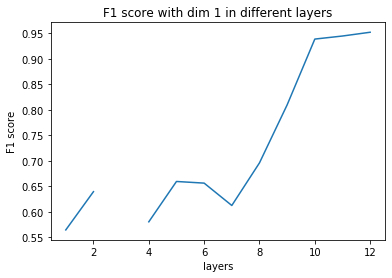

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


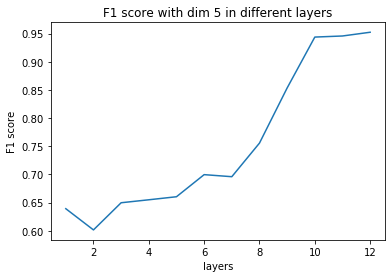

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


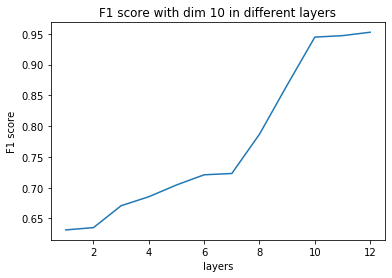

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


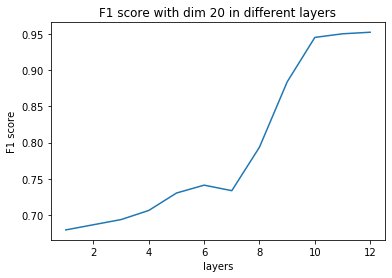

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


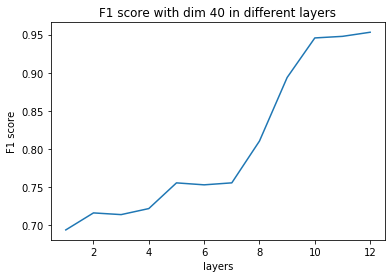

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


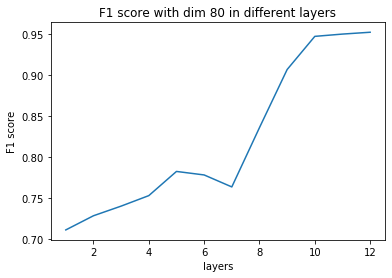

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


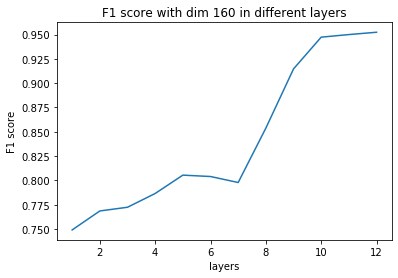

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


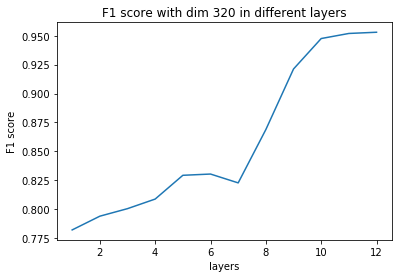

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


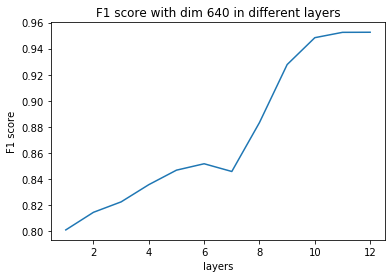

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


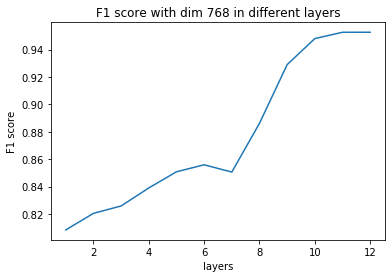

In [59]:
for dim in [1,5,10,20,40,80,160,320,640,768]:
    plot_one_dim(results_dict,dim)

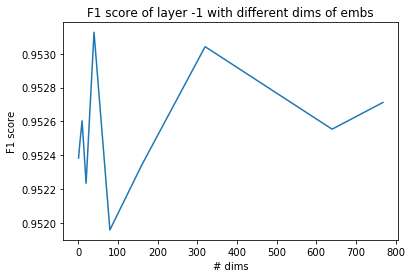

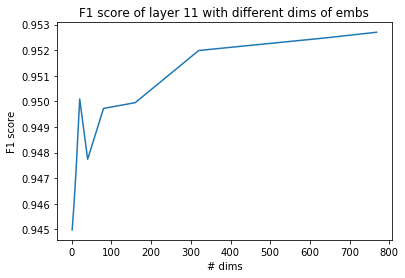

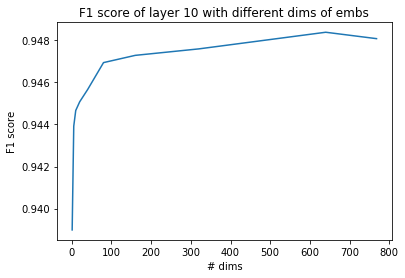

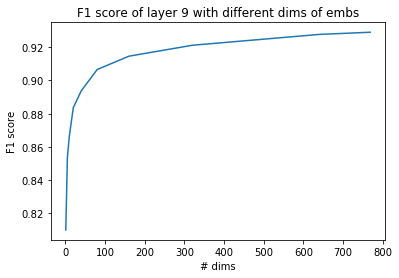

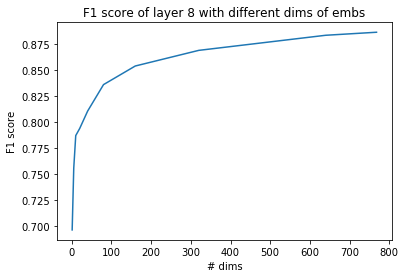

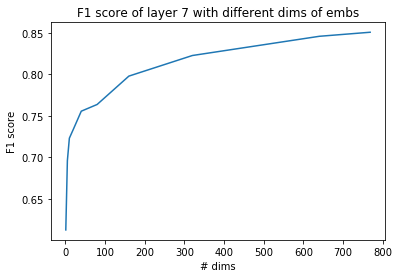

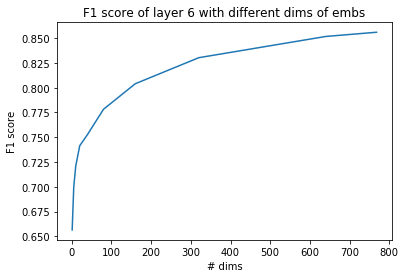

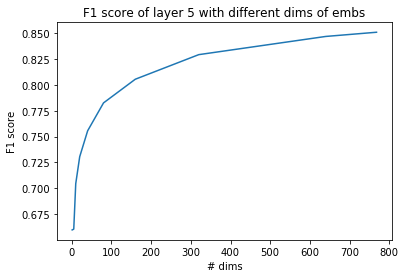

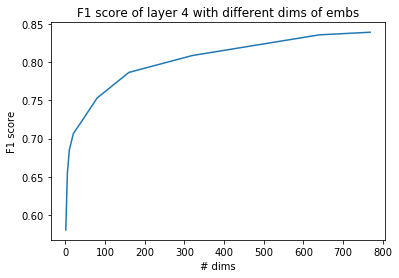

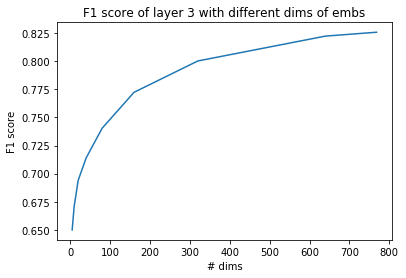

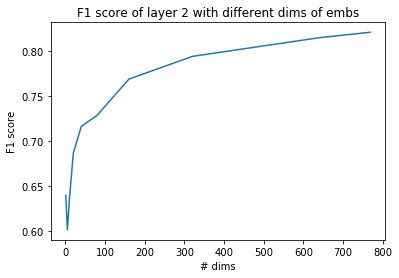

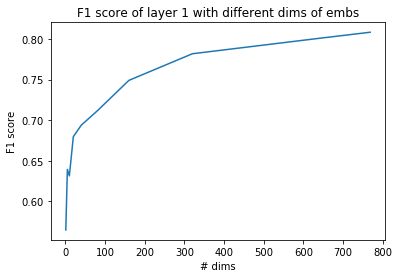

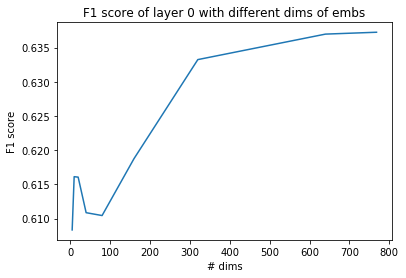

In [31]:
for layer in results_dict:
    plot_one_layer(results_dict,layer)

# study of the emb

we now study some of the characteristics of the embs

## Pearson's correlation between the vectors

the different dims are highly correlated...

In [20]:
from scipy.stats import pearsonr

In [21]:
def get_pearsonr_dist(layer):
    eval_BERT_emb_dataset=take_BERT_embeddings(eval_dataset, 
                                          tokenizer, 
                                          device='cuda:2', 
                                          is_train=False, 
                                          checkpoint='output/outputs-bert-base-cased/checkpoint-34000', 
                                          layer=layer, 
                                          overwrite=False)
    train_BERT_emb_dataset=take_BERT_embeddings(train_dataset, 
                                          tokenizer, 
                                          device='cuda:2', 
                                          is_train=True, 
                                          checkpoint='output/outputs-bert-base-cased/checkpoint-34000', 
                                          layer=layer, 
                                          overwrite=False)
    embs=eval_BERT_emb_dataset[:][0]
    num_dims=embs.shape[1]
    corrs=[]
#     for i in tqdm_notebook(range(num_dims)):
#         for j in range(num_dims):
#             if i!=j:
#                 corr, _ = pearsonr(embs[:,i], embs[:,j])
#                 corrs.append(corr)
    j = 1
    for i in tqdm_notebook(range(num_dims)):
        if i!=j:
            corr, _ = pearsonr(embs[:,i], embs[:,j])
            corrs.append(corr)
    return corrs

corrs=get_pearsonr_dist(layer=-1)

INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_-1layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/train_-1layer_BERT_sent_emb


In [102]:
corrs=np.absolute(corrs)

In [103]:
max(corrs),min(corrs),sum(corrs)/len(corrs)

(0.965503977287079, 0.0008399756610264731, 0.6055143657168368)

In [110]:
def get_pearsonr_dist(layer,iter_num=34000):
    eval_BERT_emb_dataset=take_BERT_embeddings(eval_dataset, 
                                          tokenizer, 
                                          device='cuda:2', 
                                          is_train=False, 
                                          checkpoint='output/outputs-bert-base-cased/checkpoint-{}'.format(iter_num), 
                                          layer=layer, 
                                          overwrite=False)
    train_BERT_emb_dataset=take_BERT_embeddings(train_dataset, 
                                          tokenizer, 
                                          device='cuda:2', 
                                          is_train=True, 
                                          checkpoint='output/outputs-bert-base-cased/checkpoint-{}'.format(iter_num), 
                                          layer=layer, 
                                          overwrite=False)
#     embs=eval_BERT_emb_dataset[:5000][0]
#     labels=eval_BERT_emb_dataset[:5000][1]
    embs=train_BERT_emb_dataset[:5000][0]
    labels=train_BERT_emb_dataset[:5000][1]
    
    num_dims=embs.shape[1]
    corrs=[]
    for i in tqdm_notebook(range(num_dims)):
        corr, _ = pearsonr(embs[:,i], labels)
        corrs.append(abs(corr))
    return corrs

In [116]:
li=[]
embs=BoW_train_data[:5000][0]
labels=BoW_train_data[:5000][1]
num_dims=embs.shape[1]
corrs=[]
for i in tqdm_notebook(range(num_dims)):
    corr, _ = pearsonr(embs[:,i], labels)
    corrs.append(abs(corr))
corrs=np.array(corrs)
corrs= np.nan_to_num(corrs)

print('{:.4f},{:.4f}'.format(max(corrs),sum(corrs)/len(corrs)))



0.2497,0.0065


In [117]:
li=[]
for iter_num in [0,34000]:
    for layer in [2,4,6,8,10,-1]:
        corrs=get_pearsonr_dist(layer,iter_num)
        li.append('{:.4f},{:.4f}'.format(max(corrs),sum(corrs)/len(corrs)))
for l in li:
    print(l)

INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/dev_2layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/train_2layer_BERT_sent_emb


INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/dev_4layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/train_4layer_BERT_sent_emb


INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/dev_6layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/train_6layer_BERT_sent_emb


INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/dev_8layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/train_8layer_BERT_sent_emb


INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/dev_10layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/train_10layer_BERT_sent_emb


INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/dev_-1layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/train_-1layer_BERT_sent_emb


INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_2layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/train_2layer_BERT_sent_emb


INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_4layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/train_4layer_BERT_sent_emb


INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_6layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/train_6layer_BERT_sent_emb


INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_8layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/train_8layer_BERT_sent_emb


INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_10layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/train_10layer_BERT_sent_emb


INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_-1layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/train_-1layer_BERT_sent_emb



0.1672,0.0499
0.1744,0.0498
0.1979,0.0541
0.1864,0.0589
0.1849,0.0594
0.2010,0.0566
0.2401,0.0663
0.2633,0.0718
0.3268,0.0909
0.4812,0.1208
0.8903,0.4553
0.9428,0.7183


In [105]:
abs(-1)

1

In [106]:
max(corrs),sum(corrs)/len(corrs)

(0.9467007745611955, 0.006139171616757873)

# New features
BoW, TFIDF, sentence length

## Some Preparation code

In [22]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, HashingVectorizer
import pandas as pd
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch
# from torchtext import data
#import spacy
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
tqdm.pandas(desc='Progress')
from collections import Counter
# from textblob import TextBlob
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

import os 
import nltk
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
# from unidecode import unidecode

from sklearn.preprocessing import StandardScaler
# from textblob import TextBlob
from multiprocessing import  Pool
from functools import partial
import numpy as np
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVC
# import lightgbm as lgb

/opt/anaconda3/lib/python3.7/site-packages/tqdm/_tqdm.py:634: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [23]:
# Some preprocesssing that will be common to all the text classification methods you will see. 

# Remove punctuations:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_text(x):
    x = str(x)
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, ' ')
    return x

# We won't clean numbers in conventional methods case since we might get extra info from bigrams like 5 mins or 30 mins
def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

# Remove Misspell:
mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization'}

def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

mispellings, mispellings_re = _get_mispell(mispell_dict)
def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]
    return mispellings_re.sub(replace, text)

# remove stopwords:
stopword_list = nltk.corpus.stopwords.words('english')
def remove_stopwords(text, is_lower_case=True):
    tokenizer = ToktokTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

# remove contractions:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

# Using lemmatizer to keep dictionary form of words. Might be helpful if later we want to use word embeddings.
wordnet_lemmatizer = WordNetLemmatizer()
def lemma_text(text):
    tokenizer = ToktokTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    tokens = [wordnet_lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)


def clean_sentence(x):
    x = x.lower()
    x = clean_text(x)
    x = replace_typical_misspell(x)
    x = remove_stopwords(x)
    x = replace_contractions(x)
    x = lemma_text(x)
    x = x.replace("'","")
    return x

## start process

In [24]:
train_df = pd.read_csv('data/train.tsv', header=None,sep='\t',names=['id','label','alpha','text'])
eval_df = pd.read_csv('data/dev.tsv', header=None,sep='\t',names=['id','label','alpha','text'])

In [26]:
train_df['cleaned_text'] = train_df['text'].apply(lambda x : clean_sentence(x))

In [27]:
eval_df['cleaned_text'] = eval_df['text'].apply(lambda x : clean_sentence(x))

In [28]:
train_df.head()

id  label alpha                                               text  \
0   0      0     a  Unfortunately, the frustration of being Dr. Go...   
1   1      1     a  Been going to Dr. Goldberg for over 10 years. ...   
2   2      0     a  I don't know what Dr. Goldberg was like before...   
3   3      0     a  I'm writing this review to give you a heads up...   
4   4      1     a  All the food is great here. But the best thing...   

                                        cleaned_text  
0  unfortunately frustration dr goldberg patient ...  
1  going dr goldberg 10 year think one 1st patien...  
2  know dr goldberg like moving arizona let tell ...  
3  writing review give head see doctor office sta...  
4  food great best thing wing wing simply fantast...

In [29]:
cnt_vectorizer = CountVectorizer(dtype=np.float32,
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 1),min_df=10)

In [30]:
# Fitting count vectorizer to both training and test sets (semi-supervised learning)
cnt_vectorizer.fit(list(train_df.cleaned_text.values) + list(eval_df.cleaned_text.values))

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float32'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=10, ngram_range=(1, 1), preprocessor=None,
                stop_words=None, strip_accents='unicode',
                token_pattern='\\w{1,}', tokenizer=None, vocabulary=None)

In [31]:

x_train =  cnt_vectorizer.transform(train_df.cleaned_text.values) 
#xtest_cntv = cnt_vectorizer.transform(test_df.cleaned_text.values)
y_train = train_df.label.values

In [32]:
x_eval =  cnt_vectorizer.transform(eval_df.cleaned_text.values) 
#xtest_cntv = cnt_vectorizer.transform(test_df.cleaned_text.values)
y_eval = eval_df.label.values

In [30]:
# x_train_tensor=torch.tensor(x_train)

In [143]:
# x_train=x_train.toarray()
# x_train_tensor=torch.tensor(x_train)
# del x_train
# BoW_train_data = TensorDataset(x_train_tensor, torch.tensor(y_train))

In [33]:
x_eval=x_eval.toarray()
x_eval_tensor=torch.tensor(x_eval)
del x_eval

In [34]:
BoW_eval_data = TensorDataset(x_eval_tensor, torch.tensor(y_eval))


In [144]:
# BoW_train_data = TensorDataset(x_train_tensor, torch.tensor(y_train))
# # BoW_eval_data = TensorDataset(x_eval_tensor, torch.tensor(y_eval))


In [34]:
# config['num_train_epochs']=3

# alignment

In [35]:
import multiprocessing

In [43]:


def deal_with_one_dim(index):
    emb=embs[:,index]
    coor=np.zeros([BoW_embs.shape[1]])
    for i in range(BoW_embs.shape[1]):
        BoW_emb=BoW_embs[:,i]
        corr, _ = pearsonr(emb, BoW_emb)
        coor[i]=corr
    return [coor,index]
        
    

def get_sim_matrix(embs):
    sim_matrix=np.zeros([embs.shape[1],BoW_embs.shape[1]])
    indecis=list(range(embs.shape[1]))
    sim_list=[]
    cores = multiprocessing.cpu_count()
    cores = 50
    pool = multiprocessing.Pool(processes=cores)
    for y in tqdm(pool.imap_unordered(deal_with_one_dim, indecis),total=len(indecis)):
        sim_list.append(y)
    for pair in sim_list:
        sim_matrix[pair[1],:]=pair[0]
    sim_matrix= np.nan_to_num(sim_matrix)
    return sim_matrix

def get_alignment(sim_matrix):
    cu_corr_value=0
    aligned_idx=[]
    for i in range(sim_matrix.shape[0]):
        corr=sim_matrix[i,:]
        idx=np.argmax(corr)
        corr_value=corr[idx]
        cu_corr_value+=corr_value
        aligned_idx.append(idx)
    return cu_corr_value,aligned_idx

def get_k_alignment(sim_matrix,k,is_abs=True):
    """
    get each BERT's dim's most related k aligned dim 
    """
    if is_abs:
        sim_matrix_=np.absolute(sim_matrix)
    else:
        sim_matrix_=sim_matrix
    k_sim_matrix=np.argsort(-sim_matrix_, axis=1) 
    aligned_idx=[]
    corr_value=[]
    for i in range(sim_matrix.shape[0]):
        inds=k_sim_matrix[i,:k]
        for ind in inds:
            aligned_idx.append(ind)
            corr_value.append(sim_matrix_[i,ind])
    return corr_value,aligned_idx

def train_aligned_emb(sim_matrix,k=1):
    corr_value,aligned_idx=get_k_alignment(sim_matrix,k=k)
    config['num_train_epochs']=1
    dims=list(set(aligned_idx))
    sub_BoW_train_data = make_BERT_emb_sub_dataset(BoW_train_data,dims)
    sub_BoW_eval_data = make_BERT_emb_sub_dataset(BoW_eval_data,dims)
    result=trainBinaryClassifierFC(train_dataset=sub_BoW_train_data, 
                        eval_dataset=sub_BoW_eval_data, 
                        device='cuda:3',
                        save_dir='output/BoV')
    trail_result={
        'avg_corr_value':sum(corr_value)/len(corr_value),
        'max_corr_value':max(corr_value),
        'corr_value':corr_value,
        'aligned_idx':aligned_idx,
        'len_aligned':len(dims),
        'idx_aligned_trained':dims,
        'result':result,
        'k':k
    }
    del sub_BoW_train_data
    del sub_BoW_eval_data
    return trail_result

In [77]:
eval_BERT_emb_dataset[:][0].shape

torch.Size([38000, 768])

In [37]:
checkpoint=34000
sim_matrix_dict_34000={}
results_34000={}
BoW_embs=BoW_eval_data[:5000][0]
for layer in [-1,10,8,6,4,2]:
    eval_BERT_emb_dataset=take_BERT_embeddings(eval_dataset, 
                                          tokenizer, 
                                          device='cuda:2', 
                                          is_train=False, 
                                          checkpoint='output/outputs-bert-base-cased/checkpoint-{}'.format(checkpoint), 
                                          layer=layer, 
                                          overwrite=False)
    train_BERT_emb_dataset=take_BERT_embeddings(train_dataset, 
                                          tokenizer, 
                                          device='cuda:2', 
                                          is_train=True, 
                                          checkpoint='output/outputs-bert-base-cased/checkpoint-{}'.format(checkpoint), 
                                          layer=layer, 
                                          overwrite=False)
    embs=eval_BERT_emb_dataset[:5000][0]
    sim_matrix_=get_sim_matrix(embs)
    sim_matrix_dict_34000[layer]=sim_matrix_

        

INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_-1layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/train_-1layer_BERT_sent_emb
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is consta

INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_10layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/train_10layer_BERT_sent_emb
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is consta

INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_8layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/train_8layer_BERT_sent_emb


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is consta

INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_6layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/train_6layer_BERT_sent_emb


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is consta

INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_4layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/train_4layer_BERT_sent_emb


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is consta

INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/dev_2layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-34000/train_2layer_BERT_sent_emb
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is consta

Process ForkPoolWorker-95:
Process ForkPoolWorker-47:
Process ForkPoolWorker-33:
Process ForkPoolWorker-88:
Process ForkPoolWorker-96:
Process ForkPoolWorker-86:
Process ForkPoolWorker-59:
Process ForkPoolWorker-48:
Process ForkPoolWorker-43:
Process ForkPoolWorker-294:
Process ForkPoolWorker-55:
Process ForkPoolWorker-79:
Process ForkPoolWorker-67:
Process ForkPoolWorker-264:
Process ForkPoolWorker-17:
Process ForkPoolWorker-46:
Process ForkPoolWorker-136:
Process ForkPoolWorker-39:
Process ForkPoolWorker-38:
Process ForkPoolWorker-120:
Process ForkPoolWorker-229:
Process ForkPoolWorker-85:
Process ForkPoolWorker-10:
Process ForkPoolWorker-93:
Process ForkPoolWorker-168:
Process ForkPoolWorker-42:
Process ForkPoolWorker-179:
Process ForkPoolWorker-24:
Process ForkPoolWorker-90:
Process ForkPoolWorker-244:
Process ForkPoolWorker-11:
Process ForkPoolWorker-15:
Process ForkPoolWorker-41:
Process ForkPoolWorker-26:
Process ForkPoolWorker-111:
Process ForkPoolWorker-19:
Process ForkPoolWor

In [41]:
# sim_matrix_dict_34000

{-1: array([[ 0.03432015,  0.0585255 ,  0.0333641 , ..., -0.01319973,
          0.        ,  0.        ],
        [-0.04951432, -0.05004532, -0.03209539, ..., -0.02942806,
          0.        ,  0.        ],
        [ 0.05361341,  0.05221222,  0.03282348, ...,  0.01057118,
          0.        ,  0.        ],
        ...,
        [-0.06190237, -0.05416996, -0.03330683, ...,  0.00832093,
          0.        ,  0.        ],
        [-0.04214982, -0.0783631 , -0.04528382, ..., -0.00342265,
          0.        ,  0.        ],
        [ 0.04108496,  0.02132484,  0.01364755, ...,  0.03167089,
          0.        ,  0.        ]]),
 10: array([[ 0.03546188,  0.04799155,  0.04811076, ...,  0.01798646,
          0.        ,  0.        ],
        [ 0.04516462, -0.0121633 ,  0.00647336, ...,  0.00173491,
          0.        ,  0.        ],
        [-0.0447899 , -0.01274277, -0.02256694, ...,  0.0083733 ,
          0.        ,  0.        ],
        ...,
        [ 0.05853064,  0.0248715 ,  0.03500961

In [38]:
checkpoint=0
sim_matrix_dict_0={}
results_0={}
BoW_embs=BoW_eval_data[:5000][0]
for layer in [-1,10,8,6,4,2]:
    eval_BERT_emb_dataset=take_BERT_embeddings(eval_dataset, 
                                          tokenizer, 
                                          device='cuda:2', 
                                          is_train=False, 
                                          checkpoint='output/outputs-bert-base-cased/checkpoint-{}'.format(checkpoint), 
                                          layer=layer, 
                                          overwrite=False)
    train_BERT_emb_dataset=take_BERT_embeddings(train_dataset, 
                                          tokenizer, 
                                          device='cuda:2', 
                                          is_train=True, 
                                          checkpoint='output/outputs-bert-base-cased/checkpoint-{}'.format(checkpoint), 
                                          layer=layer, 
                                          overwrite=False)
    embs=eval_BERT_emb_dataset[:5000][0]
    sim_matrix_=get_sim_matrix(embs)
    sim_matrix_dict_0[layer]=sim_matrix_


INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/dev_-1layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/train_-1layer_BERT_sent_emb


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is consta

INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/dev_10layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/train_10layer_BERT_sent_emb


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is consta

INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/dev_8layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/train_8layer_BERT_sent_emb
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is consta

INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/dev_6layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/train_6layer_BERT_sent_emb


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is consta

INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/dev_4layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/train_4layer_BERT_sent_emb
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is consta

INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/dev_2layer_BERT_sent_emb
INFO:__main__:Loading BERT features from cache file output/outputs-bert-base-cased/checkpoint-0/train_2layer_BERT_sent_emb
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is consta

Process ForkPoolWorker-600:
Process ForkPoolWorker-390:
Process ForkPoolWorker-418:
Process ForkPoolWorker-434:
Process ForkPoolWorker-530:
Process ForkPoolWorker-596:
Process ForkPoolWorker-338:
Process ForkPoolWorker-587:
Process ForkPoolWorker-337:
Process ForkPoolWorker-578:
Process ForkPoolWorker-586:
Process ForkPoolWorker-443:
Process ForkPoolWorker-426:
Process ForkPoolWorker-427:
Process ForkPoolWorker-496:
Process ForkPoolWorker-589:
Process ForkPoolWorker-583:
Process ForkPoolWorker-330:
Process ForkPoolWorker-597:
Process ForkPoolWorker-471:
Process ForkPoolWorker-565:
Process ForkPoolWorker-593:
Process ForkPoolWorker-571:
Process ForkPoolWorker-564:
Process ForkPoolWorker-567:
Process ForkPoolWorker-599:
Process ForkPoolWorker-439:
Process ForkPoolWorker-336:
Process ForkPoolWorker-566:
Process ForkPoolWorker-420:
Process ForkPoolWorker-329:
Process ForkPoolWorker-340:
Process ForkPoolWorker-320:
Process ForkPoolWorker-442:
Process ForkPoolWorker-310:
Process ForkPoolWork

In [41]:
sim_matrix_dict_0

{-1: array([[-0.00218995,  0.01318864,  0.00745022, ...,  0.02385079,
          0.        ,  0.        ],
        [ 0.00544882, -0.01434742, -0.01642454, ..., -0.00416306,
          0.        ,  0.        ],
        [-0.0326197 ,  0.00349744,  0.01595718, ..., -0.00973127,
          0.        ,  0.        ],
        ...,
        [ 0.00641806, -0.04142899, -0.00015475, ..., -0.00913096,
          0.        ,  0.        ],
        [-0.01478361,  0.01163989,  0.0260917 , ...,  0.00579375,
          0.        ,  0.        ],
        [-0.00181787,  0.01780629, -0.00107046, ...,  0.00800305,
          0.        ,  0.        ]]),
 10: array([[-0.01046217, -0.01060077,  0.01627297, ...,  0.0208146 ,
          0.        ,  0.        ],
        [ 0.00171969, -0.0281204 , -0.01745696, ...,  0.00634646,
          0.        ,  0.        ],
        [-0.03260376, -0.01930239,  0.01499505, ..., -0.00921547,
          0.        ,  0.        ],
        ...,
        [ 0.01099599, -0.03100815, -0.01020352

In [40]:

x_train =  cnt_vectorizer.transform(train_df.cleaned_text.values) 
#xtest_cntv = cnt_vectorizer.transform(test_df.cleaned_text.values)
y_train = train_df.label.values
x_train=x_train.toarray()
x_train_tensor=torch.from_numpy(x_train)
BoW_train_data = TensorDataset(x_train_tensor, torch.tensor(y_train))

In [135]:
BoW_train_data[:][0].shape

torch.Size([560000, 41126])

In [132]:
for layer in  [-1,10,8,6,4,2]:
    if layer not in results_34000:
        results_34000[layer]={}
    
    logger.info("="*100)
    logger.info('finish sim mat of layer {}'.format(layer))
    logger.info("="*100)
    
#     for k in range(4):
    for k in [0]:
        trail_result=train_aligned_emb(sim_matrix_dict_34000[layer],k=k+1)
        results_34000[layer][k]=trail_result
    logger.info("*"*100)
    logger.info('finish alignment of layer {}'.format(layer))
    logger.info("*"*100)

INFO:__main__:====================================================================================================
INFO:__main__:finish sim mat of layer -1
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 21])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.711499908875524
INFO:__main__:  fn = 3384
INFO:__main__:  fp = 9280
INFO:__main__:  mcc = 0.3507909969888942
INFO:__main__:  p = 0.6272493573264781
INFO:__main__:  r = 0.8218947368421052
INFO:__main__:  tn = 9720
INFO:__main__:  tp = 15616

Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.89s/it]
INFO:__main__:****************************************************************************************************
INFO:__main__:finish alignment of layer -1
INFO:__main__:****************************************************************************************************
INFO:__main__:====================================================================================================
INFO:__main__:finish sim mat of layer 10
INFO:__main__:====================================================================================================



21875.241799533367


INFO:__main__:training data shape torch.Size([560000, 66])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7469819663172537
INFO:__main__:  fn = 3964
INFO:__main__:  fp = 6222
INFO:__main__:  mcc = 0.4672057466949907
INFO:__main__:  p = 0.707310189105278
INFO:__main__:  r = 0.7913684210526316
INFO:__main__:  tn = 12778
INFO:__main__:  tp = 15036

Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.14s/it]
INFO:__main__:****************************************************************************************************
INFO:__main__:finish alignment of layer 10
INFO:__main__:****************************************************************************************************
INFO:__main__:====================================================================================================
INFO:__main__:finish sim mat of layer 8
INFO:__main__:====================================================================================================



20104.114867702127


INFO:__main__:training data shape torch.Size([560000, 84])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7728066843904293
INFO:__main__:  fn = 3739
INFO:__main__:  fp = 5234
INFO:__main__:  mcc = 0.5293781306992024
INFO:__main__:  p = 0.7446206391802879
INFO:__main__:  r = 0.8032105263157895
INFO:__main__:  tn = 13766
INFO:__main__:  tp = 15261

Epoch: 100%|██████████| 1/1 [00:54<00:00, 54.49s/it]
INFO:__main__:****************************************************************************************************
INFO:__main__:finish alignment of layer 8
INFO:__main__:****************************************************************************************************
INFO:__main__:====================================================================================================
INFO:__main__:finish sim mat of layer 6
INFO:__main__:====================================================================================================



18958.523216098547


INFO:__main__:training data shape torch.Size([560000, 99])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7616517500193443
INFO:__main__:  fn = 4235
INFO:__main__:  fp = 5006
INFO:__main__:  mcc = 0.5140549878929713
INFO:__main__:  p = 0.7468008699610541
INFO:__main__:  r = 0.7771052631578947
INFO:__main__:  tn = 13994
INFO:__main__:  tp = 14765

Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.60s/it]
INFO:__main__:****************************************************************************************************
INFO:__main__:finish alignment of layer 6
INFO:__main__:****************************************************************************************************
INFO:__main__:====================================================================================================
INFO:__main__:finish sim mat of layer 4
INFO:__main__:====================================================================================================



19053.398236870766


INFO:__main__:training data shape torch.Size([560000, 122])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7648777564118573
INFO:__main__:  fn = 3686
INFO:__main__:  fp = 5729
INFO:__main__:  mcc = 0.5074155585046006
INFO:__main__:  p = 0.7277479446846933
INFO:__main__:  r = 0.806
INFO:__main__:  tn = 13271
INFO:__main__:  tp = 15314

Epoch: 100%|██████████| 1/1 [00:49<00:00, 49.87s/it]
INFO:__main__:****************************************************************************************************
INFO:__main__:finish alignment of layer 4
INFO:__main__:****************************************************************************************************
INFO:__main__:====================================================================================================
INFO:__main__:finish sim mat of layer 2
INFO:__main__:====================================================================================================



19164.923574253917


INFO:__main__:training data shape torch.Size([560000, 148])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7319375277031784
INFO:__main__:  fn = 4964
INFO:__main__:  fp = 5317
INFO:__main__:  mcc = 0.45897395737129576
INFO:__main__:  p = 0.7252622332454917
INFO:__main__:  r = 0.7387368421052631
INFO:__main__:  tn = 13683
INFO:__main__:  tp = 14036

Epoch: 100%|██████████| 1/1 [00:56<00:00, 56.73s/it]
INFO:__main__:****************************************************************************************************
INFO:__main__:finish alignment of layer 2
INFO:__main__:****************************************************************************************************



19741.03624022007


In [133]:
for layer in  [-1,10,8,6,4,2]:
    if layer not in results_0:
        results_0[layer]={}
    
    logger.info("="*100)
    logger.info('finish sim mat of layer {}'.format(layer))
    logger.info("="*100)
    
#     for k in range(4):
    for k in [0]:
        trail_result=train_aligned_emb(sim_matrix_dict_0[layer],k=k+1)
        results_0[layer][k]=trail_result
    logger.info("*"*100)
    logger.info('finish alignment of layer {}'.format(layer))
    logger.info("*"*100)

INFO:__main__:====================================================================================================
INFO:__main__:finish sim mat of layer -1
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 120])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7760593166356664
INFO:__main__:  fn = 3771
INFO:__main__:  fp = 5018
INFO:__main__:  mcc = 0.5385822771744034
INFO:__main__:  p = 0.7521608139477454
INFO:__main__:  r = 0.8015263157894736
INFO:__main__:  tn = 13982
INFO:__main__:  tp = 15229

Epoch: 100%|██████████| 1/1 [00:52<00:00, 52.97s/it]
INFO:__main__:****************************************************************************************************
INFO:__main__:finish alignment of layer -1
INFO:__main__:****************************************************************************************************
INFO:__main__:====================================================================================================
INFO:__main__:finish sim mat of layer 10
INFO:__main__:====================================================================================================



18550.202599838376


INFO:__main__:training data shape torch.Size([560000, 111])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7679833257078948
INFO:__main__:  fn = 3893
INFO:__main__:  fp = 5235
INFO:__main__:  mcc = 0.5208798598182748
INFO:__main__:  p = 0.7426506734834333
INFO:__main__:  r = 0.7951052631578948
INFO:__main__:  tn = 13765
INFO:__main__:  tp = 15107

Epoch: 100%|██████████| 1/1 [00:53<00:00, 53.55s/it]
INFO:__main__:****************************************************************************************************
INFO:__main__:finish alignment of layer 10
INFO:__main__:****************************************************************************************************
INFO:__main__:====================================================================================================
INFO:__main__:finish sim mat of layer 8
INFO:__main__:====================================================================================================



19076.145156994462


INFO:__main__:training data shape torch.Size([560000, 117])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7359215238490683
INFO:__main__:  fn = 4821
INFO:__main__:  fp = 5355
INFO:__main__:  mcc = 0.46460458581473174
INFO:__main__:  p = 0.7258625985461247
INFO:__main__:  r = 0.7462631578947369
INFO:__main__:  tn = 13645
INFO:__main__:  tp = 14179

Epoch: 100%|██████████| 1/1 [00:53<00:00, 53.22s/it]
INFO:__main__:****************************************************************************************************
INFO:__main__:finish alignment of layer 8
INFO:__main__:****************************************************************************************************
INFO:__main__:====================================================================================================
INFO:__main__:finish sim mat of layer 6
INFO:__main__:====================================================================================================



19970.18358927965


INFO:__main__:training data shape torch.Size([560000, 142])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7413286149202467
INFO:__main__:  fn = 4755
INFO:__main__:  fp = 5186
INFO:__main__:  mcc = 0.476912192639171
INFO:__main__:  p = 0.7331068910503834
INFO:__main__:  r = 0.7497368421052631
INFO:__main__:  tn = 13814
INFO:__main__:  tp = 14245

Epoch: 100%|██████████| 1/1 [00:52<00:00, 52.93s/it]
INFO:__main__:****************************************************************************************************
INFO:__main__:finish alignment of layer 6
INFO:__main__:****************************************************************************************************
INFO:__main__:====================================================================================================
INFO:__main__:finish sim mat of layer 4
INFO:__main__:====================================================================================================



19547.883985459805


INFO:__main__:training data shape torch.Size([560000, 153])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7601130317456277
INFO:__main__:  fn = 4071
INFO:__main__:  fp = 5352
INFO:__main__:  mcc = 0.5052021624482187
INFO:__main__:  p = 0.7361076869976826
INFO:__main__:  r = 0.7857368421052632
INFO:__main__:  tn = 13648
INFO:__main__:  tp = 14929

Epoch: 100%|██████████| 1/1 [00:53<00:00, 53.19s/it]
INFO:__main__:****************************************************************************************************
INFO:__main__:finish alignment of layer 4
INFO:__main__:****************************************************************************************************
INFO:__main__:====================================================================================================
INFO:__main__:finish sim mat of layer 2
INFO:__main__:====================================================================================================



19333.170308858156


INFO:__main__:training data shape torch.Size([560000, 149])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7123237693169676
INFO:__main__:  fn = 5333
INFO:__main__:  fp = 5706
INFO:__main__:  mcc = 0.41908076441350356
INFO:__main__:  p = 0.705466370722139
INFO:__main__:  r = 0.7193157894736842
INFO:__main__:  tn = 13294
INFO:__main__:  tp = 13667

Epoch: 100%|██████████| 1/1 [00:52<00:00, 52.79s/it]
INFO:__main__:****************************************************************************************************
INFO:__main__:finish alignment of layer 2
INFO:__main__:****************************************************************************************************



20576.320482343435


In [64]:
# results_34000
{-1: {0: {'avg_corr_value': 0.25062877415777773,
   'max_corr_value': 0.32287620150218355,
   'corr_value': [0.18171139750446452, 
                  ....,
                  0.2145755681241372],
   'aligned_idx': [15132,
    15132,
   ....
    15132]
   'len_aligned': 21,
   'idx_aligned_trained': [4867,
    4101,
    3081,
    40073]
   'result': {'mcc': 0.3542398379908024,
    'tp': 15749,
    'tn': 9622,
    'fp': 9378,
    'fn': 3251,
    'p': 0.6267759780315995,
    'r': 0.8288947368421052,
    'f1': 0.7138033403585107},
   'k': 1,}
     
     }
}

{-1: {0: {'avg_corr_value': 0.25062877415777773,
   'max_corr_value': 0.32287620150218355,
   'corr_value': [0.18171139750446452,
    0.2819092337115784,
    0.31487928598571124,
    0.28131538263310274,
    0.2338111433324647,
    0.29360847719081434,
    0.31958628724955906,
    0.31530924821413525,
    0.3021071086968272,
    0.2993062680200484,
    0.3093285018360073,
    0.31014185492533125,
    0.3003596990757774,
    0.26508751157833427,
    0.28996675609509387,
    0.19121275731821738,
    0.25046089405968347,
    0.1691064830424465,
    0.22547389258769193,
    0.2165285843710881,
    0.07393418766823844,
    0.2758968448169689,
    0.19910939639784417,
    0.28515862739201714,
    0.3093906191404731,
    0.10440986597967102,
    0.20873702399255917,
    0.2330352263548574,
    0.31801895671193947,
    0.3006178040111266,
    0.15631180239633402,
    0.238889463524982,
    0.2904294374401685,
    0.07550064179593037,
    0.3125743625265538,
    0.2619948147229154,
    0.302207

In [126]:
# show the subspace alignment resutls
results=results_0
for layer in [2,4,6,8,10,-1]:
    for k in [0]:
        l=results[layer][k]
        a='{:.4f},{},{:.4f},{:.4f}'.format(l['result']['f1'],l['len_aligned'],l['max_corr_value'],l['avg_corr_value'])
        print(a)
        

results=results_34000
for layer in [2,4,6,8,10,-1]:
    for k in [0]:
        l=results[layer][k]
        a='{:.4f},{},{:.4f},{:.4f}'.format(l['result']['f1'],l['len_aligned'],l['max_corr_value'],l['avg_corr_value'])
        print(a)
        


0.7218,149,0.2400,0.0991
0.7588,153,0.2551,0.1002
0.7412,142,0.2461,0.1049
0.7399,117,0.2557,0.1132
0.7664,111,0.2452,0.1105
0.7757,120,0.2464,0.1073
0.7313,148,0.2331,0.0986
0.7624,122,0.2524,0.1047
0.7599,99,0.2763,0.1151
0.7704,84,0.2757,0.1218
0.7444,66,0.3137,0.1887
0.6487,21,0.3229,0.2506


In [134]:
results=results_0
for layer in [2,4,6,8,10,-1]:
    for k in [0]:
        l=results[layer][k]
        a='{:.4f},{},{:.4f},{:.4f}'.format(l['result']['f1'],l['len_aligned'],l['max_corr_value'],l['avg_corr_value'])
        print(a)
        

results=results_34000
for layer in [2,4,6,8,10,-1]:
    for k in [0]:
        l=results[layer][k]
        a='{:.4f},{},{:.4f},{:.4f}'.format(l['result']['f1'],l['len_aligned'],l['max_corr_value'],l['avg_corr_value'])
        print(a)

0.7123,149,0.2400,0.0991
0.7601,153,0.2551,0.1002
0.7413,142,0.2461,0.1049
0.7359,117,0.2557,0.1132
0.7680,111,0.2452,0.1105
0.7761,120,0.2464,0.1073
0.7319,148,0.2331,0.0986
0.7649,122,0.2524,0.1047
0.7617,99,0.2763,0.1151
0.7728,84,0.2757,0.1218
0.7470,66,0.3137,0.1887
0.7115,21,0.3229,0.2506


## BoW selecting results

In [74]:
# results_BoW={}
config['num_train_epochs']=3
cor=get_the_cor_of_emb(dataset=BoW_train_data)
sorted_index=sorted(range(len(cor)), key=lambda k: cor[k],reverse=True)
for dim_num in [1,5,10,20,40,80,160,320,640,768]:
    if dim_num not in results_BoW:
        logger.info("="*100)
        logger.info("="*100)
        logger.info("dims: {}".format(dim_num))
        logger.info("="*100)
        logger.info("="*100)

        dims=sorted_index[:dim_num]
        sub_BoW_train_data = make_BERT_emb_sub_dataset(BoW_train_data,dims)
        sub_BoW_eval_data = make_BERT_emb_sub_dataset(BoW_eval_data,dims)
        result=trainBinaryClassifierFC(train_dataset=sub_BoW_train_data, 
                                eval_dataset=sub_BoW_eval_data, 
                                device='cuda:3',
                                save_dir='output/BoW')

        results_BoW[dim_num]=result
        del sub_BoW_train_data
        del sub_BoW_eval_data



INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:dims: 1
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 1])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.5133072142664143
INFO:__main__:  fn = 11401
INFO:__main__:  fp = 3009
INFO:__main__:  mcc = 0.26926757460630824
INFO:__main__:  p = 0.7163461538461539
INFO:__main__:  r = 0.3999473684210526
INFO:__main__:  tn = 15991
INFO:__main__:  tp = 7599

Epoch: 100%|██████████| 1/1 [00:48<00:00, 48.34s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:dims: 5
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



25944.07187065482


INFO:__main__:training data shape torch.Size([560000, 5])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7121614655616796
INFO:__main__:  fn = 1040
INFO:__main__:  fp = 13478
INFO:__main__:  mcc = 0.31205150706731993
INFO:__main__:  p = 0.5712831605063935
INFO:__main__:  r = 0.9452631578947368
INFO:__main__:  tn = 5522
INFO:__main__:  tp = 17960

Epoch: 100%|██████████| 1/1 [00:49<00:00, 49.29s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:dims: 10
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



22863.073644816875


INFO:__main__:training data shape torch.Size([560000, 10])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7390346230453024
INFO:__main__:  fn = 1561
INFO:__main__:  fp = 10755
INFO:__main__:  mcc = 0.4019871300985823
INFO:__main__:  p = 0.618535858693339
INFO:__main__:  r = 0.9178421052631579
INFO:__main__:  tn = 8245
INFO:__main__:  tp = 17439

Epoch: 100%|██████████| 1/1 [00:49<00:00, 49.02s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:dims: 20
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



20842.95542868972


INFO:__main__:training data shape torch.Size([560000, 20])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7300618794071089
INFO:__main__:  fn = 6317
INFO:__main__:  fp = 3062
INFO:__main__:  mcc = 0.5139668194903935
INFO:__main__:  p = 0.8055255636710067
INFO:__main__:  r = 0.6675263157894736
INFO:__main__:  tn = 15938
INFO:__main__:  tp = 12683

Epoch: 100%|██████████| 1/1 [00:49<00:00, 49.19s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:dims: 40
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



19269.517444074154


INFO:__main__:training data shape torch.Size([560000, 40])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8074175482265089
INFO:__main__:  fn = 2781
INFO:__main__:  fp = 4956
INFO:__main__:  mcc = 0.5967120913441282
INFO:__main__:  p = 0.7659504132231405
INFO:__main__:  r = 0.8536315789473684
INFO:__main__:  tn = 14044
INFO:__main__:  tp = 16219

Epoch: 100%|██████████| 1/1 [00:49<00:00, 49.60s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:dims: 80
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



17501.7528013736


INFO:__main__:training data shape torch.Size([560000, 80])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8302131075377405
INFO:__main__:  fn = 2969
INFO:__main__:  fp = 3588
INFO:__main__:  mcc = 0.6552425623957546
INFO:__main__:  p = 0.8171160609613131
INFO:__main__:  r = 0.8437368421052631
INFO:__main__:  tn = 15412
INFO:__main__:  tp = 16031

Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.76s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:dims: 160
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



16599.40151067078


INFO:__main__:training data shape torch.Size([560000, 160])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8490585451178105
INFO:__main__:  fn = 2496
INFO:__main__:  fp = 3372
INFO:__main__:  mcc = 0.6918936635010415
INFO:__main__:  p = 0.830348158583216
INFO:__main__:  r = 0.8686315789473684
INFO:__main__:  tn = 15628
INFO:__main__:  tp = 16504

Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.06s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:dims: 320
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



15849.490874275565


INFO:__main__:training data shape torch.Size([560000, 320])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.874558804585856
INFO:__main__:  fn = 2027
INFO:__main__:  fp = 2842
INFO:__main__:  mcc = 0.7444220102041363
INFO:__main__:  p = 0.8565733030532425
INFO:__main__:  r = 0.8933157894736842
INFO:__main__:  tn = 16158
INFO:__main__:  tp = 16973

Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.79s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:dims: 640
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



14669.16028676927


INFO:__main__:training data shape torch.Size([560000, 640])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.886527023532454
INFO:__main__:  fn = 1859
INFO:__main__:  fp = 2529
INFO:__main__:  mcc = 0.7695312327227303
INFO:__main__:  p = 0.8714285714285714
INFO:__main__:  r = 0.9021578947368422
INFO:__main__:  tn = 16471
INFO:__main__:  tp = 17141

Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.03s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:dims: 768
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



13875.507402338088


INFO:__main__:training data shape torch.Size([560000, 768])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.889159183250951
INFO:__main__:  fn = 1821
INFO:__main__:  fp = 2462
INFO:__main__:  mcc = 0.775020127017703
INFO:__main__:  p = 0.874649966905962
INFO:__main__:  r = 0.9041578947368422
INFO:__main__:  tn = 16538
INFO:__main__:  tp = 17179

Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.36s/it]


13726.424042776227


In [128]:
dims_addition=[149,153,142,117,111,120,148,122,99,84,66,21]
# cor=get_the_cor_of_emb(dataset=BoW_train_data)
sorted_index=sorted(range(len(cor)), key=lambda k: cor[k],reverse=True)
for dim_num in dims_addition:
    if dim_num not in results_BoW:
        logger.info("="*100)
        logger.info("="*100)
        logger.info("dims: {}".format(dim_num))
        logger.info("="*100)
        logger.info("="*100)

        dims=sorted_index[:dim_num]
        sub_BoW_train_data = make_BERT_emb_sub_dataset(BoW_train_data,dims)
        sub_BoW_eval_data = make_BERT_emb_sub_dataset(BoW_eval_data,dims)
        result=trainBinaryClassifierFC(train_dataset=sub_BoW_train_data, 
                                eval_dataset=sub_BoW_eval_data, 
                                device='cuda:3',
                                save_dir='output/BoW')

        results_BoW[dim_num]=result
        del sub_BoW_train_data
        del sub_BoW_eval_data

INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:dims: 149
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:training data shape torch.Size([560000, 149])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.851012124815801
INFO:__main__:  fn = 2541
INFO:__main__:  fp = 3222
INFO:__main__:  mcc = 0.6971321421043385
INFO:__main__:  p = 0.8362888064630862
INFO:__main__:  r = 0.8662631578947368
INFO:__main__:  tn = 15778
INFO:__main__:  tp = 16459

Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.10s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:dims: 153
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



15689.08098450303


INFO:__main__:training data shape torch.Size([560000, 153])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8518767449074552
INFO:__main__:  fn = 2523
INFO:__main__:  fp = 3207
INFO:__main__:  mcc = 0.6988740698540112
INFO:__main__:  p = 0.8370757976021134
INFO:__main__:  r = 0.8672105263157894
INFO:__main__:  tn = 15793
INFO:__main__:  tp = 16477

Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.66s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:dims: 142
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



15731.2298104316


INFO:__main__:training data shape torch.Size([560000, 142])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8494135160801828
INFO:__main__:  fn = 2453
INFO:__main__:  fp = 3414
INFO:__main__:  mcc = 0.6920963640346544
INFO:__main__:  p = 0.8289664846450578
INFO:__main__:  r = 0.8708947368421053
INFO:__main__:  tn = 15586
INFO:__main__:  tp = 16547

Epoch: 100%|██████████| 1/1 [00:50<00:00, 50.33s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:dims: 117
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



15820.029198139906


INFO:__main__:training data shape torch.Size([560000, 117])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8435699081044598
INFO:__main__:  fn = 2752
INFO:__main__:  fp = 3274
INFO:__main__:  mcc = 0.6830999569882913
INFO:__main__:  p = 0.8322917733838746
INFO:__main__:  r = 0.8551578947368421
INFO:__main__:  tn = 15726
INFO:__main__:  tp = 16248

Epoch: 100%|██████████| 1/1 [00:48<00:00, 48.78s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:dims: 111
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



16023.08456529677


INFO:__main__:training data shape torch.Size([560000, 111])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8414212990202349
INFO:__main__:  fn = 2554
INFO:__main__:  fp = 3645
INFO:__main__:  mcc = 0.6748503112479818
INFO:__main__:  p = 0.818575481558907
INFO:__main__:  r = 0.865578947368421
INFO:__main__:  tn = 15355
INFO:__main__:  tp = 16446

Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.98s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:dims: 120
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



16045.150941416621


INFO:__main__:training data shape torch.Size([560000, 120])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8419566779591419
INFO:__main__:  fn = 2597
INFO:__main__:  fp = 3561
INFO:__main__:  mcc = 0.6767663733363004
INFO:__main__:  p = 0.8216289320777399
INFO:__main__:  r = 0.8633157894736843
INFO:__main__:  tn = 15439
INFO:__main__:  tp = 16403

Epoch: 100%|██████████| 1/1 [00:53<00:00, 53.59s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:dims: 148
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



16024.534458607435


INFO:__main__:training data shape torch.Size([560000, 148])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8493009071408266
INFO:__main__:  fn = 2569
INFO:__main__:  fp = 3262
INFO:__main__:  mcc = 0.6935667528966541
INFO:__main__:  p = 0.8343573858731529
INFO:__main__:  r = 0.8647894736842106
INFO:__main__:  tn = 15738
INFO:__main__:  tp = 16431

Epoch: 100%|██████████| 1/1 [00:54<00:00, 54.42s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:dims: 122
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



15859.971105247736


INFO:__main__:training data shape torch.Size([560000, 122])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8429335527669204
INFO:__main__:  fn = 2610
INFO:__main__:  fp = 3498
INFO:__main__:  mcc = 0.6792685955616904
INFO:__main__:  p = 0.8241150442477876
INFO:__main__:  r = 0.8626315789473684
INFO:__main__:  tn = 15502
INFO:__main__:  tp = 16390

Epoch: 100%|██████████| 1/1 [00:53<00:00, 53.56s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:dims: 99
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



16299.463507205248


INFO:__main__:training data shape torch.Size([560000, 99])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8391816618322767
INFO:__main__:  fn = 2654
INFO:__main__:  fp = 3611
INFO:__main__:  mcc = 0.6711150004561661
INFO:__main__:  p = 0.8190609811093852
INFO:__main__:  r = 0.8603157894736843
INFO:__main__:  tn = 15389
INFO:__main__:  tp = 16346

Epoch: 100%|██████████| 1/1 [00:49<00:00, 49.45s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:dims: 84
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



16227.348771721125


INFO:__main__:training data shape torch.Size([560000, 84])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8362631457741614
INFO:__main__:  fn = 2659
INFO:__main__:  fp = 3740
INFO:__main__:  mcc = 0.6642865492563838
INFO:__main__:  p = 0.8137542951048254
INFO:__main__:  r = 0.8600526315789474
INFO:__main__:  tn = 15260
INFO:__main__:  tp = 16341

Epoch: 100%|██████████| 1/1 [00:52<00:00, 52.94s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:dims: 66
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



16229.114989370108


INFO:__main__:training data shape torch.Size([560000, 66])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.8259730923282326
INFO:__main__:  fn = 2915
INFO:__main__:  fp = 3863
INFO:__main__:  mcc = 0.6440653529106393
INFO:__main__:  p = 0.806346500902346
INFO:__main__:  r = 0.8465789473684211
INFO:__main__:  tn = 15137
INFO:__main__:  tp = 16085

Epoch: 100%|██████████| 1/1 [00:51<00:00, 51.68s/it]
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================
INFO:__main__:dims: 21
INFO:__main__:====================================================================================================
INFO:__main__:====================================================================================================



16746.834634557366


INFO:__main__:training data shape torch.Size([560000, 21])
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 560000
INFO:__main__:  Num Epochs = 1
INFO:__main__:  Total train batch size  = 16
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 35000

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:__main__:**** global step 35000 ****
INFO:__main__:***** Running evaluation *****
INFO:__main__:  Num examples = 38000
INFO:__main__:  Batch size = 16


INFO:__main__:***** Eval results {} *****
INFO:__main__:  f1 = 0.7693823600096131
INFO:__main__:  fn = 2993
INFO:__main__:  fp = 6603
INFO:__main__:  mcc = 0.5041305652662748
INFO:__main__:  p = 0.7079610791685095
INFO:__main__:  r = 0.8424736842105263
INFO:__main__:  tn = 12397
INFO:__main__:  tp = 16007

Epoch: 100%|██████████| 1/1 [00:52<00:00, 52.89s/it]


19683.94079825282


In [130]:
results_dict=results_BoW
for dim in dims_addition:
    print("{:.4f}".format(results_dict[dim]['f1']))

0.8510
0.8519
0.8494
0.8436
0.8414
0.8420
0.8493
0.8429
0.8392
0.8363
0.8260
0.7694


## final_result

In [70]:
results_dict_0

{-1: {1: {'mcc': 0.0,
   'tp': 0,
   'tn': 19000,
   'fp': 0,
   'fn': 19000,
   'p': nan,
   'r': 0.0,
   'f1': nan},
  5: {'mcc': 0.22100181485476517,
   'tp': 11638,
   'tn': 11561,
   'fp': 7439,
   'fn': 7362,
   'p': 0.6100539917177753,
   'r': 0.6125263157894737,
   'f1': 0.6112876539643355},
  10: {'mcc': 0.22052747474150164,
   'tp': 12578,
   'tn': 10589,
   'fp': 8411,
   'fn': 6422,
   'p': 0.5992662823383678,
   'r': 0.662,
   'f1': 0.6290729950736453},
  20: {'mcc': 0.28017435819180453,
   'tp': 13126,
   'tn': 11169,
   'fp': 7831,
   'fn': 5874,
   'p': 0.6263301044996898,
   'r': 0.6908421052631579,
   'f1': 0.6570062817528843},
  40: {'mcc': 0.3043100215559914,
   'tp': 13325,
   'tn': 11428,
   'fp': 7572,
   'fn': 5675,
   'p': 0.6376513375125616,
   'r': 0.7013157894736842,
   'f1': 0.6679700228087326},
  80: {'mcc': 0.35657880686808163,
   'tp': 13050,
   'tn': 12724,
   'fp': 6276,
   'fn': 5950,
   'p': 0.6752561316361378,
   'r': 0.6868421052631579,
   'f1': 0.

In [98]:
results_dict_34000

{-1: {1: {'mcc': 0.9046855750738702,
   'tp': 18111,
   'tn': 18078,
   'fp': 922,
   'fn': 889,
   'p': 0.9515578206273315,
   'r': 0.9532105263157895,
   'f1': 0.9523834564720111},
  5: {'mcc': 0.9056512016485059,
   'tp': 17983,
   'tn': 18223,
   'fp': 777,
   'fn': 1017,
   'p': 0.9585820895522388,
   'r': 0.9464736842105264,
   'f1': 0.952489406779661},
  10: {'mcc': 0.9059236985338198,
   'tp': 17978,
   'tn': 18233,
   'fp': 767,
   'fn': 1022,
   'p': 0.9590824219791945,
   'r': 0.9462105263157895,
   'f1': 0.9526029937740098},
  20: {'mcc': 0.9051201094193916,
   'tp': 17982,
   'tn': 18214,
   'fp': 786,
   'fn': 1018,
   'p': 0.9581202046035806,
   'r': 0.9464210526315789,
   'f1': 0.9522346960389749},
  40: {'mcc': 0.9064268577994626,
   'tp': 18077,
   'tn': 18145,
   'fp': 855,
   'fn': 923,
   'p': 0.9548383688992182,
   'r': 0.951421052631579,
   'f1': 0.9531266476853316},
  80: {'mcc': 0.9041691969224428,
   'tp': 18042,
   'tn': 18137,
   'fp': 863,
   'fn': 958,
   

In [61]:
def plot_one_layer(results_dict,layer):
    """
    plot the results of one `layer` with different dim
    """
    assert layer in results_dict
    results=results_dict[layer]
    # we only draw f1 at first
    y=[]
    dims=[1,5,10,20,40,80,160,320,640,768]
    for dim in dims:
         y.append(results[dim]['f1'])
    plt.plot(dims,y)
    plt.title("F1 score of layer {} with different dims of embs".format(layer))
    plt.xlabel('# dims')
    plt.ylabel("F1 score")
    plt.show()
    
def plot_one_dim(results_dict,dim):
    """
    plot every layer with the same `dim` 
    """
    y=[]
    layers=list(range(1,13))
#     for layer in layers[:11]:
    for layer in [2,4,6,8,10]:
    
        y.append(results_dict[layer][dim]['f1'])
    y.append(results_dict[-1][dim]['f1'])
    plt.plot([2,4,6,8,10,12],y)
    plt.title("F1 score with dim {} in different layers".format(dim))
    plt.xlabel('layers')
    plt.ylabel("F1 score")
    plt.show()


In [119]:
results_dict=results_dict_0
for layer in [2,4,6,8,10,-1]:
    a=''
    for dim in [5,40,320,768]:
         a+=",{:.4f}".format(results_dict[layer][dim]['f1'])
    print(a[1:])

0.5978,0.6346,0.6731,0.7074
0.5775,0.6268,0.6881,0.7280
0.6233,0.6465,0.7091,0.7465
0.6281,0.6416,0.7057,0.7481
0.6045,0.6740,0.7610,0.7870
0.6113,0.6680,0.7290,0.7620


In [120]:
results_dict=results_dict_34000
for layer in [2,4,6,8,10,-1]:
    a=''
    for dim in [5,40,320,768]:
         a+=",{:.4f}".format(results_dict[layer][dim]['f1'])
    print(a[1:])

0.6016,0.7162,0.7938,0.8205
0.6551,0.7218,0.8086,0.8390
0.6997,0.7530,0.8303,0.8559
0.7557,0.8104,0.8688,0.8862
0.9439,0.9457,0.9476,0.9481
0.9525,0.9531,0.9530,0.9527


In [97]:
results_dict=results_BoW
a=''
for dim in [1, 5,40,320,768]:
    a+=",{:.4f}".format(results_dict[dim]['f1'])
print(a[1:])

0.5133,0.7122,0.8074,0.8746,0.8892


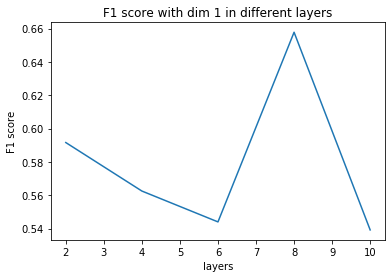

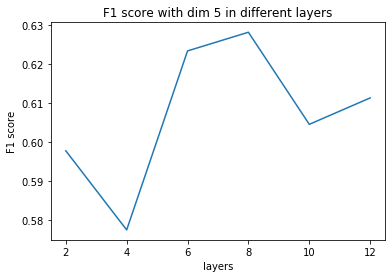

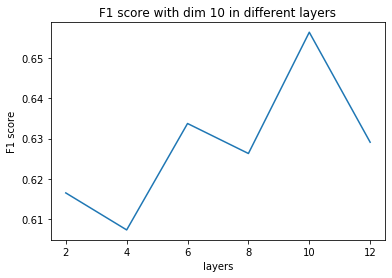

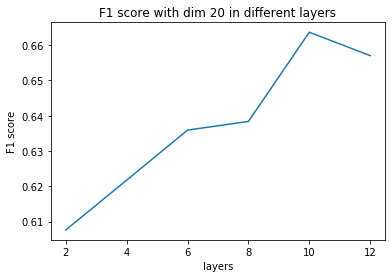

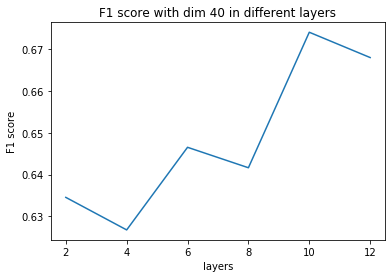

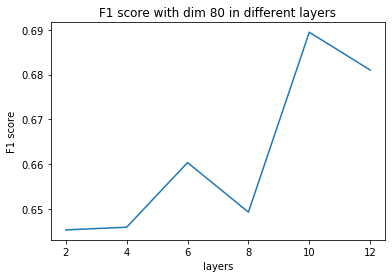

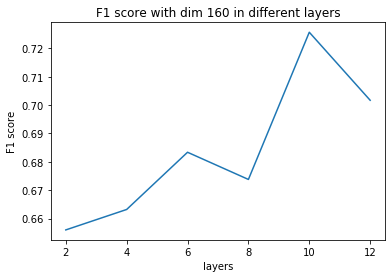

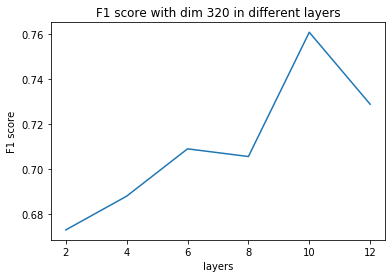

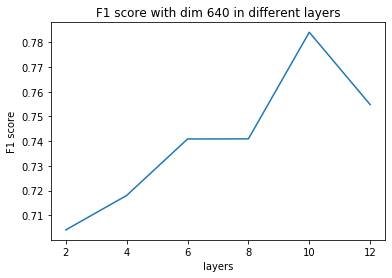

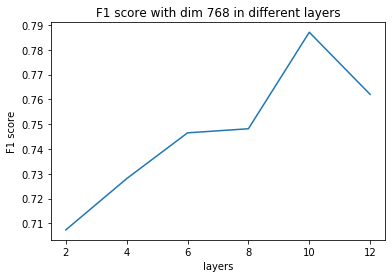

In [62]:
for dim in [1,5,10,20,40,80,160,320,640,768]:
    plot_one_dim(results_dict_0,dim)

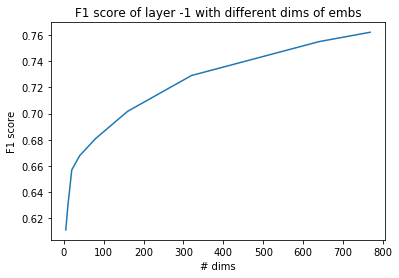

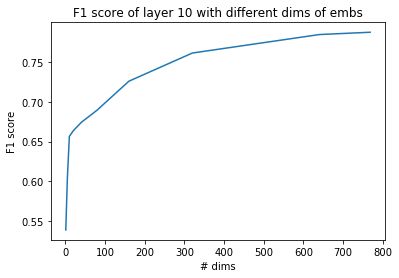

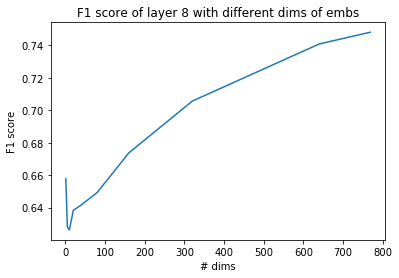

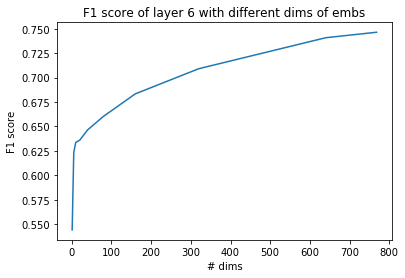

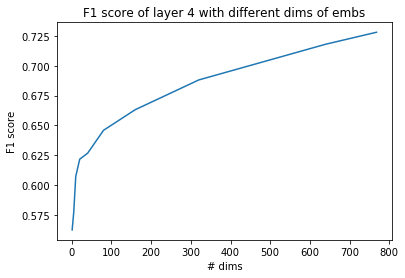

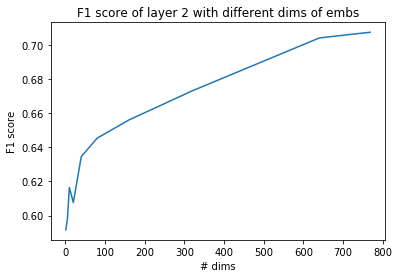

In [60]:
for layer in results_dict_0:
    plot_one_layer(results_dict_0,layer)

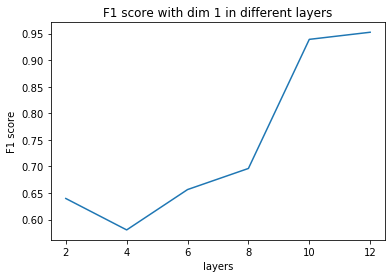

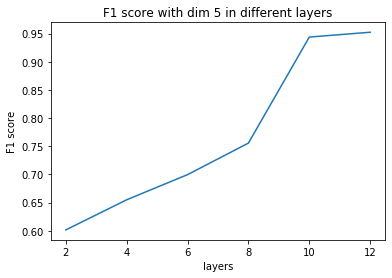

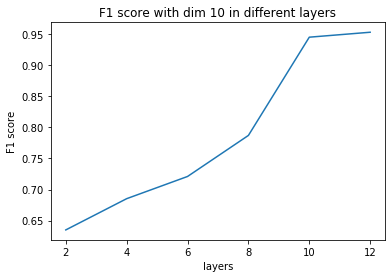

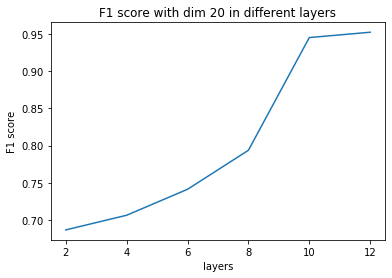

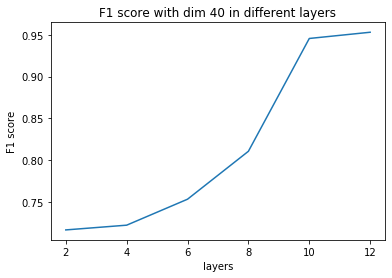

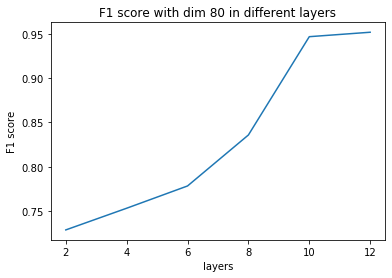

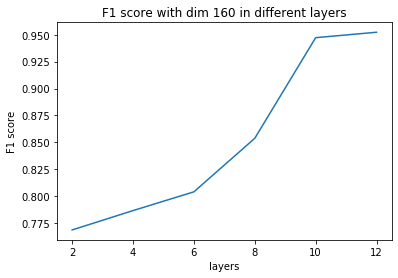

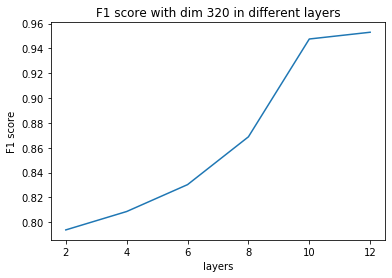

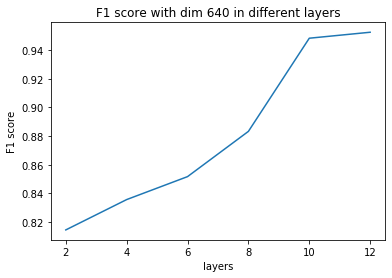

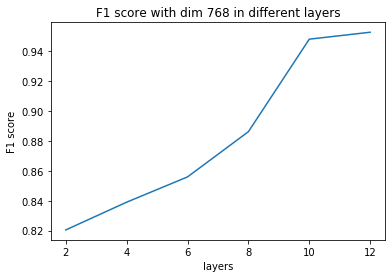

In [65]:
for dim in [1,5,10,20,40,80,160,320,640,768]:
    plot_one_dim(results_dict_34000,dim)

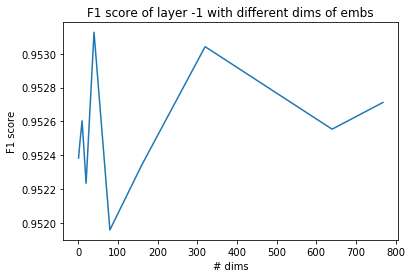

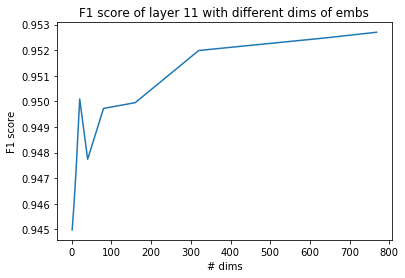

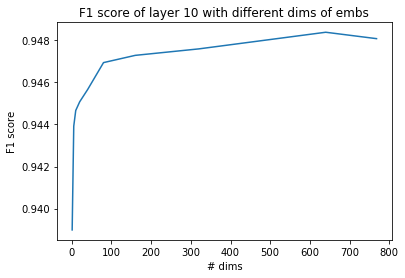

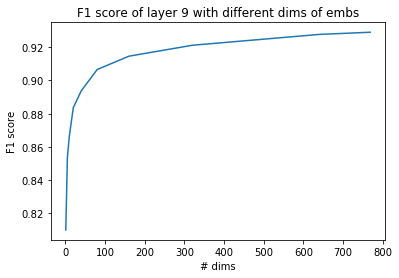

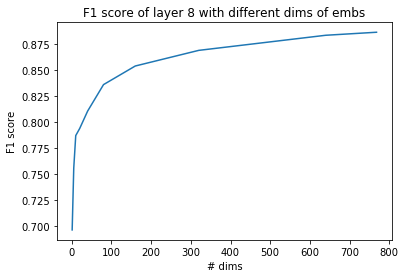

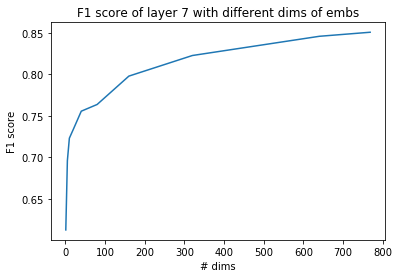

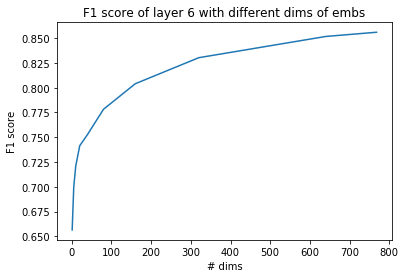

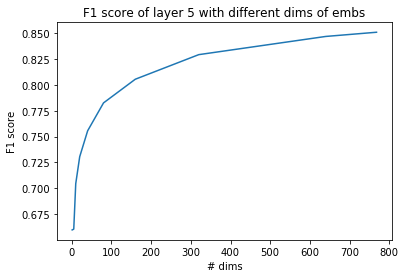

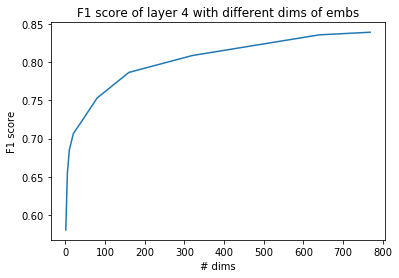

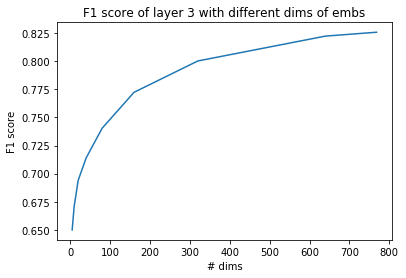

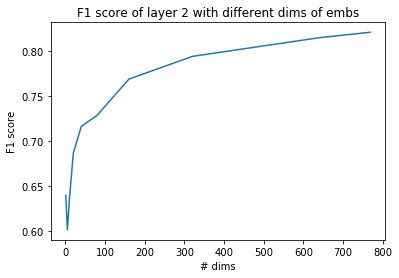

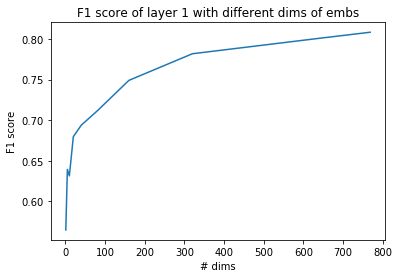

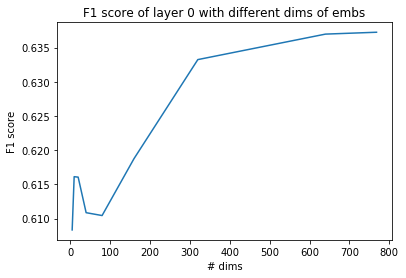

In [66]:
for layer in results_dict_34000:
    plot_one_layer(results_dict_34000,layer)

## show BoWs

In [88]:
BoW_list=cnt_vectorizer.get_feature_names()

In [92]:
BoW_list=np.array(BoW_list)

In [94]:
BoW_list[results_34000[6][0]['idx_aligned_trained']]

array(['going', 'bruce', 'randy', 'gavin', 'bingo', 'top', 'minute',
       'good', 'goodcents', 'prepare', 'usually', 'meh', 'omg', 'let',
       '111', 'love', 'one', 'reheating', 'back', 'couldve', 'asked',
       'ziti', 'got', 'roomy', 'roosevelt', 'canolis', 'went', 'muddled',
       'pay', 'worst', 'tux', 'chronic', 'bulgogi', 'would', 'conscious',
       'wow', 'horrible', 'like', 'customer', 'bakery', 'marker', 'merge',
       'get', 'review', 'shoveling', 'deleted', 'u', 'gratifying', 'rude',
       'charmed', 'delicious', 'pin', 'fined', 'nyer', '1990', 'great',
       'bangkok', 'nsummary', '6p', 'ever', 'soundly', 'n', 'time',
       'first', 'service', 'gabriel', 'ni', 'fan', 'nthe', 'year', 'best',
       'star', 'several', 'always', 'sp', 'severs', 'want', 'place',
       'cringe', 'sfo', 'amazing', 'said', 'cliche', 'daughter',
       'lodging', 'never', 'update', 'cross', 'told', 'favorite', 'know',
       'hate', 'go', 'tolteca', 'md', 'preface', 'dear', 'oh', 'broug